In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [2]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [3]:
# Import libraries for tensors
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# For fbeta-score
from torchmetrics.functional import fbeta_score

In [5]:
# For model construction
from collections import OrderedDict

In [6]:
# Import tqdm for progress bar construction
import tqdm

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [8]:
# Hyper-parameters for K-Fold Cross Validation
N = 8
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)

# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [9]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=N, shuffle=True, random_state=seed
)

In [10]:
# Modify dataframe for K-Fold Cross Validation (birdclef2021)
birdclef_csv = pandas.read_csv(AudioImage_Path + 'metadata.csv')
birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
    AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
    birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

birdclef_csv = birdclef_csv.dropna()
birdclef_csv = birdclef_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
birdclef_dataframe = birdclef_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
    birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [11]:
# Class for Birdclef dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        self.batch_threshold = 64
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        label_rp = N
        
        # Apply transform
        if self.process == 'train':
            source = torch.stack([self.train_transform(Image.fromarray(x)) for x in source])
        elif self.process == 'valid':
            source = torch.stack([self.val_transform(Image.fromarray(x)) for x in source])
        
        # Avoid CUDA OOM
        if N > self.batch_threshold:
            unit = (N - self.batch_threshold) // 2
            label_rp = self.batch_threshold
            if N % 2 == 0:
                source = source[unit : -unit]
            else:
                source = source[unit : -(unit + 1)]
        
        return source, torch.tensor(self.labels[idx], dtype=ltype).repeat(label_rp)
    
    def __len__(self):
        return len(self.dataframe)

This function evaluates model.

In [12]:
def evaluate_model(loader, model, beta=1.0):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)
            scores = model(torch.squeeze(x, 0))
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.cross_entropy(scores, y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)
            
            # Erase memory caches
            del x, y, scores, log_loss
        
        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

Let's train with model 2.

In [13]:
import os

# Print period for accuracy.
print_period = 1000

# Hyper-parameters for training 
birdclef_batch = 1
birdclef_epoch = 50

# Learning Rate.
learning_rate_2 = 0.0005
eta_min = 5e-6
momentum = 0.5

# L2 Regularization Hyperparamter
weight_decay_2 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 2.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 397.
class Model2(nn.Module):
    def __init__(self, num_classes=397):
        super().__init__()
        self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
        self.relu = nn.ReLU().to(device)
        self.linear = nn.Linear(1000, num_classes, bias=True).to(device)
    
    def forward (self, x):
        x = self.resnet50(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

cur_model = Model2()
print(cur_model)

def checkpoint(model, optimizer, scheduler, train_losses, val_losses, log_scores, fbeta_scores, epoch):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'log_scores': log_scores,
            'fbeta_scores': fbeta_scores,
            }, './bird_specificator.pt')

def train_model(model, train_loader, val_loader, optimizer, scheduler, beta=beta, epoch=birdclef_epoch, ckpt_enable=True):
    val_losses = []
    train_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    saved_epoch = -1
    
    # Load checkpoint
    if ckpt_enable and os.path.exists('./bird_specificator.pt'):
        ckpt = torch.load('./bird_specificator.pt', map_location=device)
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        train_losses = ckpt['train_losses']
        val_losses = ckpt['val_losses']
        log_scores = ckpt['log_scores']
        fbeta_scores = ckpt['fbeta_scores']
        saved_epoch = ckpt['epoch']
    
    for e in range(epoch):
        if e <= saved_epoch:
            continue
            
        epoch_losses = []
        print(f"Training model 2, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):          
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)

            scores = model(torch.squeeze(x, 0))
            loss = F.cross_entropy(scores, y) # Log loss for our project.

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            # every print_period, print loss.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
                
            # Erase memory caches
            del source, label, x, y, scores, loss
            
        # Cosine LR Annealing Scheduler
        scheduler.step()
        
        # Append the score to lists
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)
        
        # every epoch, save the model
        checkpoint(model, optimizer, scheduler, train_losses, val_losses, log_scores, fbeta_scores, e)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Model2(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [14]:
# Train loop for bird specificator
def bird_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = birdclef(train_dataframe, process='train', labels='label_id')
    val_data = birdclef(val_dataframe, process='valid', labels='label_id')
    test_data = birdclef(test_dataframe, process='valid', labels='label_id')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=birdclef_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate_2, weight_decay=weight_decay_2, momentum=momentum)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=birdclef_epoch, eta_min=eta_min)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, scheduler, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [15]:
# Train, Validate and Test for nocall detector
def bird(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = bird_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [16]:
val_losses, train_losses, log_scores, fbeta_scores, test_scores = \
    bird(cur_model, birdclef_dataframe, 1, 0)
del cur_model

# for i in range(2, 10):
#     cur_model = Model2()
#     cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, birdclef_dataframe, i, 0)
#     val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
#     train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
#     log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
#     fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
#     for j in range(len(test_scores)):
#         test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Test set : 0, Validation set : 1
Training model 2, epoch 1


  0%|                                                                             | 3/47154 [00:08<28:50:25,  2.20s/it]

Iteration 0, loss = 6.2915


  2%|█▋                                                                           | 1002/47154 [01:31<48:41, 15.80it/s]

Iteration 1000, loss = 5.3156


  4%|███▏                                                                       | 2002/47154 [02:54<1:10:17, 10.71it/s]

Iteration 2000, loss = 6.1054


  6%|████▉                                                                        | 3003/47154 [04:15<54:23, 13.53it/s]

Iteration 3000, loss = 6.5715


  8%|██████▌                                                                      | 4002/47154 [05:36<47:19, 15.20it/s]

Iteration 4000, loss = 6.6375


 11%|███████▉                                                                   | 5003/47154 [06:58<1:01:44, 11.38it/s]

Iteration 5000, loss = 6.6683


 13%|█████████▌                                                                 | 6002/47154 [08:19<1:11:43,  9.56it/s]

Iteration 6000, loss = 6.0933


 15%|███████████▍                                                                 | 7004/47154 [09:39<52:17, 12.80it/s]

Iteration 7000, loss = 6.4062


 17%|█████████████                                                                | 8000/47154 [11:03<59:04, 11.05it/s]

Iteration 8000, loss = 5.1773


 19%|██████████████▎                                                            | 9002/47154 [12:23<1:00:50, 10.45it/s]

Iteration 9000, loss = 5.0860


 21%|███████████████▋                                                          | 10003/47154 [13:46<1:05:48,  9.41it/s]

Iteration 10000, loss = 6.0991


 23%|█████████████████▋                                                          | 11003/47154 [15:10<38:10, 15.79it/s]

Iteration 11000, loss = 5.0188


 25%|███████████████████▎                                                        | 12002/47154 [16:31<43:47, 13.38it/s]

Iteration 12000, loss = 6.0232


 28%|████████████████████▉                                                       | 13005/47154 [17:53<40:20, 14.11it/s]

Iteration 13000, loss = 5.3131


 30%|██████████████████████▌                                                     | 14003/47154 [19:14<42:57, 12.86it/s]

Iteration 14000, loss = 4.8434


 32%|████████████████████████▏                                                   | 15003/47154 [20:33<30:26, 17.60it/s]

Iteration 15000, loss = 5.1965


 34%|█████████████████████████▊                                                  | 16003/47154 [21:55<46:38, 11.13it/s]

Iteration 16000, loss = 6.4800


 36%|███████████████████████████▍                                                | 17001/47154 [23:18<34:37, 14.51it/s]

Iteration 17000, loss = 5.4269


 38%|█████████████████████████████                                               | 18002/47154 [24:36<32:58, 14.74it/s]

Iteration 18000, loss = 4.6613


 40%|██████████████████████████████▋                                             | 19002/47154 [25:57<35:48, 13.10it/s]

Iteration 19000, loss = 5.8464


 42%|████████████████████████████████▏                                           | 20005/47154 [27:15<24:49, 18.23it/s]

Iteration 20000, loss = 5.1301


 45%|█████████████████████████████████▊                                          | 21003/47154 [28:34<33:05, 13.17it/s]

Iteration 21000, loss = 6.2710


 47%|███████████████████████████████████▍                                        | 22002/47154 [29:56<27:27, 15.27it/s]

Iteration 22000, loss = 5.0180


 49%|█████████████████████████████████████                                       | 23003/47154 [31:12<37:48, 10.65it/s]

Iteration 23000, loss = 6.4911


 51%|██████████████████████████████████████▋                                     | 24004/47154 [32:32<27:09, 14.21it/s]

Iteration 24000, loss = 5.9113


 53%|████████████████████████████████████████▎                                   | 25003/47154 [33:53<21:32, 17.13it/s]

Iteration 25000, loss = 6.6021


 55%|█████████████████████████████████████████▉                                  | 26001/47154 [35:15<22:15, 15.84it/s]

Iteration 26000, loss = 5.1169


 57%|███████████████████████████████████████████▌                                | 27003/47154 [36:34<20:14, 16.59it/s]

Iteration 27000, loss = 4.9598


 59%|█████████████████████████████████████████████▏                              | 28005/47154 [37:55<16:54, 18.87it/s]

Iteration 28000, loss = 5.5168


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [39:17<19:41, 15.36it/s]

Iteration 29000, loss = 5.3567


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [40:38<21:08, 13.52it/s]

Iteration 30000, loss = 6.2845


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [42:02<24:10, 11.14it/s]

Iteration 31000, loss = 4.0653


 68%|███████████████████████████████████████████████████▌                        | 32002/47154 [43:20<16:53, 14.95it/s]

Iteration 32000, loss = 6.1748


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [44:41<14:45, 15.99it/s]

Iteration 33000, loss = 5.9097


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [46:02<18:02, 12.15it/s]

Iteration 34000, loss = 4.6192


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [47:23<12:28, 16.24it/s]

Iteration 35000, loss = 6.3095


 76%|██████████████████████████████████████████████████████████                  | 36001/47154 [48:40<14:56, 12.44it/s]

Iteration 36000, loss = 5.3420


 78%|███████████████████████████████████████████████████████████▋                | 37002/47154 [50:01<11:26, 14.78it/s]

Iteration 37000, loss = 4.4797


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [51:20<09:06, 16.73it/s]

Iteration 38000, loss = 6.4841


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [52:40<10:02, 13.54it/s]

Iteration 39000, loss = 5.7775


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [54:07<09:54, 12.03it/s]

Iteration 40000, loss = 5.6972


 87%|██████████████████████████████████████████████████████████████████          | 41005/47154 [55:29<08:43, 11.75it/s]

Iteration 41000, loss = 5.1956


 89%|███████████████████████████████████████████████████████████████████▋        | 42004/47154 [56:46<07:15, 11.83it/s]

Iteration 42000, loss = 5.2779


 91%|█████████████████████████████████████████████████████████████████████▎      | 43003/47154 [58:11<06:12, 11.14it/s]

Iteration 43000, loss = 6.1860


 93%|██████████████████████████████████████████████████████████████████████▉     | 44002/47154 [59:31<03:58, 13.20it/s]

Iteration 44000, loss = 6.2774


 95%|██████████████████████████████████████████████████████████████████████▌   | 45001/47154 [1:00:48<02:18, 15.51it/s]

Iteration 45000, loss = 5.1488


 98%|████████████████████████████████████████████████████████████████████████▏ | 46002/47154 [1:02:10<01:09, 16.54it/s]

Iteration 46000, loss = 6.7258


100%|█████████████████████████████████████████████████████████████████████████▊| 47002/47154 [1:03:32<00:11, 13.24it/s]

Iteration 47000, loss = 4.6700


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:03:43<00:00, 12.33it/s]


Checking accuracy score on validation set.

Accuracy: 2949 / 83918 correct (3.51)
Log Loss score:	5.41
Fbeta-score (beta=1): 	0.04
Training model 2, epoch 2


  0%|                                                                              | 1/47154 [00:00<1:39:01,  7.94it/s]

Iteration 0, loss = 7.5624


  2%|█▋                                                                           | 1003/47154 [01:12<44:34, 17.26it/s]

Iteration 1000, loss = 7.1843


  4%|███▎                                                                         | 2004/47154 [02:29<49:07, 15.32it/s]

Iteration 2000, loss = 4.7703


  6%|████▊                                                                      | 3004/47154 [03:46<1:01:46, 11.91it/s]

Iteration 3000, loss = 5.1087


  8%|██████▎                                                                    | 4001/47154 [05:03<1:02:03, 11.59it/s]

Iteration 4000, loss = 4.8873


 11%|████████▏                                                                    | 5005/47154 [06:20<39:40, 17.71it/s]

Iteration 5000, loss = 4.6242


 13%|█████████▊                                                                   | 6003/47154 [07:34<43:19, 15.83it/s]

Iteration 6000, loss = 4.2682


 15%|███████████▍                                                                 | 7004/47154 [08:50<51:14, 13.06it/s]

Iteration 7000, loss = 6.7092


 17%|█████████████                                                                | 8004/47154 [10:05<42:50, 15.23it/s]

Iteration 8000, loss = 3.5192


 19%|██████████████▋                                                              | 9004/47154 [11:19<50:22, 12.62it/s]

Iteration 9000, loss = 5.0534


 21%|████████████████▏                                                           | 10005/47154 [12:34<36:54, 16.78it/s]

Iteration 10000, loss = 3.6423


 23%|█████████████████▋                                                          | 11004/47154 [13:51<38:34, 15.62it/s]

Iteration 11000, loss = 2.8249


 25%|███████████████████▎                                                        | 12004/47154 [15:09<32:48, 17.85it/s]

Iteration 12000, loss = 3.6363


 28%|████████████████████▉                                                       | 13003/47154 [16:25<42:33, 13.38it/s]

Iteration 13000, loss = 4.0428


 30%|██████████████████████▌                                                     | 14003/47154 [17:39<50:21, 10.97it/s]

Iteration 14000, loss = 4.0671


 32%|████████████████████████▏                                                   | 15002/47154 [18:57<39:03, 13.72it/s]

Iteration 15000, loss = 3.7129


 34%|█████████████████████████▊                                                  | 16003/47154 [20:15<32:17, 16.08it/s]

Iteration 16000, loss = 5.6422


 36%|███████████████████████████▍                                                | 17003/47154 [21:29<36:17, 13.85it/s]

Iteration 17000, loss = 5.1110


 38%|█████████████████████████████                                               | 18003/47154 [22:45<33:23, 14.55it/s]

Iteration 18000, loss = 5.0874


 40%|██████████████████████████████▋                                             | 19003/47154 [24:02<41:58, 11.18it/s]

Iteration 19000, loss = 3.4005


 42%|████████████████████████████████▏                                           | 20002/47154 [25:17<46:35,  9.71it/s]

Iteration 20000, loss = 5.6181


 45%|█████████████████████████████████▊                                          | 21003/47154 [26:31<25:51, 16.86it/s]

Iteration 21000, loss = 1.2928


 47%|███████████████████████████████████▍                                        | 22004/47154 [27:46<24:09, 17.35it/s]

Iteration 22000, loss = 6.8514


 49%|█████████████████████████████████████                                       | 23003/47154 [29:06<34:43, 11.59it/s]

Iteration 23000, loss = 6.0603


 51%|██████████████████████████████████████▋                                     | 24004/47154 [30:20<37:12, 10.37it/s]

Iteration 24000, loss = 2.5999


 53%|████████████████████████████████████████▎                                   | 25003/47154 [31:37<26:50, 13.76it/s]

Iteration 25000, loss = 4.8794


 55%|█████████████████████████████████████████▉                                  | 26004/47154 [32:53<30:45, 11.46it/s]

Iteration 26000, loss = 7.9611


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:07<27:33, 12.19it/s]

Iteration 27000, loss = 3.1158


 59%|█████████████████████████████████████████████▏                              | 28001/47154 [35:23<21:02, 15.18it/s]

Iteration 28000, loss = 4.1702


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [36:39<23:41, 12.77it/s]

Iteration 29000, loss = 4.1709


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [37:50<21:57, 13.02it/s]

Iteration 30000, loss = 2.8715


 66%|█████████████████████████████████████████████████▉                          | 31000/47154 [39:04<21:22, 12.60it/s]

Iteration 31000, loss = 4.7638


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [40:21<12:53, 19.59it/s]

Iteration 32000, loss = 0.8214


 70%|█████████████████████████████████████████████████████▏                      | 33004/47154 [41:37<22:54, 10.29it/s]

Iteration 33000, loss = 3.2672


 72%|██████████████████████████████████████████████████████▊                     | 34002/47154 [42:54<20:41, 10.59it/s]

Iteration 34000, loss = 6.3087


 74%|████████████████████████████████████████████████████████▍                   | 35001/47154 [44:10<14:19, 14.14it/s]

Iteration 35000, loss = 4.9778


 76%|██████████████████████████████████████████████████████████                  | 35999/47154 [45:25<14:43, 12.63it/s]

Iteration 36000, loss = 2.8736


 78%|███████████████████████████████████████████████████████████▋                | 37004/47154 [46:39<11:29, 14.72it/s]

Iteration 37000, loss = 3.9211


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [47:54<08:20, 18.28it/s]

Iteration 38000, loss = 1.6263


 83%|██████████████████████████████████████████████████████████████▊             | 39004/47154 [49:08<08:40, 15.65it/s]

Iteration 39000, loss = 5.0253


 85%|████████████████████████████████████████████████████████████████▍           | 40004/47154 [50:23<08:24, 14.19it/s]

Iteration 40000, loss = 5.5163


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [51:38<09:29, 10.81it/s]

Iteration 41000, loss = 3.7305


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [52:55<07:07, 12.05it/s]

Iteration 42000, loss = 3.8902


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [54:10<05:28, 12.65it/s]

Iteration 43000, loss = 0.1733


 93%|██████████████████████████████████████████████████████████████████████▉     | 44004/47154 [55:28<03:34, 14.69it/s]

Iteration 44000, loss = 2.4646


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [56:43<03:16, 10.92it/s]

Iteration 45000, loss = 3.0307


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [57:58<01:16, 14.99it/s]

Iteration 46000, loss = 1.4112


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:15<00:09, 16.21it/s]

Iteration 47000, loss = 0.7890


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:26<00:00, 13.22it/s]


Checking accuracy score on validation set.

Accuracy: 23256 / 83918 correct (27.71)
Log Loss score:	3.57
Fbeta-score (beta=1): 	0.28
Training model 2, epoch 3


  0%|                                                                              | 3/47154 [00:00<1:17:40, 10.12it/s]

Iteration 0, loss = 2.7387


  2%|█▋                                                                           | 1004/47154 [01:14<48:36, 15.82it/s]

Iteration 1000, loss = 6.1914


  4%|███▏                                                                       | 2004/47154 [02:25<1:04:19, 11.70it/s]

Iteration 2000, loss = 3.5800


  6%|████▊                                                                      | 3002/47154 [03:45<1:35:59,  7.67it/s]

Iteration 3000, loss = 2.8603


  8%|██████▌                                                                      | 4003/47154 [04:59<43:06, 16.68it/s]

Iteration 4000, loss = 4.0642


 11%|████████▏                                                                    | 5003/47154 [06:12<42:31, 16.52it/s]

Iteration 5000, loss = 5.4186


 13%|█████████▊                                                                   | 6004/47154 [07:25<37:11, 18.44it/s]

Iteration 6000, loss = 4.7514


 15%|███████████▍                                                                 | 7002/47154 [08:39<50:47, 13.18it/s]

Iteration 7000, loss = 0.0765


 17%|█████████████                                                                | 8003/47154 [09:54<48:50, 13.36it/s]

Iteration 8000, loss = 1.9246


 19%|██████████████▋                                                              | 9002/47154 [11:08<45:06, 14.10it/s]

Iteration 9000, loss = 5.0592


 21%|████████████████                                                            | 10001/47154 [12:25<41:25, 14.95it/s]

Iteration 10000, loss = 2.4269


 23%|█████████████████▋                                                          | 11004/47154 [13:41<31:08, 19.35it/s]

Iteration 11000, loss = 3.5256


 25%|███████████████████▎                                                        | 12003/47154 [14:58<50:33, 11.59it/s]

Iteration 12000, loss = 1.9496


 28%|████████████████████▉                                                       | 13000/47154 [16:14<52:20, 10.88it/s]

Iteration 13000, loss = 2.2598


 30%|██████████████████████▌                                                     | 14004/47154 [17:31<40:59, 13.48it/s]

Iteration 14000, loss = 2.3655


 32%|████████████████████████▏                                                   | 15001/47154 [18:51<47:32, 11.27it/s]

Iteration 15000, loss = 2.0260


 34%|█████████████████████████▊                                                  | 16005/47154 [20:04<37:58, 13.67it/s]

Iteration 16000, loss = 4.9835


 36%|███████████████████████████▍                                                | 17003/47154 [21:19<27:30, 18.27it/s]

Iteration 17000, loss = 3.1878


 38%|█████████████████████████████                                               | 18002/47154 [22:33<44:57, 10.81it/s]

Iteration 18000, loss = 3.6385


 40%|██████████████████████████████▋                                             | 19002/47154 [23:48<37:55, 12.37it/s]

Iteration 19000, loss = 3.7542


 42%|████████████████████████████████▏                                           | 20001/47154 [25:04<36:52, 12.27it/s]

Iteration 20000, loss = 3.0923


 45%|█████████████████████████████████▊                                          | 21002/47154 [26:22<28:40, 15.20it/s]

Iteration 21000, loss = 2.6506


 47%|███████████████████████████████████▍                                        | 22003/47154 [27:39<25:45, 16.27it/s]

Iteration 22000, loss = 2.0877


 49%|█████████████████████████████████████                                       | 23003/47154 [28:56<29:27, 13.66it/s]

Iteration 23000, loss = 3.5360


 51%|██████████████████████████████████████▋                                     | 24004/47154 [30:11<22:34, 17.09it/s]

Iteration 24000, loss = 6.3167


 53%|████████████████████████████████████████▎                                   | 25005/47154 [31:27<24:49, 14.87it/s]

Iteration 25000, loss = 4.7917


 55%|█████████████████████████████████████████▉                                  | 26001/47154 [32:42<31:13, 11.29it/s]

Iteration 26000, loss = 2.1363


 57%|███████████████████████████████████████████▌                                | 27005/47154 [33:53<17:26, 19.25it/s]

Iteration 27000, loss = 4.0254


 59%|█████████████████████████████████████████████▏                              | 28005/47154 [35:08<21:39, 14.74it/s]

Iteration 28000, loss = 7.0320


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [36:24<20:22, 14.85it/s]

Iteration 29000, loss = 5.0285


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [37:40<19:01, 15.03it/s]

Iteration 30000, loss = 3.5449


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [38:58<21:30, 12.51it/s]

Iteration 31000, loss = 3.2476


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [40:16<17:47, 14.19it/s]

Iteration 32000, loss = 3.7906


 70%|█████████████████████████████████████████████████████▏                      | 33004/47154 [41:29<21:13, 11.11it/s]

Iteration 33000, loss = 0.3361


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [42:48<13:10, 16.64it/s]

Iteration 34000, loss = 1.8730


 74%|████████████████████████████████████████████████████████▍                   | 35005/47154 [44:04<10:19, 19.61it/s]

Iteration 35000, loss = 5.2875


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [45:20<14:54, 12.46it/s]

Iteration 36000, loss = 5.2570


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [46:32<13:15, 12.76it/s]

Iteration 37000, loss = 2.8950


 81%|█████████████████████████████████████████████████████████████▏              | 38002/47154 [47:53<13:46, 11.07it/s]

Iteration 38000, loss = 3.5945


 83%|██████████████████████████████████████████████████████████████▊             | 38999/47154 [49:09<08:51, 15.35it/s]

Iteration 39000, loss = 0.3976


 85%|████████████████████████████████████████████████████████████████▍           | 40000/47154 [50:24<12:16,  9.71it/s]

Iteration 40000, loss = 1.9763


 87%|██████████████████████████████████████████████████████████████████          | 41001/47154 [51:38<06:40, 15.37it/s]

Iteration 41000, loss = 4.5997


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [52:51<06:30, 13.21it/s]

Iteration 42000, loss = 2.7891


 91%|█████████████████████████████████████████████████████████████████████▎      | 43001/47154 [54:07<05:15, 13.16it/s]

Iteration 43000, loss = 0.6012


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [55:21<04:17, 12.22it/s]

Iteration 44000, loss = 4.8103


 95%|████████████████████████████████████████████████████████████████████████▌   | 45002/47154 [56:35<03:55,  9.15it/s]

Iteration 45000, loss = 3.8795


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [57:49<01:07, 16.99it/s]

Iteration 46000, loss = 1.7045


100%|███████████████████████████████████████████████████████████████████████████▊| 47002/47154 [59:04<00:12, 12.51it/s]

Iteration 47000, loss = 2.0775


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:16<00:00, 13.26it/s]


Checking accuracy score on validation set.

Accuracy: 31296 / 83918 correct (37.29)
Log Loss score:	3.04
Fbeta-score (beta=1): 	0.37
Training model 2, epoch 4


  0%|                                                                              | 2/47154 [00:00<1:21:54,  9.59it/s]

Iteration 0, loss = 1.4061


  2%|█▋                                                                           | 1005/47154 [01:17<48:14, 15.95it/s]

Iteration 1000, loss = 0.0156


  4%|███▎                                                                         | 2005/47154 [02:30<39:02, 19.28it/s]

Iteration 2000, loss = 2.1254


  6%|████▊                                                                      | 3003/47154 [03:50<1:01:14, 12.01it/s]

Iteration 3000, loss = 8.5052


  8%|██████▌                                                                      | 4004/47154 [05:08<51:08, 14.06it/s]

Iteration 4000, loss = 0.4842


 11%|████████▏                                                                    | 5004/47154 [06:22<54:06, 12.98it/s]

Iteration 5000, loss = 2.9347


 13%|█████████▊                                                                   | 6000/47154 [07:41<54:07, 12.67it/s]

Iteration 6000, loss = 3.6671


 15%|███████████▍                                                                 | 7004/47154 [09:02<55:02, 12.16it/s]

Iteration 7000, loss = 3.9861


 17%|█████████████                                                                | 8004/47154 [10:19<41:36, 15.68it/s]

Iteration 8000, loss = 1.5014


 19%|██████████████▋                                                              | 9002/47154 [11:36<48:20, 13.15it/s]

Iteration 9000, loss = 2.3826


 21%|████████████████                                                            | 10001/47154 [12:52<39:26, 15.70it/s]

Iteration 10000, loss = 3.2807


 23%|█████████████████▋                                                          | 11002/47154 [14:10<47:57, 12.56it/s]

Iteration 11000, loss = 1.6824


 25%|███████████████████▎                                                        | 12002/47154 [15:27<53:02, 11.05it/s]

Iteration 12000, loss = 3.4518


 28%|████████████████████▉                                                       | 13004/47154 [16:44<38:42, 14.71it/s]

Iteration 13000, loss = 4.2843


 30%|██████████████████████▌                                                     | 14003/47154 [18:01<44:28, 12.42it/s]

Iteration 14000, loss = 1.1557


 32%|████████████████████████▏                                                   | 15002/47154 [19:20<35:33, 15.07it/s]

Iteration 15000, loss = 4.4471


 34%|█████████████████████████▊                                                  | 16003/47154 [20:36<32:27, 15.99it/s]

Iteration 16000, loss = 3.4785


 36%|███████████████████████████▍                                                | 17002/47154 [21:51<40:07, 12.52it/s]

Iteration 17000, loss = 0.6585


 38%|█████████████████████████████                                               | 18002/47154 [23:08<23:50, 20.38it/s]

Iteration 18000, loss = 0.0678


 40%|██████████████████████████████▋                                             | 19003/47154 [24:25<31:21, 14.96it/s]

Iteration 19000, loss = 4.4284


 42%|████████████████████████████████▏                                           | 20004/47154 [25:42<28:46, 15.73it/s]

Iteration 20000, loss = 3.0045


 45%|█████████████████████████████████▊                                          | 21002/47154 [27:01<31:10, 13.98it/s]

Iteration 21000, loss = 3.1721


 47%|███████████████████████████████████▍                                        | 22004/47154 [28:19<28:11, 14.87it/s]

Iteration 22000, loss = 5.5840


 49%|█████████████████████████████████████                                       | 23004/47154 [29:34<26:52, 14.98it/s]

Iteration 23000, loss = 0.0672


 51%|██████████████████████████████████████▋                                     | 24003/47154 [30:57<26:31, 14.54it/s]

Iteration 24000, loss = 1.8136


 53%|████████████████████████████████████████▎                                   | 25002/47154 [32:11<22:01, 16.77it/s]

Iteration 25000, loss = 0.2330


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [33:29<27:30, 12.81it/s]

Iteration 26000, loss = 1.1647


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:47<28:55, 11.61it/s]

Iteration 27000, loss = 0.0649


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [36:00<22:53, 13.94it/s]

Iteration 28000, loss = 3.6300


 62%|██████████████████████████████████████████████▋                             | 29000/47154 [37:16<24:25, 12.39it/s]

Iteration 29000, loss = 4.9705


 64%|████████████████████████████████████████████████▎                           | 30001/47154 [38:36<19:48, 14.43it/s]

Iteration 30000, loss = 2.4076


 66%|█████████████████████████████████████████████████▉                          | 31002/47154 [40:00<31:48,  8.46it/s]

Iteration 31000, loss = 2.3074


 68%|███████████████████████████████████████████████████▌                        | 32003/47154 [41:19<14:56, 16.90it/s]

Iteration 32000, loss = 0.0104


 70%|█████████████████████████████████████████████████████▏                      | 33002/47154 [42:38<16:29, 14.30it/s]

Iteration 33000, loss = 0.1081


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [43:51<14:52, 14.73it/s]

Iteration 34000, loss = 1.4692


 74%|████████████████████████████████████████████████████████▍                   | 35001/47154 [45:06<16:47, 12.06it/s]

Iteration 35000, loss = 1.1646


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [46:24<18:23, 10.11it/s]

Iteration 36000, loss = 1.2581


 78%|███████████████████████████████████████████████████████████▋                | 37002/47154 [47:39<13:27, 12.57it/s]

Iteration 37000, loss = 2.4729


 81%|█████████████████████████████████████████████████████████████▏              | 38002/47154 [48:58<18:24,  8.29it/s]

Iteration 38000, loss = 1.2633


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [50:15<08:30, 15.96it/s]

Iteration 39000, loss = 0.2773


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [51:34<08:47, 13.57it/s]

Iteration 40000, loss = 1.2066


 87%|██████████████████████████████████████████████████████████████████          | 41002/47154 [52:51<09:01, 11.35it/s]

Iteration 41000, loss = 1.7778


 89%|███████████████████████████████████████████████████████████████████▋        | 42004/47154 [54:10<07:44, 11.08it/s]

Iteration 42000, loss = 1.3827


 91%|█████████████████████████████████████████████████████████████████████▎      | 43003/47154 [55:25<04:45, 14.54it/s]

Iteration 43000, loss = 4.9159


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [56:40<04:45, 11.05it/s]

Iteration 44000, loss = 4.3240


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [57:56<02:18, 15.52it/s]

Iteration 45000, loss = 0.6875


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46002/47154 [59:15<01:42, 11.21it/s]

Iteration 46000, loss = 0.6022


100%|█████████████████████████████████████████████████████████████████████████▊| 47002/47154 [1:00:33<00:10, 15.04it/s]

Iteration 47000, loss = 2.8583


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:00:44<00:00, 12.94it/s]


Checking accuracy score on validation set.

Accuracy: 35703 / 83918 correct (42.55)
Log Loss score:	2.74
Fbeta-score (beta=1): 	0.43
Training model 2, epoch 5


  0%|                                                                              | 1/47154 [00:00<1:39:48,  7.87it/s]

Iteration 0, loss = 4.6395


  2%|█▌                                                                         | 1002/47154 [01:16<1:01:40, 12.47it/s]

Iteration 1000, loss = 8.3143


  4%|███▏                                                                       | 2004/47154 [02:33<1:01:20, 12.27it/s]

Iteration 2000, loss = 0.4648


  6%|████▉                                                                        | 3003/47154 [03:48<41:56, 17.55it/s]

Iteration 3000, loss = 3.6287


  8%|██████▌                                                                      | 4004/47154 [05:05<49:05, 14.65it/s]

Iteration 4000, loss = 4.0136


 11%|████████▏                                                                    | 5002/47154 [06:22<42:02, 16.71it/s]

Iteration 5000, loss = 0.0019


 13%|█████████▌                                                                 | 6003/47154 [07:36<1:13:59,  9.27it/s]

Iteration 6000, loss = 0.9404


 15%|███████████▍                                                                 | 7006/47154 [08:52<39:43, 16.84it/s]

Iteration 7000, loss = 0.4025


 17%|█████████████                                                                | 8002/47154 [10:08<50:27, 12.93it/s]

Iteration 8000, loss = 5.0211


 19%|██████████████▋                                                              | 9002/47154 [11:24<46:30, 13.67it/s]

Iteration 9000, loss = 0.5629


 21%|████████████████                                                            | 10003/47154 [12:39<39:14, 15.78it/s]

Iteration 10000, loss = 0.3384


 23%|█████████████████▋                                                          | 11005/47154 [13:54<33:59, 17.72it/s]

Iteration 11000, loss = 1.6241


 25%|███████████████████▎                                                        | 12004/47154 [15:12<45:27, 12.89it/s]

Iteration 12000, loss = 2.4697


 28%|████████████████████▉                                                       | 13003/47154 [16:25<40:24, 14.08it/s]

Iteration 13000, loss = 2.4640


 30%|██████████████████████▌                                                     | 14003/47154 [17:39<29:33, 18.70it/s]

Iteration 14000, loss = 0.0472


 32%|████████████████████████▏                                                   | 15004/47154 [18:58<29:06, 18.40it/s]

Iteration 15000, loss = 0.0538


 34%|█████████████████████████▊                                                  | 16003/47154 [20:19<30:31, 17.01it/s]

Iteration 16000, loss = 1.5934


 36%|███████████████████████████▍                                                | 17002/47154 [21:35<28:53, 17.39it/s]

Iteration 17000, loss = 3.0629


 38%|█████████████████████████████                                               | 18002/47154 [22:49<33:12, 14.63it/s]

Iteration 18000, loss = 0.3175


 40%|██████████████████████████████▋                                             | 19004/47154 [24:05<35:17, 13.30it/s]

Iteration 19000, loss = 6.4092


 42%|████████████████████████████████▏                                           | 20002/47154 [25:18<25:52, 17.49it/s]

Iteration 20000, loss = 3.5896


 45%|█████████████████████████████████▊                                          | 21003/47154 [26:31<26:52, 16.22it/s]

Iteration 21000, loss = 4.4532


 47%|███████████████████████████████████▍                                        | 22003/47154 [27:47<33:48, 12.40it/s]

Iteration 22000, loss = 1.0247


 49%|█████████████████████████████████████                                       | 23003/47154 [29:07<32:28, 12.39it/s]

Iteration 23000, loss = 0.0562


 51%|██████████████████████████████████████▋                                     | 24003/47154 [30:24<21:12, 18.19it/s]

Iteration 24000, loss = 0.2503


 53%|████████████████████████████████████████▎                                   | 25003/47154 [31:40<26:36, 13.88it/s]

Iteration 25000, loss = 0.3805


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [32:58<28:31, 12.36it/s]

Iteration 26000, loss = 0.0108


 57%|███████████████████████████████████████████▌                                | 27000/47154 [34:11<20:31, 16.36it/s]

Iteration 27000, loss = 0.7388


 59%|█████████████████████████████████████████████▏                              | 28001/47154 [35:29<15:51, 20.14it/s]

Iteration 28000, loss = 3.1508


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [36:46<24:14, 12.48it/s]

Iteration 29000, loss = 3.1014


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [38:02<24:41, 11.57it/s]

Iteration 30000, loss = 2.5663


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [39:19<23:47, 11.32it/s]

Iteration 31000, loss = 0.3218


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [40:38<18:30, 13.64it/s]

Iteration 32000, loss = 0.1349


 70%|█████████████████████████████████████████████████████▏                      | 33004/47154 [41:53<16:27, 14.33it/s]

Iteration 33000, loss = 2.1669


 72%|██████████████████████████████████████████████████████▊                     | 34005/47154 [43:11<12:07, 18.08it/s]

Iteration 34000, loss = 6.5767


 74%|████████████████████████████████████████████████████████▍                   | 35004/47154 [44:24<09:54, 20.45it/s]

Iteration 35000, loss = 5.5343


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [45:38<15:01, 12.37it/s]

Iteration 36000, loss = 0.1040


 78%|███████████████████████████████████████████████████████████▋                | 37002/47154 [46:55<09:56, 17.02it/s]

Iteration 37000, loss = 0.0270


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [48:12<09:46, 15.59it/s]

Iteration 38000, loss = 0.0051


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [49:31<10:14, 13.27it/s]

Iteration 39000, loss = 9.4280


 85%|████████████████████████████████████████████████████████████████▍           | 40005/47154 [50:49<06:10, 19.27it/s]

Iteration 40000, loss = 0.7680


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [52:04<06:26, 15.93it/s]

Iteration 41000, loss = 1.1601


 89%|███████████████████████████████████████████████████████████████████▋        | 42001/47154 [53:24<05:09, 16.62it/s]

Iteration 42000, loss = 0.0767


 91%|█████████████████████████████████████████████████████████████████████▎      | 43000/47154 [54:41<03:46, 18.33it/s]

Iteration 43000, loss = 7.8352


 93%|██████████████████████████████████████████████████████████████████████▉     | 44000/47154 [55:55<03:21, 15.68it/s]

Iteration 44000, loss = 0.3325


 95%|████████████████████████████████████████████████████████████████████████▌   | 45004/47154 [57:11<02:14, 15.96it/s]

Iteration 45000, loss = 1.9101


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46004/47154 [58:25<01:05, 17.54it/s]

Iteration 46000, loss = 2.0175


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:40<00:11, 12.74it/s]

Iteration 47000, loss = 2.0866


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:52<00:00, 13.13it/s]


Checking accuracy score on validation set.

Accuracy: 39155 / 83918 correct (46.66)
Log Loss score:	2.58
Fbeta-score (beta=1): 	0.47
Training model 2, epoch 6


  0%|                                                                                | 2/47154 [00:00<43:13, 18.18it/s]

Iteration 0, loss = 6.0932


  2%|█▋                                                                           | 1004/47154 [01:15<46:18, 16.61it/s]

Iteration 1000, loss = 2.6258


  4%|███▎                                                                         | 2002/47154 [02:32<52:11, 14.42it/s]

Iteration 2000, loss = 2.7259


  6%|████▉                                                                        | 3003/47154 [03:46<48:02, 15.32it/s]

Iteration 3000, loss = 3.4358


  8%|██████▌                                                                      | 4005/47154 [05:03<37:06, 19.38it/s]

Iteration 4000, loss = 1.0768


 11%|████████▏                                                                    | 5004/47154 [06:19<46:04, 15.25it/s]

Iteration 5000, loss = 0.0181


 13%|█████████▊                                                                   | 6004/47154 [07:33<48:18, 14.20it/s]

Iteration 6000, loss = 1.9120


 15%|███████████▍                                                                 | 7004/47154 [08:49<34:33, 19.37it/s]

Iteration 7000, loss = 0.2859


 17%|█████████████                                                                | 8002/47154 [10:04<40:15, 16.21it/s]

Iteration 8000, loss = 0.0003


 19%|██████████████▋                                                              | 9001/47154 [11:21<53:26, 11.90it/s]

Iteration 9000, loss = 0.1952


 21%|████████████████                                                            | 10004/47154 [12:37<42:47, 14.47it/s]

Iteration 10000, loss = 4.1126


 23%|█████████████████▋                                                          | 11002/47154 [13:53<45:13, 13.33it/s]

Iteration 11000, loss = 6.7930


 25%|███████████████████▎                                                        | 12003/47154 [15:08<53:21, 10.98it/s]

Iteration 12000, loss = 2.1024


 28%|████████████████████▉                                                       | 13002/47154 [16:23<40:28, 14.06it/s]

Iteration 13000, loss = 1.4036


 30%|██████████████████████▌                                                     | 14005/47154 [17:39<29:47, 18.54it/s]

Iteration 14000, loss = 0.0008


 32%|████████████████████████▏                                                   | 15002/47154 [18:56<39:14, 13.65it/s]

Iteration 15000, loss = 0.3824


 34%|█████████████████████████▊                                                  | 16003/47154 [20:11<41:27, 12.52it/s]

Iteration 16000, loss = 0.1341


 36%|███████████████████████████▍                                                | 17001/47154 [21:26<33:45, 14.89it/s]

Iteration 17000, loss = 5.4660


 38%|█████████████████████████████                                               | 18003/47154 [22:42<36:29, 13.32it/s]

Iteration 18000, loss = 2.9573


 40%|██████████████████████████████▋                                             | 19002/47154 [23:57<27:32, 17.03it/s]

Iteration 19000, loss = 2.9920


 42%|███████████████████████████████▍                                          | 20001/47154 [25:15<1:01:11,  7.40it/s]

Iteration 20000, loss = 2.7838


 45%|█████████████████████████████████▊                                          | 21000/47154 [26:27<27:17, 15.98it/s]

Iteration 21000, loss = 1.2572


 47%|███████████████████████████████████▍                                        | 22003/47154 [27:44<25:11, 16.64it/s]

Iteration 22000, loss = 0.0005


 49%|█████████████████████████████████████                                       | 23002/47154 [28:59<28:30, 14.12it/s]

Iteration 23000, loss = 2.0899


 51%|██████████████████████████████████████▋                                     | 24003/47154 [30:14<28:30, 13.53it/s]

Iteration 24000, loss = 1.6523


 53%|████████████████████████████████████████▎                                   | 25003/47154 [31:30<25:33, 14.45it/s]

Iteration 25000, loss = 2.2289


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [32:50<22:27, 15.69it/s]

Iteration 26000, loss = 1.5849


 57%|███████████████████████████████████████████▌                                | 27002/47154 [34:08<27:23, 12.26it/s]

Iteration 27000, loss = 6.0867


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [35:28<27:46, 11.49it/s]

Iteration 28000, loss = 0.8130


 62%|██████████████████████████████████████████████▋                             | 29004/47154 [36:45<22:02, 13.73it/s]

Iteration 29000, loss = 2.5596


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [38:04<19:56, 14.33it/s]

Iteration 30000, loss = 2.0448


 66%|█████████████████████████████████████████████████▉                          | 31002/47154 [39:23<24:21, 11.05it/s]

Iteration 31000, loss = 1.2327


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [40:37<16:19, 15.46it/s]

Iteration 32000, loss = 0.0675


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [41:52<21:12, 11.12it/s]

Iteration 33000, loss = 0.5450


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [43:06<12:17, 17.82it/s]

Iteration 34000, loss = 3.8502


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [44:22<16:45, 12.08it/s]

Iteration 35000, loss = 2.5758


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [45:38<12:03, 15.41it/s]

Iteration 36000, loss = 2.5579


 78%|███████████████████████████████████████████████████████████▋                | 37001/47154 [46:55<09:19, 18.14it/s]

Iteration 37000, loss = 0.6181


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [48:09<09:28, 16.11it/s]

Iteration 38000, loss = 4.5600


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [49:25<08:08, 16.69it/s]

Iteration 39000, loss = 0.4073


 85%|████████████████████████████████████████████████████████████████▍           | 40004/47154 [50:38<07:00, 16.99it/s]

Iteration 40000, loss = 0.0137


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [51:55<07:56, 12.90it/s]

Iteration 41000, loss = 1.6142


 89%|███████████████████████████████████████████████████████████████████▋        | 42005/47154 [53:12<05:23, 15.92it/s]

Iteration 42000, loss = 2.9562


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [54:31<05:09, 13.43it/s]

Iteration 43000, loss = 2.8747


 93%|██████████████████████████████████████████████████████████████████████▉     | 44005/47154 [55:44<02:42, 19.35it/s]

Iteration 44000, loss = 0.2400


 95%|████████████████████████████████████████████████████████████████████████▌   | 45004/47154 [57:00<02:39, 13.48it/s]

Iteration 45000, loss = 1.0833


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [58:14<01:14, 15.44it/s]

Iteration 46000, loss = 1.5056


100%|███████████████████████████████████████████████████████████████████████████▊| 47001/47154 [59:29<00:08, 18.00it/s]

Iteration 47000, loss = 0.2780


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:41<00:00, 13.17it/s]


Checking accuracy score on validation set.

Accuracy: 42742 / 83918 correct (50.93)
Log Loss score:	2.38
Fbeta-score (beta=1): 	0.51
Training model 2, epoch 7


  0%|                                                                              | 3/47154 [00:00<1:43:56,  7.56it/s]

Iteration 0, loss = 2.1199


  2%|█▋                                                                           | 1003/47154 [01:13<56:36, 13.59it/s]

Iteration 1000, loss = 0.7281


  4%|███▎                                                                         | 2000/47154 [02:30<42:58, 17.51it/s]

Iteration 2000, loss = 5.0068


  6%|████▉                                                                        | 3004/47154 [03:46<43:57, 16.74it/s]

Iteration 3000, loss = 0.9206


  8%|██████▎                                                                    | 4003/47154 [05:02<1:11:18, 10.08it/s]

Iteration 4000, loss = 3.7934


 11%|████████▏                                                                    | 5003/47154 [06:20<51:11, 13.72it/s]

Iteration 5000, loss = 3.0162


 13%|█████████▊                                                                   | 6005/47154 [07:37<48:15, 14.21it/s]

Iteration 6000, loss = 2.7960


 15%|███████████▏                                                               | 7003/47154 [08:51<1:01:25, 10.89it/s]

Iteration 7000, loss = 1.1825


 17%|█████████████                                                                | 8000/47154 [10:05<52:12, 12.50it/s]

Iteration 8000, loss = 0.0226


 19%|██████████████▋                                                              | 9002/47154 [11:21<49:26, 12.86it/s]

Iteration 9000, loss = 1.4656


 21%|████████████████                                                            | 10002/47154 [12:41<43:32, 14.22it/s]

Iteration 10000, loss = 1.5700


 23%|█████████████████▋                                                          | 11002/47154 [13:56<43:54, 13.72it/s]

Iteration 11000, loss = 1.1671


 25%|███████████████████▎                                                        | 12002/47154 [15:10<29:52, 19.61it/s]

Iteration 12000, loss = 1.6327


 28%|████████████████████▉                                                       | 13004/47154 [16:25<39:58, 14.24it/s]

Iteration 13000, loss = 7.6237


 30%|██████████████████████▌                                                     | 14005/47154 [17:40<30:49, 17.93it/s]

Iteration 14000, loss = 5.0428


 32%|████████████████████████▏                                                   | 15003/47154 [18:59<35:59, 14.89it/s]

Iteration 15000, loss = 1.6197


 34%|█████████████████████████▊                                                  | 16004/47154 [20:14<35:40, 14.55it/s]

Iteration 16000, loss = 0.3316


 36%|███████████████████████████▍                                                | 17003/47154 [21:28<30:19, 16.57it/s]

Iteration 17000, loss = 0.1620


 38%|█████████████████████████████                                               | 18003/47154 [22:48<28:04, 17.30it/s]

Iteration 18000, loss = 1.8339


 40%|██████████████████████████████▋                                             | 19003/47154 [24:03<25:58, 18.06it/s]

Iteration 19000, loss = 4.1725


 42%|████████████████████████████████▏                                           | 20002/47154 [25:18<28:54, 15.65it/s]

Iteration 20000, loss = 1.7011


 45%|█████████████████████████████████▊                                          | 21002/47154 [26:34<28:05, 15.51it/s]

Iteration 21000, loss = 2.5115


 47%|███████████████████████████████████▍                                        | 22004/47154 [27:50<29:19, 14.29it/s]

Iteration 22000, loss = 0.0534


 49%|█████████████████████████████████████                                       | 23004/47154 [29:03<25:05, 16.04it/s]

Iteration 23000, loss = 4.1988


 51%|██████████████████████████████████████▋                                     | 24003/47154 [30:19<23:00, 16.77it/s]

Iteration 24000, loss = 1.3487


 53%|████████████████████████████████████████▎                                   | 25002/47154 [31:30<29:54, 12.35it/s]

Iteration 25000, loss = 2.4293


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [32:44<24:56, 14.13it/s]

Iteration 26000, loss = 1.8980


 57%|███████████████████████████████████████████▌                                | 27003/47154 [33:58<18:36, 18.05it/s]

Iteration 27000, loss = 0.0000


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [35:11<20:34, 15.52it/s]

Iteration 28000, loss = 5.1460


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [36:26<20:54, 14.47it/s]

Iteration 29000, loss = 0.0022


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [37:40<23:00, 12.42it/s]

Iteration 30000, loss = 2.1690


 66%|█████████████████████████████████████████████████▉                          | 31004/47154 [38:59<17:10, 15.68it/s]

Iteration 31000, loss = 0.2214


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [40:13<18:09, 13.90it/s]

Iteration 32000, loss = 0.0001


 70%|█████████████████████████████████████████████████████▏                      | 33001/47154 [41:28<21:48, 10.81it/s]

Iteration 33000, loss = 4.1624


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [42:45<12:21, 17.74it/s]

Iteration 34000, loss = 0.1626


 74%|████████████████████████████████████████████████████████▍                   | 35002/47154 [43:59<12:21, 16.38it/s]

Iteration 35000, loss = 3.4599


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [45:15<09:46, 19.03it/s]

Iteration 36000, loss = 2.9735


 78%|███████████████████████████████████████████████████████████▋                | 37002/47154 [46:31<08:49, 19.17it/s]

Iteration 37000, loss = 0.7563


 81%|█████████████████████████████████████████████████████████████▏              | 38002/47154 [47:48<10:36, 14.39it/s]

Iteration 38000, loss = 1.8061


 83%|██████████████████████████████████████████████████████████████▊             | 39001/47154 [49:05<10:17, 13.21it/s]

Iteration 39000, loss = 0.1561


 85%|████████████████████████████████████████████████████████████████▍           | 40004/47154 [50:22<10:16, 11.61it/s]

Iteration 40000, loss = 2.7769


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [51:39<09:01, 11.36it/s]

Iteration 41000, loss = 0.0005


 89%|███████████████████████████████████████████████████████████████████▋        | 42001/47154 [52:57<06:12, 13.85it/s]

Iteration 42000, loss = 2.4159


 91%|█████████████████████████████████████████████████████████████████████▎      | 43003/47154 [54:14<08:14,  8.40it/s]

Iteration 43000, loss = 0.0896


 93%|██████████████████████████████████████████████████████████████████████▉     | 44004/47154 [55:28<04:13, 12.41it/s]

Iteration 44000, loss = 3.9488


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [56:39<02:19, 15.46it/s]

Iteration 45000, loss = 2.2916


 98%|██████████████████████████████████████████████████████████████████████████▏ | 45999/47154 [57:55<01:13, 15.73it/s]

Iteration 46000, loss = 0.0283


100%|███████████████████████████████████████████████████████████████████████████▊| 47005/47154 [59:15<00:08, 17.40it/s]

Iteration 47000, loss = 1.1881


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:26<00:00, 13.22it/s]


Checking accuracy score on validation set.

Accuracy: 44981 / 83918 correct (53.60)
Log Loss score:	2.25
Fbeta-score (beta=1): 	0.54
Training model 2, epoch 8


  0%|                                                                              | 1/47154 [00:00<1:37:26,  8.06it/s]

Iteration 0, loss = 2.0450


  2%|█▌                                                                         | 1001/47154 [01:11<1:06:56, 11.49it/s]

Iteration 1000, loss = 2.8392


  4%|███▎                                                                         | 2003/47154 [02:26<52:59, 14.20it/s]

Iteration 2000, loss = 3.1830


  6%|████▉                                                                        | 3004/47154 [03:40<47:45, 15.41it/s]

Iteration 3000, loss = 1.2526


  8%|██████▌                                                                      | 4003/47154 [04:55<46:36, 15.43it/s]

Iteration 4000, loss = 0.2937


 11%|████████▏                                                                    | 5003/47154 [06:11<41:07, 17.08it/s]

Iteration 5000, loss = 2.6806


 13%|█████████▊                                                                   | 6003/47154 [07:27<41:17, 16.61it/s]

Iteration 6000, loss = 2.8785


 15%|███████████▍                                                                 | 7002/47154 [08:40<43:11, 15.49it/s]

Iteration 7000, loss = 0.0021


 17%|█████████████                                                                | 8002/47154 [09:54<49:25, 13.20it/s]

Iteration 8000, loss = 1.4359


 19%|██████████████▋                                                              | 9004/47154 [11:11<46:05, 13.79it/s]

Iteration 9000, loss = 1.6954


 21%|████████████████                                                            | 10003/47154 [12:24<48:50, 12.68it/s]

Iteration 10000, loss = 1.4076


 23%|█████████████████▋                                                          | 11002/47154 [13:40<42:31, 14.17it/s]

Iteration 11000, loss = 0.1967


 25%|███████████████████▎                                                        | 12000/47154 [14:56<54:30, 10.75it/s]

Iteration 12000, loss = 3.2637


 28%|████████████████████▉                                                       | 13003/47154 [16:13<36:42, 15.50it/s]

Iteration 13000, loss = 0.4150


 30%|██████████████████████▌                                                     | 14004/47154 [17:32<42:02, 13.14it/s]

Iteration 14000, loss = 1.9220


 32%|████████████████████████▏                                                   | 15003/47154 [18:46<32:24, 16.53it/s]

Iteration 15000, loss = 2.3267


 34%|█████████████████████████▊                                                  | 16000/47154 [20:01<24:57, 20.81it/s]

Iteration 16000, loss = 0.7864


 36%|███████████████████████████▍                                                | 17002/47154 [21:17<35:11, 14.28it/s]

Iteration 17000, loss = 0.0392


 38%|█████████████████████████████                                               | 18003/47154 [22:35<28:14, 17.20it/s]

Iteration 18000, loss = 0.3613


 40%|██████████████████████████████▋                                             | 19004/47154 [23:51<27:24, 17.12it/s]

Iteration 19000, loss = 1.3068


 42%|████████████████████████████████▏                                           | 20004/47154 [25:07<35:04, 12.90it/s]

Iteration 20000, loss = 5.0476


 45%|█████████████████████████████████▊                                          | 21002/47154 [26:24<48:40,  8.96it/s]

Iteration 21000, loss = 0.5468


 47%|███████████████████████████████████▍                                        | 22003/47154 [27:41<29:18, 14.31it/s]

Iteration 22000, loss = 1.3847


 49%|█████████████████████████████████████                                       | 23005/47154 [28:58<22:52, 17.59it/s]

Iteration 23000, loss = 0.7477


 51%|██████████████████████████████████████▋                                     | 24004/47154 [30:13<26:03, 14.80it/s]

Iteration 24000, loss = 0.7883


 53%|████████████████████████████████████████▎                                   | 25002/47154 [31:34<24:57, 14.80it/s]

Iteration 25000, loss = 1.1339


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [32:47<21:25, 16.45it/s]

Iteration 26000, loss = 1.1124


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:02<18:33, 18.09it/s]

Iteration 27000, loss = 0.6395


 59%|█████████████████████████████████████████████▏                              | 28003/47154 [35:17<18:01, 17.71it/s]

Iteration 28000, loss = 1.8348


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [36:33<18:28, 16.37it/s]

Iteration 29000, loss = 0.3743


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [37:50<15:01, 19.03it/s]

Iteration 30000, loss = 1.4247


 66%|█████████████████████████████████████████████████▉                          | 31001/47154 [39:05<29:34,  9.10it/s]

Iteration 31000, loss = 1.0688


 68%|███████████████████████████████████████████████████▌                        | 32001/47154 [40:21<19:05, 13.23it/s]

Iteration 32000, loss = 2.7183


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [41:37<16:38, 14.18it/s]

Iteration 33000, loss = 0.5057


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [42:55<17:48, 12.31it/s]

Iteration 34000, loss = 0.4069


 74%|████████████████████████████████████████████████████████▍                   | 35002/47154 [44:11<20:13, 10.02it/s]

Iteration 35000, loss = 3.0421


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [45:26<13:52, 13.40it/s]

Iteration 36000, loss = 2.3844


 78%|███████████████████████████████████████████████████████████▋                | 37001/47154 [46:42<09:28, 17.85it/s]

Iteration 37000, loss = 0.0047


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [47:58<11:10, 13.65it/s]

Iteration 38000, loss = 3.4587


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [49:13<09:15, 14.69it/s]

Iteration 39000, loss = 2.2866


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [50:28<08:05, 14.72it/s]

Iteration 40000, loss = 0.5194


 87%|██████████████████████████████████████████████████████████████████          | 41002/47154 [51:42<06:19, 16.20it/s]

Iteration 41000, loss = 0.0266


 89%|███████████████████████████████████████████████████████████████████▋        | 42004/47154 [52:59<04:39, 18.46it/s]

Iteration 42000, loss = 0.1696


 91%|█████████████████████████████████████████████████████████████████████▎      | 43001/47154 [54:16<04:59, 13.85it/s]

Iteration 43000, loss = 0.2498


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [55:35<04:14, 12.38it/s]

Iteration 44000, loss = 2.4388


 95%|████████████████████████████████████████████████████████████████████████▌   | 45002/47154 [56:50<01:52, 19.16it/s]

Iteration 45000, loss = 0.0078


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [58:05<01:18, 14.61it/s]

Iteration 46000, loss = 1.3179


100%|███████████████████████████████████████████████████████████████████████████▊| 47000/47154 [59:19<00:14, 10.59it/s]

Iteration 47000, loss = 0.0913


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:33<00:00, 13.20it/s]


Checking accuracy score on validation set.

Accuracy: 46395 / 83918 correct (55.29)
Log Loss score:	2.19
Fbeta-score (beta=1): 	0.55
Training model 2, epoch 9


  0%|                                                                              | 1/47154 [00:00<1:26:26,  9.09it/s]

Iteration 0, loss = 3.0124


  2%|█▌                                                                         | 1001/47154 [01:17<1:08:51, 11.17it/s]

Iteration 1000, loss = 1.7998


  4%|███▎                                                                         | 2005/47154 [02:35<43:56, 17.13it/s]

Iteration 2000, loss = 2.5350


  6%|████▉                                                                        | 3001/47154 [03:51<42:40, 17.25it/s]

Iteration 3000, loss = 4.1150


  8%|██████▌                                                                      | 4001/47154 [05:05<39:49, 18.06it/s]

Iteration 4000, loss = 5.0893


 11%|███████▉                                                                   | 5003/47154 [06:21<1:00:33, 11.60it/s]

Iteration 5000, loss = 2.7562


 13%|█████████▊                                                                   | 6004/47154 [07:38<40:12, 17.06it/s]

Iteration 6000, loss = 0.9965


 15%|███████████▍                                                                 | 7005/47154 [08:55<37:55, 17.65it/s]

Iteration 7000, loss = 0.0018


 17%|████████████▋                                                              | 8003/47154 [10:12<1:12:38,  8.98it/s]

Iteration 8000, loss = 0.8457


 19%|██████████████▋                                                              | 9003/47154 [11:28<37:18, 17.04it/s]

Iteration 9000, loss = 0.0017


 21%|████████████████                                                            | 10003/47154 [12:42<39:23, 15.72it/s]

Iteration 10000, loss = 0.0317


 23%|█████████████████▋                                                          | 11002/47154 [13:58<42:13, 14.27it/s]

Iteration 11000, loss = 0.2174


 25%|███████████████████▎                                                        | 12003/47154 [15:15<34:56, 16.77it/s]

Iteration 12000, loss = 1.4087


 28%|████████████████████▉                                                       | 13000/47154 [16:31<33:51, 16.81it/s]

Iteration 13000, loss = 0.0004


 30%|██████████████████████▌                                                     | 14003/47154 [17:47<54:07, 10.21it/s]

Iteration 14000, loss = 0.0000


 32%|████████████████████████▏                                                   | 15001/47154 [19:01<32:32, 16.47it/s]

Iteration 15000, loss = 0.7623


 34%|█████████████████████████▊                                                  | 16003/47154 [20:18<29:15, 17.75it/s]

Iteration 16000, loss = 0.0034


 36%|███████████████████████████▍                                                | 17002/47154 [21:31<37:18, 13.47it/s]

Iteration 17000, loss = 2.6215


 38%|█████████████████████████████                                               | 18002/47154 [22:48<40:20, 12.04it/s]

Iteration 18000, loss = 2.0096


 40%|██████████████████████████████▋                                             | 19003/47154 [24:04<40:44, 11.52it/s]

Iteration 19000, loss = 4.4996


 42%|████████████████████████████████▏                                           | 20003/47154 [25:20<29:42, 15.23it/s]

Iteration 20000, loss = 2.4998


 45%|█████████████████████████████████▊                                          | 20999/47154 [26:35<29:15, 14.90it/s]

Iteration 21000, loss = 0.0845


 47%|███████████████████████████████████▍                                        | 22002/47154 [27:50<32:46, 12.79it/s]

Iteration 22000, loss = 0.1063


 49%|█████████████████████████████████████                                       | 23003/47154 [29:02<30:03, 13.39it/s]

Iteration 23000, loss = 3.1770


 51%|██████████████████████████████████████▋                                     | 24002/47154 [30:16<25:47, 14.96it/s]

Iteration 24000, loss = 2.2481


 53%|████████████████████████████████████████▎                                   | 25001/47154 [31:32<25:43, 14.35it/s]

Iteration 25000, loss = 0.0197


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [32:50<23:50, 14.79it/s]

Iteration 26000, loss = 4.3568


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:09<27:33, 12.19it/s]

Iteration 27000, loss = 5.5403


 59%|█████████████████████████████████████████████▏                              | 28003/47154 [35:25<20:46, 15.36it/s]

Iteration 28000, loss = 0.2448


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [36:44<24:38, 12.28it/s]

Iteration 29000, loss = 0.6594


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [37:58<19:44, 14.48it/s]

Iteration 30000, loss = 2.7911


 66%|█████████████████████████████████████████████████▉                          | 31000/47154 [39:17<27:02,  9.95it/s]

Iteration 31000, loss = 5.2812


 68%|███████████████████████████████████████████████████▌                        | 32002/47154 [40:32<15:32, 16.25it/s]

Iteration 32000, loss = 0.3585


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [41:49<15:58, 14.76it/s]

Iteration 33000, loss = 1.2988


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [43:04<13:35, 16.12it/s]

Iteration 34000, loss = 7.6024


 74%|████████████████████████████████████████████████████████▍                   | 35004/47154 [44:20<18:17, 11.07it/s]

Iteration 35000, loss = 0.5267


 76%|██████████████████████████████████████████████████████████                  | 36001/47154 [45:33<14:30, 12.82it/s]

Iteration 36000, loss = 0.1009


 78%|███████████████████████████████████████████████████████████▋                | 37002/47154 [46:52<08:11, 20.65it/s]

Iteration 37000, loss = 0.6857


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [48:06<08:33, 17.81it/s]

Iteration 38000, loss = 3.9436


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [49:21<11:30, 11.81it/s]

Iteration 39000, loss = 0.4368


 85%|████████████████████████████████████████████████████████████████▍           | 39999/47154 [50:36<11:38, 10.25it/s]

Iteration 40000, loss = 0.4445


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [51:54<07:53, 12.98it/s]

Iteration 41000, loss = 0.0812


 89%|███████████████████████████████████████████████████████████████████▋        | 42000/47154 [53:15<05:30, 15.61it/s]

Iteration 42000, loss = 0.0326


 91%|█████████████████████████████████████████████████████████████████████▎      | 43001/47154 [54:30<04:50, 14.30it/s]

Iteration 43000, loss = 0.0014


 93%|██████████████████████████████████████████████████████████████████████▉     | 43999/47154 [55:44<03:57, 13.31it/s]

Iteration 44000, loss = 5.0795


 95%|████████████████████████████████████████████████████████████████████████▌   | 45004/47154 [57:00<02:08, 16.73it/s]

Iteration 45000, loss = 6.2662


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46005/47154 [58:15<01:03, 18.18it/s]

Iteration 46000, loss = 1.3733


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:30<00:11, 13.56it/s]

Iteration 47000, loss = 0.0160


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:42<00:00, 13.16it/s]


Checking accuracy score on validation set.

Accuracy: 45579 / 83918 correct (54.31)
Log Loss score:	2.20
Fbeta-score (beta=1): 	0.54
Training model 2, epoch 10


  0%|                                                                              | 1/47154 [00:00<1:29:35,  8.77it/s]

Iteration 0, loss = 3.7275


  2%|█▋                                                                           | 1004/47154 [01:12<57:36, 13.35it/s]

Iteration 1000, loss = 0.9336


  4%|███▎                                                                         | 2003/47154 [02:28<55:54, 13.46it/s]

Iteration 2000, loss = 0.6045


  6%|████▉                                                                        | 3004/47154 [03:44<48:42, 15.11it/s]

Iteration 3000, loss = 4.9023


  8%|██████▌                                                                      | 4005/47154 [04:59<45:54, 15.67it/s]

Iteration 4000, loss = 1.8972


 11%|████████▏                                                                    | 5002/47154 [06:16<53:55, 13.03it/s]

Iteration 5000, loss = 0.2863


 13%|█████████▊                                                                   | 6004/47154 [07:32<38:00, 18.04it/s]

Iteration 6000, loss = 1.7726


 15%|███████████▏                                                               | 7003/47154 [08:45<1:08:14,  9.81it/s]

Iteration 7000, loss = 0.4863


 17%|█████████████                                                                | 8004/47154 [10:01<44:18, 14.73it/s]

Iteration 8000, loss = 0.6598


 19%|██████████████▋                                                              | 9003/47154 [11:15<48:47, 13.03it/s]

Iteration 9000, loss = 2.2464


 21%|████████████████                                                            | 10004/47154 [12:30<33:25, 18.53it/s]

Iteration 10000, loss = 1.8859


 23%|█████████████████▋                                                          | 11002/47154 [13:46<54:50, 10.99it/s]

Iteration 11000, loss = 0.0077


 25%|███████████████████▎                                                        | 12002/47154 [15:00<35:02, 16.72it/s]

Iteration 12000, loss = 1.8958


 28%|████████████████████▉                                                       | 13003/47154 [16:19<45:15, 12.58it/s]

Iteration 13000, loss = 3.2298


 30%|██████████████████████▌                                                     | 14002/47154 [17:34<42:29, 13.00it/s]

Iteration 14000, loss = 1.4393


 32%|████████████████████████▏                                                   | 15003/47154 [18:50<36:29, 14.68it/s]

Iteration 15000, loss = 1.9865


 34%|█████████████████████████▊                                                  | 16004/47154 [20:04<31:58, 16.24it/s]

Iteration 16000, loss = 0.5681


 36%|███████████████████████████▍                                                | 17003/47154 [21:20<33:30, 15.00it/s]

Iteration 17000, loss = 3.0494


 38%|█████████████████████████████                                               | 18003/47154 [22:34<32:06, 15.13it/s]

Iteration 18000, loss = 1.3737


 40%|██████████████████████████████▋                                             | 19002/47154 [23:49<39:24, 11.91it/s]

Iteration 19000, loss = 1.1177


 42%|████████████████████████████████▏                                           | 20002/47154 [25:04<33:24, 13.55it/s]

Iteration 20000, loss = 2.3785


 45%|█████████████████████████████████▊                                          | 21000/47154 [26:17<27:11, 16.03it/s]

Iteration 21000, loss = 1.1928


 47%|███████████████████████████████████▍                                        | 22002/47154 [27:35<31:37, 13.25it/s]

Iteration 22000, loss = 0.0086


 49%|█████████████████████████████████████                                       | 23004/47154 [28:52<21:15, 18.94it/s]

Iteration 23000, loss = 2.3049


 51%|██████████████████████████████████████▋                                     | 24003/47154 [30:10<26:28, 14.58it/s]

Iteration 24000, loss = 0.6280


 53%|████████████████████████████████████████▎                                   | 25004/47154 [31:25<30:30, 12.10it/s]

Iteration 25000, loss = 0.1220


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [32:39<29:50, 11.82it/s]

Iteration 26000, loss = 0.3104


 57%|███████████████████████████████████████████▌                                | 27001/47154 [33:56<32:33, 10.31it/s]

Iteration 27000, loss = 5.4714


 59%|█████████████████████████████████████████████▏                              | 28004/47154 [35:14<21:36, 14.77it/s]

Iteration 28000, loss = 0.0012


 62%|██████████████████████████████████████████████▋                             | 29004/47154 [36:27<24:39, 12.27it/s]

Iteration 29000, loss = 3.9987


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [37:43<19:36, 14.57it/s]

Iteration 30000, loss = 0.0586


 66%|█████████████████████████████████████████████████▉                          | 31000/47154 [38:58<21:30, 12.52it/s]

Iteration 31000, loss = 4.2672


 68%|███████████████████████████████████████████████████▌                        | 32003/47154 [40:16<24:23, 10.35it/s]

Iteration 32000, loss = 0.2164


 70%|█████████████████████████████████████████████████████▏                      | 33002/47154 [41:33<20:36, 11.44it/s]

Iteration 33000, loss = 1.5118


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [42:49<17:27, 12.56it/s]

Iteration 34000, loss = 0.8916


 74%|████████████████████████████████████████████████████████▍                   | 35001/47154 [44:03<14:51, 13.63it/s]

Iteration 35000, loss = 1.0341


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [45:19<15:39, 11.87it/s]

Iteration 36000, loss = 3.5623


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [46:33<10:41, 15.83it/s]

Iteration 37000, loss = 2.7751


 81%|█████████████████████████████████████████████████████████████▏              | 38002/47154 [47:49<11:16, 13.53it/s]

Iteration 38000, loss = 3.2286


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [49:06<08:01, 16.93it/s]

Iteration 39000, loss = 0.0153


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [50:23<07:39, 15.56it/s]

Iteration 40000, loss = 2.0234


 87%|██████████████████████████████████████████████████████████████████          | 41005/47154 [51:41<07:04, 14.48it/s]

Iteration 41000, loss = 2.8727


 89%|███████████████████████████████████████████████████████████████████▋        | 42004/47154 [53:00<06:31, 13.15it/s]

Iteration 42000, loss = 0.3312


 91%|█████████████████████████████████████████████████████████████████████▎      | 43003/47154 [54:13<04:01, 17.20it/s]

Iteration 43000, loss = 3.9323


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [55:30<03:36, 14.53it/s]

Iteration 44000, loss = 1.9270


 95%|████████████████████████████████████████████████████████████████████████▌   | 45002/47154 [56:45<02:37, 13.64it/s]

Iteration 45000, loss = 0.4351


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46002/47154 [58:00<01:32, 12.40it/s]

Iteration 46000, loss = 0.4108


100%|███████████████████████████████████████████████████████████████████████████▊| 47002/47154 [59:14<00:14, 10.73it/s]

Iteration 47000, loss = 0.0021


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:25<00:00, 13.23it/s]


Checking accuracy score on validation set.

Accuracy: 49227 / 83918 correct (58.66)
Log Loss score:	2.05
Fbeta-score (beta=1): 	0.59
Training model 2, epoch 11


  0%|                                                                              | 1/47154 [00:00<1:41:22,  7.75it/s]

Iteration 0, loss = 1.7125


  2%|█▋                                                                           | 1004/47154 [01:16<54:58, 13.99it/s]

Iteration 1000, loss = 1.4348


  4%|███▎                                                                         | 2005/47154 [02:33<41:51, 17.98it/s]

Iteration 2000, loss = 0.2299


  6%|████▉                                                                        | 3003/47154 [03:49<55:40, 13.22it/s]

Iteration 3000, loss = 2.3563


  8%|██████▌                                                                      | 4004/47154 [05:06<50:30, 14.24it/s]

Iteration 4000, loss = 0.1155


 11%|████████▏                                                                    | 5002/47154 [06:22<39:05, 17.97it/s]

Iteration 5000, loss = 0.0850


 13%|█████████▊                                                                   | 6005/47154 [07:37<40:37, 16.88it/s]

Iteration 6000, loss = 3.3869


 15%|███████████▏                                                               | 7002/47154 [08:50<1:08:40,  9.75it/s]

Iteration 7000, loss = 5.8337


 17%|█████████████                                                                | 8003/47154 [10:04<44:08, 14.78it/s]

Iteration 8000, loss = 0.7988


 19%|██████████████▋                                                              | 9002/47154 [11:19<54:43, 11.62it/s]

Iteration 9000, loss = 0.6845


 21%|████████████████▎                                                            | 9999/47154 [12:35<39:29, 15.68it/s]

Iteration 10000, loss = 2.2833


 23%|█████████████████▋                                                          | 11003/47154 [13:49<48:08, 12.52it/s]

Iteration 11000, loss = 0.0231


 25%|███████████████████▎                                                        | 12003/47154 [15:05<40:05, 14.62it/s]

Iteration 12000, loss = 3.4114


 28%|████████████████████▉                                                       | 13003/47154 [16:22<36:57, 15.40it/s]

Iteration 13000, loss = 0.4172


 30%|██████████████████████▌                                                     | 14000/47154 [17:36<29:08, 18.97it/s]

Iteration 14000, loss = 0.0047


 32%|████████████████████████▏                                                   | 15002/47154 [18:53<51:37, 10.38it/s]

Iteration 15000, loss = 0.7400


 34%|█████████████████████████▊                                                  | 16003/47154 [20:11<39:47, 13.05it/s]

Iteration 16000, loss = 0.4630


 36%|███████████████████████████▍                                                | 17003/47154 [21:27<36:46, 13.67it/s]

Iteration 17000, loss = 0.5597


 38%|█████████████████████████████                                               | 18004/47154 [22:39<33:32, 14.49it/s]

Iteration 18000, loss = 0.1750


 40%|██████████████████████████████▋                                             | 19004/47154 [23:53<34:09, 13.74it/s]

Iteration 19000, loss = 0.0002


 42%|████████████████████████████████▏                                           | 20003/47154 [25:11<29:49, 15.17it/s]

Iteration 20000, loss = 0.0942


 45%|█████████████████████████████████▊                                          | 21003/47154 [26:30<47:30,  9.18it/s]

Iteration 21000, loss = 0.3308


 47%|███████████████████████████████████▍                                        | 22004/47154 [27:44<29:21, 14.28it/s]

Iteration 22000, loss = 2.7465


 49%|█████████████████████████████████████                                       | 23003/47154 [28:58<31:13, 12.89it/s]

Iteration 23000, loss = 1.3113


 51%|██████████████████████████████████████▋                                     | 24004/47154 [30:15<22:22, 17.24it/s]

Iteration 24000, loss = 0.2934


 53%|████████████████████████████████████████▎                                   | 25001/47154 [31:30<29:11, 12.65it/s]

Iteration 25000, loss = 5.1625


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [32:45<22:00, 16.01it/s]

Iteration 26000, loss = 1.9202


 57%|███████████████████████████████████████████▌                                | 27002/47154 [34:00<23:24, 14.35it/s]

Iteration 27000, loss = 0.0575


 59%|█████████████████████████████████████████████▏                              | 28003/47154 [35:14<29:35, 10.79it/s]

Iteration 28000, loss = 1.4185


 62%|██████████████████████████████████████████████▋                             | 29004/47154 [36:30<21:38, 13.98it/s]

Iteration 29000, loss = 0.8539


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [37:48<22:50, 12.51it/s]

Iteration 30000, loss = 1.6928


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [39:02<15:22, 17.51it/s]

Iteration 31000, loss = 0.2530


 68%|███████████████████████████████████████████████████▌                        | 32003/47154 [40:17<13:42, 18.42it/s]

Iteration 32000, loss = 0.0817


 70%|█████████████████████████████████████████████████████▏                      | 33002/47154 [41:33<17:56, 13.15it/s]

Iteration 33000, loss = 2.9846


 72%|██████████████████████████████████████████████████████▊                     | 34002/47154 [42:48<17:52, 12.26it/s]

Iteration 34000, loss = 2.2196


 74%|████████████████████████████████████████████████████████▍                   | 35004/47154 [44:03<15:42, 12.89it/s]

Iteration 35000, loss = 1.2372


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [45:19<12:07, 15.34it/s]

Iteration 36000, loss = 5.7947


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [46:35<11:49, 14.31it/s]

Iteration 37000, loss = 1.3681


 81%|█████████████████████████████████████████████████████████████▏              | 38001/47154 [47:51<11:22, 13.40it/s]

Iteration 38000, loss = 1.6818


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [49:08<09:37, 14.12it/s]

Iteration 39000, loss = 0.1904


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [50:22<12:31,  9.52it/s]

Iteration 40000, loss = 1.9979


 87%|██████████████████████████████████████████████████████████████████          | 41002/47154 [51:39<06:34, 15.59it/s]

Iteration 41000, loss = 1.6272


 89%|███████████████████████████████████████████████████████████████████▋        | 42000/47154 [52:53<05:59, 14.32it/s]

Iteration 42000, loss = 0.4298


 91%|█████████████████████████████████████████████████████████████████████▎      | 43003/47154 [54:09<04:39, 14.85it/s]

Iteration 43000, loss = 0.0013


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [55:29<03:44, 14.03it/s]

Iteration 44000, loss = 0.4455


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [56:44<03:19, 10.80it/s]

Iteration 45000, loss = 0.8848


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [57:56<01:25, 13.48it/s]

Iteration 46000, loss = 0.0018


100%|███████████████████████████████████████████████████████████████████████████▊| 47002/47154 [59:15<00:15, 10.03it/s]

Iteration 47000, loss = 0.0002


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:26<00:00, 13.22it/s]


Checking accuracy score on validation set.

Accuracy: 48983 / 83918 correct (58.37)
Log Loss score:	2.02
Fbeta-score (beta=1): 	0.58
Training model 2, epoch 12


  0%|                                                                              | 1/47154 [00:00<1:42:09,  7.69it/s]

Iteration 0, loss = 0.7516


  2%|█▋                                                                           | 1003/47154 [01:13<59:42, 12.88it/s]

Iteration 1000, loss = 0.0155


  4%|███▎                                                                         | 2002/47154 [02:27<49:51, 15.09it/s]

Iteration 2000, loss = 1.3539


  6%|████▊                                                                      | 3002/47154 [03:44<1:08:46, 10.70it/s]

Iteration 3000, loss = 1.1194


  8%|██████▌                                                                      | 4004/47154 [05:00<43:48, 16.42it/s]

Iteration 4000, loss = 0.3426


 11%|████████▏                                                                    | 5002/47154 [06:16<39:46, 17.66it/s]

Iteration 5000, loss = 0.6783


 13%|█████████▊                                                                   | 6004/47154 [07:29<55:09, 12.43it/s]

Iteration 6000, loss = 0.4146


 15%|███████████▍                                                                 | 7003/47154 [08:44<51:41, 12.94it/s]

Iteration 7000, loss = 2.0844


 17%|█████████████                                                                | 8003/47154 [10:01<58:35, 11.14it/s]

Iteration 8000, loss = 0.4074


 19%|██████████████▋                                                              | 9002/47154 [11:17<54:22, 11.69it/s]

Iteration 9000, loss = 3.9574


 21%|████████████████                                                            | 10002/47154 [12:30<48:37, 12.74it/s]

Iteration 10000, loss = 0.2336


 23%|█████████████████▋                                                          | 11004/47154 [13:48<38:49, 15.52it/s]

Iteration 11000, loss = 0.5239


 25%|███████████████████▎                                                        | 12004/47154 [15:04<42:23, 13.82it/s]

Iteration 12000, loss = 0.6705


 28%|████████████████████▉                                                       | 13005/47154 [16:24<32:15, 17.64it/s]

Iteration 13000, loss = 0.9710


 30%|██████████████████████▌                                                     | 14002/47154 [17:42<37:24, 14.77it/s]

Iteration 14000, loss = 1.1752


 32%|████████████████████████▏                                                   | 15003/47154 [18:59<35:18, 15.18it/s]

Iteration 15000, loss = 0.9233


 34%|█████████████████████████▊                                                  | 16003/47154 [20:14<33:24, 15.54it/s]

Iteration 16000, loss = 0.6428


 36%|███████████████████████████▍                                                | 17001/47154 [21:29<35:23, 14.20it/s]

Iteration 17000, loss = 2.4928


 38%|█████████████████████████████                                               | 18004/47154 [22:48<36:46, 13.21it/s]

Iteration 18000, loss = 4.1938


 40%|██████████████████████████████▌                                             | 19000/47154 [24:02<29:27, 15.93it/s]

Iteration 19000, loss = 0.0560


 42%|████████████████████████████████▏                                           | 20002/47154 [25:16<34:57, 12.95it/s]

Iteration 20000, loss = 2.4378


 45%|█████████████████████████████████▊                                          | 21003/47154 [26:31<35:00, 12.45it/s]

Iteration 21000, loss = 2.3918


 47%|███████████████████████████████████▍                                        | 22002/47154 [27:46<41:37, 10.07it/s]

Iteration 22000, loss = 2.4439


 49%|█████████████████████████████████████                                       | 23002/47154 [28:59<24:59, 16.11it/s]

Iteration 23000, loss = 0.6645


 51%|██████████████████████████████████████▋                                     | 24004/47154 [30:16<21:49, 17.68it/s]

Iteration 24000, loss = 0.0053


 53%|████████████████████████████████████████▎                                   | 25003/47154 [31:33<33:56, 10.88it/s]

Iteration 25000, loss = 2.2113


 55%|█████████████████████████████████████████▉                                  | 26001/47154 [32:48<27:50, 12.66it/s]

Iteration 26000, loss = 2.7680


 57%|███████████████████████████████████████████▌                                | 27001/47154 [34:03<20:51, 16.10it/s]

Iteration 27000, loss = 0.0070


 59%|█████████████████████████████████████████████▏                              | 28003/47154 [35:18<23:12, 13.75it/s]

Iteration 28000, loss = 3.1658


 62%|██████████████████████████████████████████████▋                             | 29001/47154 [36:33<25:35, 11.82it/s]

Iteration 29000, loss = 2.0205


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [37:50<23:26, 12.20it/s]

Iteration 30000, loss = 1.4181


 66%|█████████████████████████████████████████████████▉                          | 31004/47154 [39:10<16:58, 15.85it/s]

Iteration 31000, loss = 1.1446


 68%|███████████████████████████████████████████████████▌                        | 32002/47154 [40:26<21:53, 11.53it/s]

Iteration 32000, loss = 2.2866


 70%|█████████████████████████████████████████████████████▏                      | 33000/47154 [41:43<13:07, 17.97it/s]

Iteration 33000, loss = 0.0041


 72%|██████████████████████████████████████████████████████▊                     | 34002/47154 [43:01<14:01, 15.62it/s]

Iteration 34000, loss = 0.0770


 74%|████████████████████████████████████████████████████████▍                   | 35002/47154 [44:21<17:29, 11.57it/s]

Iteration 35000, loss = 0.0043


 76%|██████████████████████████████████████████████████████████                  | 36001/47154 [45:37<17:05, 10.87it/s]

Iteration 36000, loss = 5.5099


 78%|███████████████████████████████████████████████████████████▋                | 37004/47154 [46:53<12:02, 14.05it/s]

Iteration 37000, loss = 3.2159


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [48:08<07:56, 19.22it/s]

Iteration 38000, loss = 0.4953


 83%|██████████████████████████████████████████████████████████████▊             | 39005/47154 [49:27<08:31, 15.92it/s]

Iteration 39000, loss = 0.4006


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [50:41<08:54, 13.37it/s]

Iteration 40000, loss = 0.0373


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [51:57<05:40, 18.09it/s]

Iteration 41000, loss = 1.9009


 89%|███████████████████████████████████████████████████████████████████▋        | 42001/47154 [53:13<07:53, 10.88it/s]

Iteration 42000, loss = 0.1293


 91%|█████████████████████████████████████████████████████████████████████▎      | 43005/47154 [54:27<04:25, 15.61it/s]

Iteration 43000, loss = 1.3798


 93%|██████████████████████████████████████████████████████████████████████▉     | 44004/47154 [55:41<02:54, 18.06it/s]

Iteration 44000, loss = 0.0009


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [56:54<02:22, 15.05it/s]

Iteration 45000, loss = 1.0260


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46002/47154 [58:11<01:27, 13.15it/s]

Iteration 46000, loss = 0.1214


100%|███████████████████████████████████████████████████████████████████████████▊| 47001/47154 [59:25<00:11, 13.82it/s]

Iteration 47000, loss = 0.0193


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:37<00:00, 13.18it/s]


Checking accuracy score on validation set.

Accuracy: 48883 / 83918 correct (58.25)
Log Loss score:	2.07
Fbeta-score (beta=1): 	0.58
Training model 2, epoch 13


  0%|                                                                              | 3/47154 [00:00<1:17:33, 10.13it/s]

Iteration 0, loss = 0.3770


  2%|█▌                                                                          | 999/47154 [01:17<1:11:45, 10.72it/s]

Iteration 1000, loss = 0.0128


  4%|███▎                                                                         | 2003/47154 [02:30<41:35, 18.09it/s]

Iteration 2000, loss = 0.0041


  6%|████▊                                                                      | 3003/47154 [03:49<1:07:08, 10.96it/s]

Iteration 3000, loss = 3.4689


  8%|██████▌                                                                      | 4003/47154 [05:06<40:46, 17.64it/s]

Iteration 4000, loss = 3.4244


 11%|████████▏                                                                    | 5004/47154 [06:23<46:11, 15.21it/s]

Iteration 5000, loss = 0.5108


 13%|█████████▌                                                                 | 6003/47154 [07:40<1:01:25, 11.17it/s]

Iteration 6000, loss = 0.0429


 15%|███████████▏                                                               | 7002/47154 [08:55<1:03:20, 10.56it/s]

Iteration 7000, loss = 1.7123


 17%|█████████████                                                                | 8003/47154 [10:14<56:41, 11.51it/s]

Iteration 8000, loss = 1.1467


 19%|██████████████▋                                                              | 9002/47154 [11:30<38:13, 16.64it/s]

Iteration 9000, loss = 1.7819


 21%|███████████████▋                                                          | 10003/47154 [12:49<1:00:27, 10.24it/s]

Iteration 10000, loss = 1.0908


 23%|█████████████████▋                                                          | 11004/47154 [14:06<38:21, 15.70it/s]

Iteration 11000, loss = 3.4887


 25%|███████████████████▎                                                        | 12001/47154 [15:21<48:57, 11.97it/s]

Iteration 12000, loss = 5.7190


 28%|████████████████████▉                                                       | 13004/47154 [16:39<34:44, 16.38it/s]

Iteration 13000, loss = 0.0386


 30%|██████████████████████▌                                                     | 14002/47154 [17:53<40:09, 13.76it/s]

Iteration 14000, loss = 0.8284


 32%|████████████████████████▏                                                   | 15001/47154 [19:08<35:38, 15.03it/s]

Iteration 15000, loss = 2.5725


 34%|█████████████████████████▊                                                  | 16002/47154 [20:23<29:07, 17.82it/s]

Iteration 16000, loss = 0.0021


 36%|███████████████████████████▍                                                | 17005/47154 [21:38<27:07, 18.52it/s]

Iteration 17000, loss = 0.5110


 38%|█████████████████████████████                                               | 18003/47154 [22:55<45:44, 10.62it/s]

Iteration 18000, loss = 2.5542


 40%|██████████████████████████████▌                                             | 19001/47154 [24:12<43:08, 10.88it/s]

Iteration 19000, loss = 3.0455


 42%|████████████████████████████████▏                                           | 20002/47154 [25:27<32:22, 13.98it/s]

Iteration 20000, loss = 1.0467


 45%|█████████████████████████████████▊                                          | 21005/47154 [26:43<21:23, 20.38it/s]

Iteration 21000, loss = 0.0002


 47%|███████████████████████████████████▍                                        | 22002/47154 [27:58<51:22,  8.16it/s]

Iteration 22000, loss = 2.7217


 49%|█████████████████████████████████████                                       | 23003/47154 [29:11<32:15, 12.48it/s]

Iteration 23000, loss = 0.2792


 51%|██████████████████████████████████████▋                                     | 24002/47154 [30:27<39:05,  9.87it/s]

Iteration 24000, loss = 2.8345


 53%|████████████████████████████████████████▎                                   | 25004/47154 [31:46<28:51, 12.79it/s]

Iteration 25000, loss = 0.0015


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [33:00<25:27, 13.85it/s]

Iteration 26000, loss = 2.9465


 57%|███████████████████████████████████████████▌                                | 27004/47154 [34:13<26:04, 12.88it/s]

Iteration 27000, loss = 2.2262


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [35:28<27:59, 11.40it/s]

Iteration 28000, loss = 0.4515


 62%|██████████████████████████████████████████████▋                             | 29000/47154 [36:45<28:12, 10.73it/s]

Iteration 29000, loss = 0.0999


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [38:01<18:00, 15.87it/s]

Iteration 30000, loss = 0.1264


 66%|█████████████████████████████████████████████████▉                          | 31001/47154 [39:16<32:11,  8.36it/s]

Iteration 31000, loss = 1.7214


 68%|███████████████████████████████████████████████████▌                        | 32002/47154 [40:29<24:53, 10.14it/s]

Iteration 32000, loss = 1.5225


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [41:46<13:35, 17.35it/s]

Iteration 33000, loss = 0.3139


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [43:03<14:05, 15.56it/s]

Iteration 34000, loss = 0.0701


 74%|████████████████████████████████████████████████████████▍                   | 35000/47154 [44:20<13:16, 15.25it/s]

Iteration 35000, loss = 1.6290


 76%|██████████████████████████████████████████████████████████                  | 36001/47154 [45:37<15:03, 12.35it/s]

Iteration 36000, loss = 0.0070


 78%|███████████████████████████████████████████████████████████▋                | 37002/47154 [46:53<12:28, 13.57it/s]

Iteration 37000, loss = 1.0314


 81%|█████████████████████████████████████████████████████████████▏              | 38002/47154 [48:09<09:46, 15.60it/s]

Iteration 38000, loss = 0.0004


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [49:26<09:32, 14.24it/s]

Iteration 39000, loss = 5.6685


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [50:41<10:58, 10.86it/s]

Iteration 40000, loss = 0.0091


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [51:55<06:58, 14.69it/s]

Iteration 41000, loss = 2.0890


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [53:11<04:40, 18.37it/s]

Iteration 42000, loss = 0.0013


 91%|█████████████████████████████████████████████████████████████████████▎      | 43001/47154 [54:26<04:29, 15.39it/s]

Iteration 43000, loss = 2.3071


 93%|██████████████████████████████████████████████████████████████████████▉     | 44001/47154 [55:44<04:29, 11.72it/s]

Iteration 44000, loss = 2.3746


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [57:01<02:31, 14.16it/s]

Iteration 45000, loss = 0.0708


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46005/47154 [58:13<01:12, 15.84it/s]

Iteration 46000, loss = 4.2584


100%|███████████████████████████████████████████████████████████████████████████▊| 47004/47154 [59:31<00:10, 14.97it/s]

Iteration 47000, loss = 1.1527


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:42<00:00, 13.16it/s]


Checking accuracy score on validation set.

Accuracy: 48724 / 83918 correct (58.06)
Log Loss score:	2.09
Fbeta-score (beta=1): 	0.58
Training model 2, epoch 14


  0%|                                                                              | 3/47154 [00:00<1:21:22,  9.66it/s]

Iteration 0, loss = 1.4936


  2%|█▋                                                                           | 1003/47154 [01:12<56:40, 13.57it/s]

Iteration 1000, loss = 0.0021


  4%|███▎                                                                         | 2003/47154 [02:25<50:59, 14.76it/s]

Iteration 2000, loss = 0.3571


  6%|████▉                                                                        | 3004/47154 [03:43<50:07, 14.68it/s]

Iteration 3000, loss = 1.4559


  8%|██████▌                                                                      | 4004/47154 [05:01<45:09, 15.93it/s]

Iteration 4000, loss = 0.0454


 11%|████████▏                                                                    | 5003/47154 [06:19<42:57, 16.36it/s]

Iteration 5000, loss = 0.5580


 13%|█████████▊                                                                   | 6004/47154 [07:37<57:12, 11.99it/s]

Iteration 6000, loss = 2.8197


 15%|███████████▍                                                                 | 7003/47154 [08:50<42:23, 15.78it/s]

Iteration 7000, loss = 1.9961


 17%|█████████████                                                                | 8003/47154 [10:06<41:29, 15.73it/s]

Iteration 8000, loss = 2.1589


 19%|██████████████▋                                                              | 9003/47154 [11:20<45:05, 14.10it/s]

Iteration 9000, loss = 1.8466


 21%|████████████████                                                            | 10003/47154 [12:34<46:49, 13.22it/s]

Iteration 10000, loss = 3.5620


 23%|█████████████████▋                                                          | 11003/47154 [13:47<38:26, 15.67it/s]

Iteration 11000, loss = 0.8409


 25%|███████████████████▎                                                        | 12004/47154 [15:01<43:46, 13.38it/s]

Iteration 12000, loss = 0.4249


 28%|████████████████████▉                                                       | 13002/47154 [16:17<48:16, 11.79it/s]

Iteration 13000, loss = 0.3346


 30%|██████████████████████▌                                                     | 14002/47154 [17:32<52:12, 10.58it/s]

Iteration 14000, loss = 0.9968


 32%|████████████████████████▏                                                   | 15002/47154 [18:47<48:30, 11.05it/s]

Iteration 15000, loss = 1.2141


 34%|█████████████████████████▊                                                  | 16000/47154 [20:07<36:56, 14.05it/s]

Iteration 16000, loss = 0.1542


 36%|███████████████████████████▍                                                | 17002/47154 [21:20<34:00, 14.78it/s]

Iteration 17000, loss = 1.3386


 38%|█████████████████████████████                                               | 18004/47154 [22:35<25:35, 18.98it/s]

Iteration 18000, loss = 4.6439


 40%|██████████████████████████████▋                                             | 19004/47154 [23:51<29:54, 15.69it/s]

Iteration 19000, loss = 0.0174


 42%|████████████████████████████████▏                                           | 20003/47154 [25:05<28:42, 15.76it/s]

Iteration 20000, loss = 1.5089


 45%|█████████████████████████████████▊                                          | 21002/47154 [26:19<44:39,  9.76it/s]

Iteration 21000, loss = 3.8098


 47%|███████████████████████████████████▍                                        | 22003/47154 [27:38<31:29, 13.31it/s]

Iteration 22000, loss = 3.8012


 49%|█████████████████████████████████████                                       | 23003/47154 [28:57<27:36, 14.58it/s]

Iteration 23000, loss = 1.6038


 51%|██████████████████████████████████████▋                                     | 24001/47154 [30:11<19:15, 20.03it/s]

Iteration 24000, loss = 5.4864


 53%|████████████████████████████████████████▎                                   | 25004/47154 [31:25<25:28, 14.49it/s]

Iteration 25000, loss = 0.0000


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [32:42<21:05, 16.71it/s]

Iteration 26000, loss = 2.1538


 57%|███████████████████████████████████████████▌                                | 27002/47154 [33:57<21:39, 15.51it/s]

Iteration 27000, loss = 0.4969


 59%|█████████████████████████████████████████████▏                              | 28001/47154 [35:13<28:04, 11.37it/s]

Iteration 28000, loss = 0.0277


 62%|██████████████████████████████████████████████▋                             | 29001/47154 [36:30<16:21, 18.50it/s]

Iteration 29000, loss = 0.5287


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [37:46<19:12, 14.88it/s]

Iteration 30000, loss = 0.0194


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [39:03<18:57, 14.20it/s]

Iteration 31000, loss = 0.0836


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [40:21<14:02, 17.98it/s]

Iteration 32000, loss = 1.8588


 70%|█████████████████████████████████████████████████████▏                      | 33004/47154 [41:38<12:42, 18.56it/s]

Iteration 33000, loss = 1.3682


 72%|██████████████████████████████████████████████████████▊                     | 34002/47154 [42:51<25:27,  8.61it/s]

Iteration 34000, loss = 0.5629


 74%|████████████████████████████████████████████████████████▍                   | 35002/47154 [44:09<19:08, 10.58it/s]

Iteration 35000, loss = 0.0298


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [45:27<12:15, 15.17it/s]

Iteration 36000, loss = 0.0225


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [46:45<11:42, 14.44it/s]

Iteration 37000, loss = 1.0813


 81%|█████████████████████████████████████████████████████████████▏              | 38001/47154 [47:57<15:13, 10.02it/s]

Iteration 38000, loss = 0.0170


 83%|██████████████████████████████████████████████████████████████▊             | 39001/47154 [49:15<10:12, 13.31it/s]

Iteration 39000, loss = 1.0067


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [50:33<08:26, 14.12it/s]

Iteration 40000, loss = 2.5646


 87%|██████████████████████████████████████████████████████████████████          | 41001/47154 [51:46<09:14, 11.09it/s]

Iteration 41000, loss = 1.9094


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [53:03<07:25, 11.57it/s]

Iteration 42000, loss = 1.4532


 91%|█████████████████████████████████████████████████████████████████████▎      | 43003/47154 [54:20<06:11, 11.18it/s]

Iteration 43000, loss = 2.9861


 93%|██████████████████████████████████████████████████████████████████████▉     | 44002/47154 [55:37<03:34, 14.71it/s]

Iteration 44000, loss = 0.7710


 95%|████████████████████████████████████████████████████████████████████████▌   | 45004/47154 [56:53<02:43, 13.15it/s]

Iteration 45000, loss = 0.0084


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [58:10<01:20, 14.35it/s]

Iteration 46000, loss = 0.5096


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:28<00:07, 19.14it/s]

Iteration 47000, loss = 0.0090


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:39<00:00, 13.17it/s]


Checking accuracy score on validation set.

Accuracy: 49869 / 83918 correct (59.43)
Log Loss score:	2.02
Fbeta-score (beta=1): 	0.59
Training model 2, epoch 15


  0%|                                                                              | 1/47154 [00:00<2:09:40,  6.06it/s]

Iteration 0, loss = 0.5772


  2%|█▌                                                                         | 1004/47154 [01:16<1:08:37, 11.21it/s]

Iteration 1000, loss = 0.3841


  4%|███▎                                                                         | 2004/47154 [02:32<45:13, 16.64it/s]

Iteration 2000, loss = 0.0044


  6%|████▉                                                                        | 3004/47154 [03:48<49:50, 14.76it/s]

Iteration 3000, loss = 0.0099


  8%|██████▎                                                                    | 4003/47154 [05:03<1:02:09, 11.57it/s]

Iteration 4000, loss = 0.7902


 11%|████████▏                                                                    | 5002/47154 [06:19<45:56, 15.29it/s]

Iteration 5000, loss = 0.0052


 13%|█████████▌                                                                 | 6002/47154 [07:38<1:02:31, 10.97it/s]

Iteration 6000, loss = 3.4575


 15%|███████████▍                                                                 | 7004/47154 [08:55<36:51, 18.16it/s]

Iteration 7000, loss = 0.0986


 17%|█████████████                                                                | 8002/47154 [10:10<44:10, 14.77it/s]

Iteration 8000, loss = 1.4847


 19%|██████████████▋                                                              | 9002/47154 [11:26<59:19, 10.72it/s]

Iteration 9000, loss = 0.6804


 21%|████████████████                                                            | 10001/47154 [12:38<56:22, 10.98it/s]

Iteration 10000, loss = 2.3056


 23%|█████████████████▋                                                          | 11003/47154 [13:53<57:19, 10.51it/s]

Iteration 11000, loss = 0.1673


 25%|███████████████████▎                                                        | 12001/47154 [15:06<48:18, 12.13it/s]

Iteration 12000, loss = 0.5497


 28%|████████████████████▉                                                       | 13003/47154 [16:22<48:14, 11.80it/s]

Iteration 13000, loss = 0.0198


 30%|█████████████████████▉                                                    | 14002/47154 [17:36<1:06:30,  8.31it/s]

Iteration 14000, loss = 1.5466


 32%|████████████████████████▏                                                   | 15002/47154 [18:51<38:33, 13.90it/s]

Iteration 15000, loss = 0.8959


 34%|█████████████████████████▊                                                  | 16002/47154 [20:07<36:26, 14.25it/s]

Iteration 16000, loss = 2.1233


 36%|███████████████████████████▍                                                | 17003/47154 [21:23<35:38, 14.10it/s]

Iteration 17000, loss = 1.6966


 38%|█████████████████████████████                                               | 18003/47154 [22:45<28:33, 17.01it/s]

Iteration 18000, loss = 1.0717


 40%|██████████████████████████████▌                                             | 19000/47154 [24:06<31:48, 14.75it/s]

Iteration 19000, loss = 0.8071


 42%|████████████████████████████████▏                                           | 20001/47154 [25:25<43:35, 10.38it/s]

Iteration 20000, loss = 2.5894


 45%|█████████████████████████████████▊                                          | 21002/47154 [26:45<50:19,  8.66it/s]

Iteration 21000, loss = 5.3647


 47%|███████████████████████████████████▍                                        | 22003/47154 [28:03<31:55, 13.13it/s]

Iteration 22000, loss = 6.3959


 49%|█████████████████████████████████████                                       | 23003/47154 [29:21<24:34, 16.38it/s]

Iteration 23000, loss = 0.1194


 51%|██████████████████████████████████████▋                                     | 24001/47154 [30:39<29:31, 13.07it/s]

Iteration 24000, loss = 0.3134


 53%|████████████████████████████████████████▎                                   | 25004/47154 [31:58<22:48, 16.19it/s]

Iteration 25000, loss = 0.1206


 55%|█████████████████████████████████████████▉                                  | 26004/47154 [33:13<20:47, 16.96it/s]

Iteration 26000, loss = 2.2061


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:32<23:20, 14.39it/s]

Iteration 27000, loss = 1.4736


 59%|█████████████████████████████████████████████▏                              | 28004/47154 [35:54<21:31, 14.83it/s]

Iteration 28000, loss = 1.0360


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [37:12<24:50, 12.18it/s]

Iteration 29000, loss = 0.5436


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [38:26<16:54, 16.91it/s]

Iteration 30000, loss = 0.1552


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [39:47<19:33, 13.76it/s]

Iteration 31000, loss = 0.0004


 68%|███████████████████████████████████████████████████▌                        | 32003/47154 [41:05<15:09, 16.66it/s]

Iteration 32000, loss = 0.0434


 70%|█████████████████████████████████████████████████████▏                      | 33004/47154 [42:21<14:25, 16.35it/s]

Iteration 33000, loss = 0.9142


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [43:43<14:55, 14.69it/s]

Iteration 34000, loss = 6.1503


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [45:03<12:10, 16.62it/s]

Iteration 35000, loss = 7.5866


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [46:21<15:27, 12.02it/s]

Iteration 36000, loss = 1.2080


 78%|███████████████████████████████████████████████████████████▋                | 37002/47154 [47:41<10:51, 15.58it/s]

Iteration 37000, loss = 0.0261


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [48:59<09:22, 16.28it/s]

Iteration 38000, loss = 2.2540


 83%|██████████████████████████████████████████████████████████████▊             | 39004/47154 [50:13<08:33, 15.88it/s]

Iteration 39000, loss = 0.7267


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [51:31<07:58, 14.94it/s]

Iteration 40000, loss = 0.8154


 87%|██████████████████████████████████████████████████████████████████          | 41002/47154 [52:50<08:20, 12.29it/s]

Iteration 41000, loss = 1.1361


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [54:10<07:36, 11.27it/s]

Iteration 42000, loss = 1.4422


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [55:32<05:06, 13.54it/s]

Iteration 43000, loss = 2.7674


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [56:52<03:46, 13.94it/s]

Iteration 44000, loss = 0.4997


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [58:09<02:34, 13.93it/s]

Iteration 45000, loss = 0.0000


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46004/47154 [59:25<01:36, 11.89it/s]

Iteration 46000, loss = 0.1616


100%|█████████████████████████████████████████████████████████████████████████▊| 47002/47154 [1:00:40<00:09, 15.42it/s]

Iteration 47000, loss = 0.7219


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:00:53<00:00, 12.91it/s]


Checking accuracy score on validation set.

Accuracy: 49375 / 83918 correct (58.84)
Log Loss score:	2.07
Fbeta-score (beta=1): 	0.59
Training model 2, epoch 16


  0%|                                                                                        | 0/47154 [00:00<?, ?it/s]

Iteration 0, loss = 0.2699

  0%|                                                                              | 3/47154 [00:00<1:10:59, 11.07it/s]

  2%|█▋                                                                           | 1003/47154 [01:19<51:24, 14.96it/s]

Iteration 1000, loss = 3.0063


  4%|███▎                                                                         | 2003/47154 [02:34<43:28, 17.31it/s]

Iteration 2000, loss = 0.0004


  6%|████▉                                                                        | 3003/47154 [03:54<48:42, 15.11it/s]

Iteration 3000, loss = 0.0000


  8%|██████▎                                                                    | 4001/47154 [05:11<1:09:48, 10.30it/s]

Iteration 4000, loss = 6.1849


 11%|███████▉                                                                   | 5001/47154 [06:27<1:47:46,  6.52it/s]

Iteration 5000, loss = 0.1626


 13%|█████████▊                                                                   | 6003/47154 [07:45<50:10, 13.67it/s]

Iteration 6000, loss = 1.0286


 15%|███████████▍                                                                 | 7004/47154 [09:00<43:39, 15.33it/s]

Iteration 7000, loss = 0.0551


 17%|█████████████                                                                | 8003/47154 [10:16<49:14, 13.25it/s]

Iteration 8000, loss = 0.0599


 19%|██████████████▋                                                              | 9002/47154 [11:32<43:54, 14.48it/s]

Iteration 9000, loss = 2.0759


 21%|████████████████                                                            | 10004/47154 [12:46<38:19, 16.16it/s]

Iteration 10000, loss = 0.1253


 23%|█████████████████▋                                                          | 11004/47154 [14:03<44:36, 13.51it/s]

Iteration 11000, loss = 0.0013


 25%|███████████████████▎                                                        | 12002/47154 [15:18<42:24, 13.82it/s]

Iteration 12000, loss = 2.6146


 28%|████████████████████▉                                                       | 13002/47154 [16:35<49:25, 11.51it/s]

Iteration 13000, loss = 0.0027


 30%|██████████████████████▌                                                     | 14004/47154 [17:55<44:10, 12.51it/s]

Iteration 14000, loss = 1.9158


 32%|████████████████████████▏                                                   | 15002/47154 [19:12<35:01, 15.30it/s]

Iteration 15000, loss = 2.4754


 34%|█████████████████████████▊                                                  | 16000/47154 [20:32<44:58, 11.54it/s]

Iteration 16000, loss = 0.0015


 36%|███████████████████████████▍                                                | 17003/47154 [21:50<48:39, 10.33it/s]

Iteration 17000, loss = 4.4167


 38%|█████████████████████████████                                               | 18003/47154 [23:06<34:36, 14.04it/s]

Iteration 18000, loss = 1.4959


 40%|██████████████████████████████▋                                             | 19004/47154 [24:20<25:32, 18.37it/s]

Iteration 19000, loss = 0.7093


 42%|████████████████████████████████▏                                           | 20004/47154 [25:37<30:06, 15.03it/s]

Iteration 20000, loss = 0.0562


 45%|█████████████████████████████████▊                                          | 21003/47154 [26:54<28:17, 15.40it/s]

Iteration 21000, loss = 1.1313


 47%|███████████████████████████████████▍                                        | 22004/47154 [28:12<37:38, 11.14it/s]

Iteration 22000, loss = 4.3770


 49%|█████████████████████████████████████                                       | 23003/47154 [29:25<21:47, 18.47it/s]

Iteration 23000, loss = 0.4002


 51%|██████████████████████████████████████▋                                     | 24002/47154 [30:39<27:36, 13.97it/s]

Iteration 24000, loss = 2.1901


 53%|████████████████████████████████████████▎                                   | 25003/47154 [31:53<29:35, 12.48it/s]

Iteration 25000, loss = 4.8226


 55%|█████████████████████████████████████████▉                                  | 26001/47154 [33:10<22:46, 15.48it/s]

Iteration 26000, loss = 0.0440


 57%|███████████████████████████████████████████▌                                | 27002/47154 [34:27<17:26, 19.26it/s]

Iteration 27000, loss = 1.4634


 59%|█████████████████████████████████████████████▏                              | 28003/47154 [35:44<31:33, 10.11it/s]

Iteration 28000, loss = 0.0000


 62%|██████████████████████████████████████████████▋                             | 29004/47154 [37:03<18:09, 16.66it/s]

Iteration 29000, loss = 5.7534


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [38:22<15:07, 18.90it/s]

Iteration 30000, loss = 2.1353


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [39:38<18:05, 14.87it/s]

Iteration 31000, loss = 1.3589


 68%|███████████████████████████████████████████████████▌                        | 32000/47154 [40:56<23:11, 10.89it/s]

Iteration 32000, loss = 3.7071


 70%|█████████████████████████████████████████████████████▏                      | 33002/47154 [42:13<14:11, 16.63it/s]

Iteration 33000, loss = 1.1673


 72%|██████████████████████████████████████████████████████▊                     | 34002/47154 [43:30<23:31,  9.31it/s]

Iteration 34000, loss = 0.6689


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [44:45<12:33, 16.13it/s]

Iteration 35000, loss = 1.8187


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [46:00<12:48, 14.51it/s]

Iteration 36000, loss = 3.3828


 78%|███████████████████████████████████████████████████████████▋                | 37001/47154 [47:15<14:45, 11.47it/s]

Iteration 37000, loss = 2.1029


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [48:31<10:47, 14.12it/s]

Iteration 38000, loss = 0.1749


 83%|██████████████████████████████████████████████████████████████▊             | 39005/47154 [49:46<07:27, 18.19it/s]

Iteration 39000, loss = 0.0548


 85%|████████████████████████████████████████████████████████████████▍           | 40001/47154 [51:03<08:58, 13.28it/s]

Iteration 40000, loss = 1.7121


 87%|██████████████████████████████████████████████████████████████████          | 41004/47154 [52:22<06:14, 16.42it/s]

Iteration 41000, loss = 0.9031


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [53:39<07:05, 12.11it/s]

Iteration 42000, loss = 0.2739


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [54:57<04:37, 14.94it/s]

Iteration 43000, loss = 0.8763


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [56:13<04:16, 12.28it/s]

Iteration 44000, loss = 0.6247


 95%|████████████████████████████████████████████████████████████████████████▌   | 45001/47154 [57:33<02:24, 14.88it/s]

Iteration 45000, loss = 5.1112


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [58:48<01:34, 12.17it/s]

Iteration 46000, loss = 0.6855


100%|█████████████████████████████████████████████████████████████████████████▊| 47002/47154 [1:00:05<00:09, 16.71it/s]

Iteration 47000, loss = 1.8893


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:00:17<00:00, 13.04it/s]


Checking accuracy score on validation set.

Accuracy: 50445 / 83918 correct (60.11)
Log Loss score:	2.00
Fbeta-score (beta=1): 	0.60
Training model 2, epoch 17


  0%|                                                                              | 1/47154 [00:00<1:57:52,  6.67it/s]

Iteration 0, loss = 5.2764


  2%|█▋                                                                           | 1001/47154 [01:14<36:31, 21.06it/s]

Iteration 1000, loss = 1.6430


  4%|███▎                                                                         | 2003/47154 [02:30<44:49, 16.79it/s]

Iteration 2000, loss = 0.3198


  6%|████▊                                                                      | 3000/47154 [03:43<1:17:14,  9.53it/s]

Iteration 3000, loss = 0.0000


  8%|██████▌                                                                      | 4002/47154 [05:00<58:29, 12.30it/s]

Iteration 4000, loss = 0.1164


 11%|████████▏                                                                    | 5003/47154 [06:19<47:59, 14.64it/s]

Iteration 5000, loss = 0.2457


 13%|█████████▌                                                                 | 6004/47154 [07:34<1:03:00, 10.88it/s]

Iteration 6000, loss = 0.6314


 15%|███████████▍                                                                 | 7003/47154 [08:50<50:27, 13.26it/s]

Iteration 7000, loss = 2.7557


 17%|█████████████                                                                | 8002/47154 [10:07<39:45, 16.41it/s]

Iteration 8000, loss = 0.0084


 19%|██████████████▋                                                              | 9002/47154 [11:23<52:28, 12.12it/s]

Iteration 9000, loss = 0.0251


 21%|████████████████                                                            | 10003/47154 [12:40<48:55, 12.65it/s]

Iteration 10000, loss = 0.0001


 23%|█████████████████▎                                                        | 11002/47154 [13:56<1:00:34,  9.95it/s]

Iteration 11000, loss = 1.5578


 25%|███████████████████▎                                                        | 12001/47154 [15:15<47:41, 12.28it/s]

Iteration 12000, loss = 0.8590


 28%|████████████████████▉                                                       | 13004/47154 [16:32<33:01, 17.24it/s]

Iteration 13000, loss = 0.4084


 30%|██████████████████████▌                                                     | 14002/47154 [17:49<45:24, 12.17it/s]

Iteration 14000, loss = 0.0050


 32%|████████████████████████▏                                                   | 15003/47154 [19:06<40:37, 13.19it/s]

Iteration 15000, loss = 0.6495


 34%|█████████████████████████▊                                                  | 16005/47154 [20:23<28:05, 18.48it/s]

Iteration 16000, loss = 0.0124


 36%|███████████████████████████▍                                                | 17002/47154 [21:35<30:20, 16.56it/s]

Iteration 17000, loss = 0.2372


 38%|█████████████████████████████                                               | 18001/47154 [22:54<37:55, 12.81it/s]

Iteration 18000, loss = 1.4464


 40%|██████████████████████████████▌                                             | 19000/47154 [24:11<41:44, 11.24it/s]

Iteration 19000, loss = 0.4826


 42%|████████████████████████████████▏                                           | 20002/47154 [25:28<38:55, 11.63it/s]

Iteration 20000, loss = 1.7010


 45%|█████████████████████████████████▊                                          | 21004/47154 [26:43<22:03, 19.75it/s]

Iteration 21000, loss = 1.8328


 47%|███████████████████████████████████▍                                        | 22001/47154 [27:58<25:47, 16.25it/s]

Iteration 22000, loss = 0.0001


 49%|█████████████████████████████████████                                       | 23003/47154 [29:16<21:59, 18.31it/s]

Iteration 23000, loss = 2.9573


 51%|██████████████████████████████████████▋                                     | 24004/47154 [30:31<22:35, 17.08it/s]

Iteration 24000, loss = 0.9788


 53%|████████████████████████████████████████▎                                   | 25001/47154 [31:45<23:57, 15.41it/s]

Iteration 25000, loss = 7.7028


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [33:04<31:52, 11.06it/s]

Iteration 26000, loss = 0.6864


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:18<20:32, 16.35it/s]

Iteration 27000, loss = 0.0644


 59%|█████████████████████████████████████████████▏                              | 28004/47154 [35:33<19:39, 16.23it/s]

Iteration 28000, loss = 0.1479


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [36:47<24:42, 12.24it/s]

Iteration 29000, loss = 0.9147


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [38:02<17:06, 16.71it/s]

Iteration 30000, loss = 1.2565


 66%|█████████████████████████████████████████████████▉                          | 31004/47154 [39:18<19:23, 13.89it/s]

Iteration 31000, loss = 4.0295


 68%|███████████████████████████████████████████████████▌                        | 32003/47154 [40:33<20:53, 12.09it/s]

Iteration 32000, loss = 1.0146


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [41:49<16:05, 14.66it/s]

Iteration 33000, loss = 0.0000


 72%|██████████████████████████████████████████████████████▊                     | 34002/47154 [43:07<17:27, 12.56it/s]

Iteration 34000, loss = 0.5047


 74%|████████████████████████████████████████████████████████▍                   | 35005/47154 [44:24<13:03, 15.51it/s]

Iteration 35000, loss = 4.2536


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [45:43<13:33, 13.71it/s]

Iteration 36000, loss = 3.4294


 78%|███████████████████████████████████████████████████████████▋                | 37004/47154 [47:01<10:28, 16.14it/s]

Iteration 37000, loss = 0.0379


 81%|█████████████████████████████████████████████████████████████▏              | 38002/47154 [48:15<13:21, 11.43it/s]

Iteration 38000, loss = 1.4528


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [49:34<12:30, 10.86it/s]

Iteration 39000, loss = 1.2935


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [50:54<07:19, 16.28it/s]

Iteration 40000, loss = 0.0001


 87%|██████████████████████████████████████████████████████████████████          | 41000/47154 [52:09<05:23, 19.03it/s]

Iteration 41000, loss = 2.8723


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [53:25<07:27, 11.51it/s]

Iteration 42000, loss = 0.3449


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [54:43<05:12, 13.30it/s]

Iteration 43000, loss = 0.0103


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [55:59<04:21, 12.03it/s]

Iteration 44000, loss = 3.5407


 95%|████████████████████████████████████████████████████████████████████████▌   | 45000/47154 [57:16<02:00, 17.88it/s]

Iteration 45000, loss = 1.3990


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46004/47154 [58:34<01:25, 13.45it/s]

Iteration 46000, loss = 0.0526


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:52<00:13, 11.17it/s]

Iteration 47000, loss = 2.0365


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:00:04<00:00, 13.08it/s]


Checking accuracy score on validation set.

Accuracy: 50070 / 83918 correct (59.67)
Log Loss score:	2.03
Fbeta-score (beta=1): 	0.60
Training model 2, epoch 18


  0%|                                                                              | 1/47154 [00:00<1:34:18,  8.33it/s]

Iteration 0, loss = 1.3093


  2%|█▋                                                                           | 1004/47154 [01:13<50:19, 15.28it/s]

Iteration 1000, loss = 0.9950


  4%|███▎                                                                         | 2003/47154 [02:29<49:27, 15.21it/s]

Iteration 2000, loss = 1.0580


  6%|████▉                                                                        | 3003/47154 [03:45<42:27, 17.33it/s]

Iteration 3000, loss = 0.0953


  8%|██████▌                                                                      | 4003/47154 [05:01<51:42, 13.91it/s]

Iteration 4000, loss = 0.0047


 11%|████████▏                                                                    | 5005/47154 [06:18<44:00, 15.96it/s]

Iteration 5000, loss = 5.3737


 13%|█████████▌                                                                 | 6002/47154 [07:36<1:21:05,  8.46it/s]

Iteration 6000, loss = 2.3656


 15%|███████████▏                                                               | 7003/47154 [08:53<1:01:46, 10.83it/s]

Iteration 7000, loss = 0.0312


 17%|█████████████                                                                | 8003/47154 [10:13<38:04, 17.14it/s]

Iteration 8000, loss = 0.0052


 19%|██████████████▋                                                              | 9001/47154 [11:30<38:43, 16.42it/s]

Iteration 9000, loss = 0.0001


 21%|███████████████▋                                                          | 10002/47154 [12:46<1:11:37,  8.65it/s]

Iteration 10000, loss = 3.8528


 23%|█████████████████▋                                                          | 11004/47154 [14:01<34:19, 17.55it/s]

Iteration 11000, loss = 0.4833


 25%|███████████████████▎                                                        | 12002/47154 [15:18<33:41, 17.39it/s]

Iteration 12000, loss = 0.0003


 28%|████████████████████▉                                                       | 13003/47154 [16:38<42:49, 13.29it/s]

Iteration 13000, loss = 0.2708


 30%|██████████████████████▌                                                     | 14004/47154 [17:56<46:38, 11.85it/s]

Iteration 14000, loss = 2.2874


 32%|████████████████████████▏                                                   | 15004/47154 [19:12<47:37, 11.25it/s]

Iteration 15000, loss = 1.1668


 34%|█████████████████████████▊                                                  | 16004/47154 [20:32<49:38, 10.46it/s]

Iteration 16000, loss = 0.0000


 36%|███████████████████████████▍                                                | 17002/47154 [21:50<40:43, 12.34it/s]

Iteration 17000, loss = 1.5321


 38%|█████████████████████████████                                               | 18005/47154 [23:10<31:27, 15.44it/s]

Iteration 18000, loss = 0.7972


 40%|██████████████████████████████▋                                             | 19004/47154 [24:27<28:58, 16.19it/s]

Iteration 19000, loss = 0.6246


 42%|████████████████████████████████▏                                           | 20000/47154 [25:49<34:33, 13.10it/s]

Iteration 20000, loss = 0.4932


 45%|█████████████████████████████████▊                                          | 21002/47154 [27:05<40:59, 10.63it/s]

Iteration 21000, loss = 0.2993


 47%|███████████████████████████████████▍                                        | 22003/47154 [28:24<28:12, 14.86it/s]

Iteration 22000, loss = 0.2144


 49%|█████████████████████████████████████                                       | 23000/47154 [29:41<27:26, 14.67it/s]

Iteration 23000, loss = 0.1993


 51%|██████████████████████████████████████▋                                     | 24003/47154 [31:01<26:50, 14.37it/s]

Iteration 24000, loss = 0.1384


 53%|████████████████████████████████████████▎                                   | 25005/47154 [32:18<29:29, 12.52it/s]

Iteration 25000, loss = 1.2679


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [33:36<26:22, 13.37it/s]

Iteration 26000, loss = 1.7428


 57%|███████████████████████████████████████████▌                                | 27005/47154 [34:56<23:30, 14.28it/s]

Iteration 27000, loss = 2.4770


 59%|█████████████████████████████████████████████▏                              | 28004/47154 [36:13<24:35, 12.98it/s]

Iteration 28000, loss = 0.3418


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [37:32<20:14, 14.94it/s]

Iteration 29000, loss = 0.0602


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [38:50<17:30, 16.32it/s]

Iteration 30000, loss = 1.5249


 66%|█████████████████████████████████████████████████▉                          | 31002/47154 [40:10<16:35, 16.23it/s]

Iteration 31000, loss = 0.0007


 68%|███████████████████████████████████████████████████▌                        | 32003/47154 [41:28<17:51, 14.14it/s]

Iteration 32000, loss = 0.3252


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [42:45<12:36, 18.72it/s]

Iteration 33000, loss = 0.6656


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [44:04<12:17, 17.83it/s]

Iteration 34000, loss = 0.1360


 74%|████████████████████████████████████████████████████████▍                   | 35002/47154 [45:20<13:26, 15.07it/s]

Iteration 35000, loss = 0.0129


 76%|██████████████████████████████████████████████████████████                  | 36004/47154 [46:38<14:23, 12.91it/s]

Iteration 36000, loss = 0.1257


 78%|███████████████████████████████████████████████████████████▋                | 37004/47154 [47:54<15:00, 11.27it/s]

Iteration 37000, loss = 0.4818


 81%|█████████████████████████████████████████████████████████████▏              | 38001/47154 [49:11<11:55, 12.80it/s]

Iteration 38000, loss = 1.3363


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [50:30<11:41, 11.61it/s]

Iteration 39000, loss = 2.8864


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [51:47<10:22, 11.49it/s]

Iteration 40000, loss = 7.0216


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [53:07<07:01, 14.60it/s]

Iteration 41000, loss = 0.7419


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [54:25<05:57, 14.42it/s]

Iteration 42000, loss = 4.1638


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [55:45<05:44, 12.04it/s]

Iteration 43000, loss = 0.4550


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [57:01<04:56, 10.64it/s]

Iteration 44000, loss = 1.8837


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [58:22<02:25, 14.78it/s]

Iteration 45000, loss = 0.0002


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46002/47154 [59:38<01:19, 14.58it/s]

Iteration 46000, loss = 0.1133


100%|█████████████████████████████████████████████████████████████████████████▊| 47004/47154 [1:00:55<00:09, 15.10it/s]

Iteration 47000, loss = 0.0003


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:01:07<00:00, 12.86it/s]


Checking accuracy score on validation set.

Accuracy: 49555 / 83918 correct (59.05)
Log Loss score:	2.05
Fbeta-score (beta=1): 	0.59
Training model 2, epoch 19


  0%|                                                                              | 1/47154 [00:00<2:03:23,  6.37it/s]

Iteration 0, loss = 1.9637


  2%|█▋                                                                           | 1004/47154 [01:15<49:39, 15.49it/s]

Iteration 1000, loss = 4.7162


  4%|███▏                                                                       | 2001/47154 [02:33<1:10:56, 10.61it/s]

Iteration 2000, loss = 0.9603


  6%|████▉                                                                        | 3003/47154 [03:50<50:32, 14.56it/s]

Iteration 3000, loss = 0.6095


  8%|██████▌                                                                      | 4003/47154 [05:07<47:08, 15.26it/s]

Iteration 4000, loss = 1.1627


 11%|████████▏                                                                    | 5002/47154 [06:24<36:21, 19.32it/s]

Iteration 5000, loss = 0.4156


 13%|█████████▊                                                                   | 6003/47154 [07:42<55:08, 12.44it/s]

Iteration 6000, loss = 0.2423


 15%|███████████▏                                                               | 7002/47154 [08:58<1:00:53, 10.99it/s]

Iteration 7000, loss = 0.7912


 17%|█████████████                                                                | 8003/47154 [10:17<40:47, 16.00it/s]

Iteration 8000, loss = 0.0969


 19%|██████████████▋                                                              | 9003/47154 [11:32<41:24, 15.36it/s]

Iteration 9000, loss = 0.1511


 21%|████████████████                                                            | 10003/47154 [12:51<49:26, 12.52it/s]

Iteration 10000, loss = 0.0009


 23%|█████████████████▋                                                          | 11002/47154 [14:07<57:23, 10.50it/s]

Iteration 11000, loss = 1.6534


 25%|███████████████████▎                                                        | 12005/47154 [15:19<35:25, 16.54it/s]

Iteration 12000, loss = 1.4241


 28%|████████████████████▉                                                       | 13003/47154 [16:35<57:10,  9.96it/s]

Iteration 13000, loss = 2.0074


 30%|██████████████████████▌                                                     | 14003/47154 [17:51<34:35, 15.97it/s]

Iteration 14000, loss = 3.2460


 32%|████████████████████████▏                                                   | 15004/47154 [19:06<41:30, 12.91it/s]

Iteration 15000, loss = 2.3996


 34%|█████████████████████████▊                                                  | 16002/47154 [20:23<33:38, 15.43it/s]

Iteration 16000, loss = 0.3870


 36%|███████████████████████████▍                                                | 17003/47154 [21:38<40:12, 12.50it/s]

Iteration 17000, loss = 0.4339


 38%|█████████████████████████████                                               | 18003/47154 [22:55<45:34, 10.66it/s]

Iteration 18000, loss = 2.0882


 40%|██████████████████████████████▋                                             | 19005/47154 [24:12<32:23, 14.48it/s]

Iteration 19000, loss = 0.0682


 42%|████████████████████████████████▏                                           | 20001/47154 [25:31<29:22, 15.40it/s]

Iteration 20000, loss = 0.0001


 45%|█████████████████████████████████▊                                          | 21003/47154 [26:48<27:18, 15.96it/s]

Iteration 21000, loss = 0.9412


 47%|███████████████████████████████████▍                                        | 22004/47154 [28:01<26:49, 15.62it/s]

Iteration 22000, loss = 0.0093


 49%|█████████████████████████████████████                                       | 23003/47154 [29:18<23:34, 17.07it/s]

Iteration 23000, loss = 1.8808


 51%|██████████████████████████████████████▋                                     | 24000/47154 [30:31<27:50, 13.86it/s]

Iteration 24000, loss = 1.4905


 53%|████████████████████████████████████████▎                                   | 25005/47154 [31:47<28:07, 13.13it/s]

Iteration 25000, loss = 0.0463


 55%|█████████████████████████████████████████▉                                  | 26001/47154 [33:05<25:08, 14.03it/s]

Iteration 26000, loss = 0.8092


 57%|███████████████████████████████████████████▌                                | 27001/47154 [34:21<24:03, 13.96it/s]

Iteration 27000, loss = 1.9942


 59%|█████████████████████████████████████████████▏                              | 28003/47154 [35:36<19:31, 16.34it/s]

Iteration 28000, loss = 0.5058


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [36:51<24:48, 12.20it/s]

Iteration 29000, loss = 0.0008


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [38:10<36:37,  7.81it/s]

Iteration 30000, loss = 0.3453


 66%|█████████████████████████████████████████████████▉                          | 31002/47154 [39:27<20:40, 13.02it/s]

Iteration 31000, loss = 1.7559


 68%|███████████████████████████████████████████████████▌                        | 32001/47154 [40:42<24:43, 10.21it/s]

Iteration 32000, loss = 1.6255


 70%|█████████████████████████████████████████████████████▏                      | 33002/47154 [41:59<18:22, 12.84it/s]

Iteration 33000, loss = 0.3909


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [43:15<15:14, 14.38it/s]

Iteration 34000, loss = 0.0914


 74%|████████████████████████████████████████████████████████▍                   | 35002/47154 [44:30<15:59, 12.67it/s]

Iteration 35000, loss = 0.0521


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [45:46<14:41, 12.66it/s]

Iteration 36000, loss = 0.7020


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [47:03<09:53, 17.11it/s]

Iteration 37000, loss = 0.4339


 81%|█████████████████████████████████████████████████████████████▏              | 38001/47154 [48:18<14:23, 10.60it/s]

Iteration 38000, loss = 0.3196


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [49:34<11:52, 11.44it/s]

Iteration 39000, loss = 1.8876


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [50:52<09:56, 11.99it/s]

Iteration 40000, loss = 1.5657


 87%|██████████████████████████████████████████████████████████████████          | 41004/47154 [52:08<08:13, 12.45it/s]

Iteration 41000, loss = 0.4984


 89%|███████████████████████████████████████████████████████████████████▋        | 42004/47154 [53:24<05:38, 15.22it/s]

Iteration 42000, loss = 0.0052


 91%|█████████████████████████████████████████████████████████████████████▎      | 43005/47154 [54:40<04:19, 16.02it/s]

Iteration 43000, loss = 0.2199


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [55:57<04:01, 13.03it/s]

Iteration 44000, loss = 0.0006


 95%|████████████████████████████████████████████████████████████████████████▌   | 45002/47154 [57:12<02:20, 15.28it/s]

Iteration 45000, loss = 5.3761


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [58:29<01:09, 16.61it/s]

Iteration 46000, loss = 0.1278


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:43<00:10, 14.74it/s]

Iteration 47000, loss = 0.6095


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:55<00:00, 13.12it/s]


Checking accuracy score on validation set.

Accuracy: 51685 / 83918 correct (61.59)
Log Loss score:	1.94
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 20


  0%|                                                                              | 1/47154 [00:00<1:38:14,  8.00it/s]

Iteration 0, loss = 1.5471


  2%|█▋                                                                           | 1005/47154 [01:15<40:00, 19.23it/s]

Iteration 1000, loss = 0.2958


  4%|███▏                                                                       | 2003/47154 [02:31<1:09:11, 10.88it/s]

Iteration 2000, loss = 0.7862


  6%|████▉                                                                        | 3003/47154 [03:46<48:31, 15.17it/s]

Iteration 3000, loss = 0.3508


  8%|██████▎                                                                    | 4002/47154 [05:06<1:12:06,  9.97it/s]

Iteration 4000, loss = 0.0007


 11%|████████▏                                                                    | 5002/47154 [06:22<42:17, 16.61it/s]

Iteration 5000, loss = 0.0305


 13%|█████████▊                                                                   | 6004/47154 [07:38<52:28, 13.07it/s]

Iteration 6000, loss = 1.1465


 15%|███████████▍                                                                 | 7002/47154 [08:50<55:04, 12.15it/s]

Iteration 7000, loss = 0.4375


 17%|█████████████                                                                | 8003/47154 [10:09<45:10, 14.44it/s]

Iteration 8000, loss = 0.1877


 19%|██████████████▎                                                            | 9003/47154 [11:24<1:06:09,  9.61it/s]

Iteration 9000, loss = 0.7673


 21%|████████████████                                                            | 10002/47154 [12:41<37:08, 16.67it/s]

Iteration 10000, loss = 0.1969


 23%|█████████████████▋                                                          | 11002/47154 [13:57<45:38, 13.20it/s]

Iteration 11000, loss = 0.0368


 25%|███████████████████▎                                                        | 12002/47154 [15:11<43:31, 13.46it/s]

Iteration 12000, loss = 0.1978


 28%|████████████████████▉                                                       | 13003/47154 [16:24<41:48, 13.61it/s]

Iteration 13000, loss = 1.4483


 30%|██████████████████████▌                                                     | 14002/47154 [17:39<49:54, 11.07it/s]

Iteration 14000, loss = 0.0010


 32%|████████████████████████▏                                                   | 15003/47154 [18:55<34:22, 15.59it/s]

Iteration 15000, loss = 0.0028


 34%|█████████████████████████▊                                                  | 16003/47154 [20:11<35:21, 14.69it/s]

Iteration 16000, loss = 1.5164


 36%|███████████████████████████▍                                                | 17003/47154 [21:27<34:00, 14.78it/s]

Iteration 17000, loss = 0.1193


 38%|█████████████████████████████                                               | 18002/47154 [22:44<44:23, 10.95it/s]

Iteration 18000, loss = 0.7770


 40%|██████████████████████████████▋                                             | 19004/47154 [24:00<32:27, 14.46it/s]

Iteration 19000, loss = 0.2837


 42%|████████████████████████████████▏                                           | 20004/47154 [25:15<36:53, 12.26it/s]

Iteration 20000, loss = 1.3406


 45%|█████████████████████████████████▊                                          | 21003/47154 [26:31<29:14, 14.91it/s]

Iteration 21000, loss = 0.2446


 47%|███████████████████████████████████▍                                        | 22003/47154 [27:48<25:08, 16.67it/s]

Iteration 22000, loss = 4.1091


 49%|█████████████████████████████████████                                       | 23003/47154 [29:03<26:52, 14.98it/s]

Iteration 23000, loss = 0.2811


 51%|██████████████████████████████████████▋                                     | 24004/47154 [30:19<24:31, 15.73it/s]

Iteration 24000, loss = 0.9580


 53%|████████████████████████████████████████▎                                   | 25002/47154 [31:31<28:23, 13.00it/s]

Iteration 25000, loss = 0.1455


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [32:46<30:37, 11.51it/s]

Iteration 26000, loss = 3.8363


 57%|███████████████████████████████████████████▌                                | 27002/47154 [34:05<24:52, 13.50it/s]

Iteration 27000, loss = 0.2410


 59%|█████████████████████████████████████████████▏                              | 28004/47154 [35:18<19:31, 16.34it/s]

Iteration 28000, loss = 1.2282


 62%|██████████████████████████████████████████████▋                             | 29005/47154 [36:34<26:01, 11.62it/s]

Iteration 29000, loss = 1.4219


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [37:50<17:06, 16.71it/s]

Iteration 30000, loss = 0.5879


 66%|█████████████████████████████████████████████████▉                          | 31001/47154 [39:05<20:37, 13.05it/s]

Iteration 31000, loss = 0.0412


 68%|███████████████████████████████████████████████████▌                        | 32003/47154 [40:20<14:53, 16.96it/s]

Iteration 32000, loss = 0.0077


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [41:36<12:12, 19.31it/s]

Iteration 33000, loss = 0.0023


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [42:55<19:53, 11.01it/s]

Iteration 34000, loss = 3.7252


 74%|████████████████████████████████████████████████████████▍                   | 35002/47154 [44:13<17:43, 11.43it/s]

Iteration 35000, loss = 0.3997


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [45:32<10:31, 17.67it/s]

Iteration 36000, loss = 0.0029


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [46:45<12:11, 13.88it/s]

Iteration 37000, loss = 0.0842


 81%|█████████████████████████████████████████████████████████████▏              | 38000/47154 [48:00<11:55, 12.80it/s]

Iteration 38000, loss = 2.0136


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [49:15<11:15, 12.07it/s]

Iteration 39000, loss = 0.1377


 85%|████████████████████████████████████████████████████████████████▍           | 40000/47154 [50:33<06:16, 19.00it/s]

Iteration 40000, loss = 0.9634


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [51:45<05:55, 17.32it/s]

Iteration 41000, loss = 0.7107


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [53:05<07:04, 12.13it/s]

Iteration 42000, loss = 2.7956


 91%|█████████████████████████████████████████████████████████████████████▎      | 43006/47154 [54:21<03:41, 18.70it/s]

Iteration 43000, loss = 0.2887


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [55:34<04:32, 11.55it/s]

Iteration 44000, loss = 0.0044


 95%|████████████████████████████████████████████████████████████████████████▌   | 45001/47154 [56:50<02:00, 17.86it/s]

Iteration 45000, loss = 2.7038


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [58:06<01:29, 12.90it/s]

Iteration 46000, loss = 0.2584


100%|███████████████████████████████████████████████████████████████████████████▊| 47002/47154 [59:25<00:13, 11.42it/s]

Iteration 47000, loss = 1.3887


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:36<00:00, 13.18it/s]


Checking accuracy score on validation set.

Accuracy: 50998 / 83918 correct (60.77)
Log Loss score:	2.02
Fbeta-score (beta=1): 	0.61
Training model 2, epoch 21


  0%|                                                                              | 1/47154 [00:00<1:31:56,  8.55it/s]

Iteration 0, loss = 0.0090


  2%|█▋                                                                           | 1004/47154 [01:15<40:59, 18.76it/s]

Iteration 1000, loss = 0.1410


  4%|███▎                                                                         | 2004/47154 [02:32<41:40, 18.06it/s]

Iteration 2000, loss = 2.1241


  6%|████▉                                                                        | 3005/47154 [03:49<55:32, 13.25it/s]

Iteration 3000, loss = 0.4936


  8%|██████▌                                                                      | 4004/47154 [05:05<58:07, 12.37it/s]

Iteration 4000, loss = 2.4407


 11%|███████▉                                                                   | 5002/47154 [06:21<1:20:00,  8.78it/s]

Iteration 5000, loss = 0.0018


 13%|█████████▊                                                                   | 6001/47154 [07:35<40:33, 16.91it/s]

Iteration 6000, loss = 0.0001


 15%|███████████▍                                                                 | 7003/47154 [08:50<44:13, 15.13it/s]

Iteration 7000, loss = 5.0902


 17%|█████████████                                                                | 8003/47154 [10:04<43:20, 15.06it/s]

Iteration 8000, loss = 0.4869


 19%|██████████████▋                                                              | 9003/47154 [11:19<48:28, 13.12it/s]

Iteration 9000, loss = 0.0010


 21%|████████████████                                                            | 10003/47154 [12:34<48:17, 12.82it/s]

Iteration 10000, loss = 0.0974


 23%|█████████████████▋                                                          | 11002/47154 [13:50<55:59, 10.76it/s]

Iteration 11000, loss = 0.0120


 25%|███████████████████▎                                                        | 12003/47154 [15:06<41:33, 14.09it/s]

Iteration 12000, loss = 0.0221


 28%|████████████████████▉                                                       | 13002/47154 [16:23<39:34, 14.38it/s]

Iteration 13000, loss = 1.5264


 30%|██████████████████████▌                                                     | 14005/47154 [17:38<33:13, 16.62it/s]

Iteration 14000, loss = 0.0004


 32%|████████████████████████▏                                                   | 15005/47154 [18:55<33:40, 15.92it/s]

Iteration 15000, loss = 0.0000


 34%|█████████████████████████▊                                                  | 16004/47154 [20:07<29:40, 17.49it/s]

Iteration 16000, loss = 0.0096


 36%|███████████████████████████▍                                                | 17003/47154 [21:23<34:51, 14.42it/s]

Iteration 17000, loss = 0.0015


 38%|█████████████████████████████                                               | 18002/47154 [22:43<45:10, 10.76it/s]

Iteration 18000, loss = 0.2604


 40%|█████████████████████████████▊                                            | 19002/47154 [24:02<1:06:48,  7.02it/s]

Iteration 19000, loss = 2.1824


 42%|████████████████████████████████▏                                           | 20003/47154 [25:23<32:24, 13.96it/s]

Iteration 20000, loss = 0.0000


 45%|█████████████████████████████████▊                                          | 21000/47154 [26:39<27:00, 16.14it/s]

Iteration 21000, loss = 1.3068


 47%|███████████████████████████████████▍                                        | 22004/47154 [27:55<23:02, 18.19it/s]

Iteration 22000, loss = 5.4179


 49%|█████████████████████████████████████                                       | 23003/47154 [29:12<30:07, 13.36it/s]

Iteration 23000, loss = 0.9156


 51%|██████████████████████████████████████▋                                     | 24003/47154 [30:25<21:23, 18.03it/s]

Iteration 24000, loss = 0.0047


 53%|████████████████████████████████████████▎                                   | 25004/47154 [31:42<22:50, 16.17it/s]

Iteration 25000, loss = 0.0543


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [33:00<24:44, 14.25it/s]

Iteration 26000, loss = 0.0182


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:16<21:07, 15.90it/s]

Iteration 27000, loss = 0.7531


 59%|█████████████████████████████████████████████▏                              | 28005/47154 [35:28<17:55, 17.80it/s]

Iteration 28000, loss = 0.4352


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [36:40<36:23,  8.31it/s]

Iteration 29000, loss = 0.7301


 64%|████████████████████████████████████████████████▎                           | 30001/47154 [37:56<19:08, 14.94it/s]

Iteration 30000, loss = 0.0005


 66%|█████████████████████████████████████████████████▉                          | 31004/47154 [39:09<17:59, 14.97it/s]

Iteration 31000, loss = 0.5469


 68%|███████████████████████████████████████████████████▌                        | 32005/47154 [40:27<12:15, 20.60it/s]

Iteration 32000, loss = 1.8732


 70%|█████████████████████████████████████████████████████▏                      | 33004/47154 [41:43<16:01, 14.72it/s]

Iteration 33000, loss = 0.0517


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [42:56<13:36, 16.10it/s]

Iteration 34000, loss = 0.1132


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [44:16<13:34, 14.91it/s]

Iteration 35000, loss = 1.4594


 76%|██████████████████████████████████████████████████████████                  | 36004/47154 [45:32<11:21, 16.35it/s]

Iteration 36000, loss = 0.2563


 78%|███████████████████████████████████████████████████████████▋                | 37004/47154 [46:47<13:54, 12.17it/s]

Iteration 37000, loss = 0.2246


 81%|█████████████████████████████████████████████████████████████▎              | 38003/47154 [48:00<08:31, 17.89it/s]

Iteration 38000, loss = 0.1671


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [49:18<08:36, 15.78it/s]

Iteration 39000, loss = 0.1903


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [50:31<08:47, 13.55it/s]

Iteration 40000, loss = 1.2514


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [51:47<06:36, 15.53it/s]

Iteration 41000, loss = 0.0422


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [53:03<05:14, 16.36it/s]

Iteration 42000, loss = 3.9810


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [54:16<04:55, 14.07it/s]

Iteration 43000, loss = 0.2109


 93%|██████████████████████████████████████████████████████████████████████▉     | 44004/47154 [55:34<04:07, 12.75it/s]

Iteration 44000, loss = 1.8569


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [56:50<03:17, 10.89it/s]

Iteration 45000, loss = 1.4679


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46004/47154 [58:08<01:18, 14.68it/s]

Iteration 46000, loss = 0.7199


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:24<00:09, 15.68it/s]

Iteration 47000, loss = 2.6324


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:34<00:00, 13.19it/s]


Checking accuracy score on validation set.

Accuracy: 49440 / 83918 correct (58.91)
Log Loss score:	2.13
Fbeta-score (beta=1): 	0.59
Training model 2, epoch 22


  0%|                                                                              | 1/47154 [00:00<2:15:10,  5.81it/s]

Iteration 0, loss = 3.3768


  2%|█▋                                                                           | 1003/47154 [01:13<53:50, 14.28it/s]

Iteration 1000, loss = 3.6201


  4%|███▎                                                                         | 2002/47154 [02:27<47:51, 15.73it/s]

Iteration 2000, loss = 0.0018


  6%|████▉                                                                        | 3004/47154 [03:40<42:33, 17.29it/s]

Iteration 3000, loss = 0.0001


  8%|██████▌                                                                      | 4002/47154 [04:56<55:37, 12.93it/s]

Iteration 4000, loss = 0.0011


 11%|████████▏                                                                    | 5003/47154 [06:12<48:41, 14.43it/s]

Iteration 5000, loss = 0.3452


 13%|█████████▌                                                                 | 6002/47154 [07:27<1:04:57, 10.56it/s]

Iteration 6000, loss = 0.3911


 15%|███████████▏                                                               | 7003/47154 [08:45<1:01:03, 10.96it/s]

Iteration 7000, loss = 0.0000


 17%|████████████▋                                                              | 8002/47154 [10:01<1:05:38,  9.94it/s]

Iteration 8000, loss = 4.4443


 19%|██████████████▋                                                              | 9004/47154 [11:17<32:40, 19.46it/s]

Iteration 9000, loss = 0.0110


 21%|████████████████                                                            | 10002/47154 [12:32<55:10, 11.22it/s]

Iteration 10000, loss = 0.0001


 23%|█████████████████▋                                                          | 11004/47154 [13:47<36:16, 16.61it/s]

Iteration 11000, loss = 1.5513


 25%|███████████████████▎                                                        | 12004/47154 [15:04<44:32, 13.15it/s]

Iteration 12000, loss = 0.0024


 28%|████████████████████▉                                                       | 13001/47154 [16:20<48:16, 11.79it/s]

Iteration 13000, loss = 1.8049


 30%|██████████████████████▌                                                     | 14003/47154 [17:37<36:36, 15.09it/s]

Iteration 14000, loss = 0.0627


 32%|████████████████████████▏                                                   | 15000/47154 [18:52<35:25, 15.13it/s]

Iteration 15000, loss = 0.0276


 34%|█████████████████████████▊                                                  | 16000/47154 [20:09<38:05, 13.63it/s]

Iteration 16000, loss = 2.3350


 36%|███████████████████████████▍                                                | 17001/47154 [21:27<29:24, 17.08it/s]

Iteration 17000, loss = 0.0003


 38%|█████████████████████████████                                               | 18003/47154 [22:45<38:49, 12.51it/s]

Iteration 18000, loss = 0.2493


 40%|██████████████████████████████▋                                             | 19002/47154 [24:02<39:17, 11.94it/s]

Iteration 19000, loss = 1.4646


 42%|████████████████████████████████▏                                           | 20004/47154 [25:16<28:49, 15.70it/s]

Iteration 20000, loss = 0.0219


 45%|█████████████████████████████████▊                                          | 21004/47154 [26:31<25:14, 17.27it/s]

Iteration 21000, loss = 1.1376


 47%|███████████████████████████████████▍                                        | 22003/47154 [27:48<38:35, 10.86it/s]

Iteration 22000, loss = 0.7161


 49%|█████████████████████████████████████                                       | 23001/47154 [29:03<22:21, 18.00it/s]

Iteration 23000, loss = 1.2561


 51%|██████████████████████████████████████▋                                     | 24003/47154 [30:16<24:28, 15.77it/s]

Iteration 24000, loss = 1.1926


 53%|████████████████████████████████████████▎                                   | 25003/47154 [31:35<24:54, 14.82it/s]

Iteration 25000, loss = 0.0071


 55%|█████████████████████████████████████████▉                                  | 26001/47154 [32:49<19:27, 18.12it/s]

Iteration 26000, loss = 0.1858


 57%|███████████████████████████████████████████▌                                | 26999/47154 [34:05<23:51, 14.08it/s]

Iteration 27000, loss = 0.0008


 59%|█████████████████████████████████████████████▏                              | 28003/47154 [35:24<18:49, 16.96it/s]

Iteration 28000, loss = 1.2689


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [36:41<21:44, 13.91it/s]

Iteration 29000, loss = 0.1094


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [37:56<17:44, 16.11it/s]

Iteration 30000, loss = 0.0148


 66%|█████████████████████████████████████████████████▉                          | 31002/47154 [39:16<17:57, 14.99it/s]

Iteration 31000, loss = 1.3397


 68%|███████████████████████████████████████████████████▌                        | 32003/47154 [40:32<22:19, 11.31it/s]

Iteration 32000, loss = 3.1850


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [41:48<15:01, 15.69it/s]

Iteration 33000, loss = 0.0000


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [43:05<14:46, 14.83it/s]

Iteration 34000, loss = 1.2991


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [44:21<16:43, 12.11it/s]

Iteration 35000, loss = 1.9645


 76%|██████████████████████████████████████████████████████████                  | 36001/47154 [45:32<11:45, 15.81it/s]

Iteration 36000, loss = 0.0599


 78%|███████████████████████████████████████████████████████████▋                | 37004/47154 [46:47<17:33,  9.64it/s]

Iteration 37000, loss = 2.5864


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [48:04<10:40, 14.29it/s]

Iteration 38000, loss = 0.9446


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [49:23<08:13, 16.53it/s]

Iteration 39000, loss = 1.6712


 85%|████████████████████████████████████████████████████████████████▍           | 40004/47154 [50:40<07:09, 16.63it/s]

Iteration 40000, loss = 6.8140


 87%|██████████████████████████████████████████████████████████████████          | 41002/47154 [51:57<10:57,  9.36it/s]

Iteration 41000, loss = 1.8090


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [53:10<05:44, 14.97it/s]

Iteration 42000, loss = 0.0032


 91%|█████████████████████████████████████████████████████████████████████▎      | 43001/47154 [54:26<05:23, 12.85it/s]

Iteration 43000, loss = 3.3314


 93%|██████████████████████████████████████████████████████████████████████▉     | 44005/47154 [55:42<03:54, 13.43it/s]

Iteration 44000, loss = 0.0245


 95%|████████████████████████████████████████████████████████████████████████▌   | 45004/47154 [56:57<02:14, 15.97it/s]

Iteration 45000, loss = 1.6809


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46005/47154 [58:08<01:15, 15.18it/s]

Iteration 46000, loss = 1.6147


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:25<00:13, 11.60it/s]

Iteration 47000, loss = 0.0190


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:35<00:00, 13.19it/s]


Checking accuracy score on validation set.

Accuracy: 49398 / 83918 correct (58.86)
Log Loss score:	2.09
Fbeta-score (beta=1): 	0.59
Training model 2, epoch 23


  0%|                                                                              | 1/47154 [00:00<1:22:31,  9.52it/s]

Iteration 0, loss = 0.0459


  2%|█▋                                                                           | 1003/47154 [01:14<50:15, 15.31it/s]

Iteration 1000, loss = 3.3052


  4%|███▎                                                                         | 2003/47154 [02:30<44:00, 17.10it/s]

Iteration 2000, loss = 3.2600


  6%|████▉                                                                        | 3002/47154 [03:50<48:44, 15.10it/s]

Iteration 3000, loss = 0.0010


  8%|██████▌                                                                      | 4002/47154 [05:05<51:01, 14.09it/s]

Iteration 4000, loss = 0.7783


 11%|████████▏                                                                    | 5004/47154 [06:22<51:19, 13.69it/s]

Iteration 5000, loss = 3.9188


 13%|█████████▌                                                                 | 6002/47154 [07:37<1:02:21, 11.00it/s]

Iteration 6000, loss = 0.9789


 15%|███████████▍                                                                 | 7003/47154 [08:56<40:16, 16.62it/s]

Iteration 7000, loss = 0.3910


 17%|█████████████                                                                | 8002/47154 [10:12<43:45, 14.91it/s]

Iteration 8000, loss = 0.0842


 19%|██████████████▋                                                              | 9003/47154 [11:25<34:49, 18.26it/s]

Iteration 9000, loss = 0.1654


 21%|████████████████                                                            | 10003/47154 [12:41<37:54, 16.33it/s]

Iteration 10000, loss = 0.0001


 23%|█████████████████▋                                                          | 11003/47154 [13:53<41:44, 14.43it/s]

Iteration 11000, loss = 0.0189


 25%|███████████████████▎                                                        | 12002/47154 [15:07<38:46, 15.11it/s]

Iteration 12000, loss = 3.0094


 28%|████████████████████▉                                                       | 13003/47154 [16:19<38:49, 14.66it/s]

Iteration 13000, loss = 0.2193


 30%|██████████████████████▌                                                     | 14000/47154 [17:32<40:45, 13.56it/s]

Iteration 14000, loss = 0.1355


 32%|████████████████████████▏                                                   | 15003/47154 [18:51<52:36, 10.19it/s]

Iteration 15000, loss = 0.9061


 34%|█████████████████████████▊                                                  | 16000/47154 [20:06<44:38, 11.63it/s]

Iteration 16000, loss = 1.1687


 36%|███████████████████████████▍                                                | 17002/47154 [21:26<32:02, 15.68it/s]

Iteration 17000, loss = 0.2382


 38%|█████████████████████████████                                               | 18003/47154 [22:41<24:07, 20.14it/s]

Iteration 18000, loss = 0.0050


 40%|██████████████████████████████▋                                             | 19003/47154 [23:57<32:50, 14.29it/s]

Iteration 19000, loss = 0.6981


 42%|████████████████████████████████▏                                           | 20004/47154 [25:13<21:16, 21.26it/s]

Iteration 20000, loss = 0.2987


 45%|█████████████████████████████████▊                                          | 21003/47154 [26:30<34:32, 12.62it/s]

Iteration 21000, loss = 0.0077


 47%|███████████████████████████████████▍                                        | 22000/47154 [27:42<25:40, 16.33it/s]

Iteration 22000, loss = 1.8336


 49%|█████████████████████████████████████                                       | 23003/47154 [29:00<28:07, 14.31it/s]

Iteration 23000, loss = 0.2078


 51%|██████████████████████████████████████▋                                     | 24004/47154 [30:15<24:36, 15.68it/s]

Iteration 24000, loss = 0.0000


 53%|████████████████████████████████████████▎                                   | 25004/47154 [31:29<23:01, 16.03it/s]

Iteration 25000, loss = 0.0048


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [32:47<29:07, 12.10it/s]

Iteration 26000, loss = 0.9413


 57%|███████████████████████████████████████████▌                                | 27001/47154 [34:02<23:22, 14.36it/s]

Iteration 27000, loss = 1.5249


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [35:19<28:45, 11.10it/s]

Iteration 28000, loss = 1.9292


 62%|██████████████████████████████████████████████▋                             | 29001/47154 [36:35<20:32, 14.73it/s]

Iteration 29000, loss = 0.0663


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [37:52<20:18, 14.08it/s]

Iteration 30000, loss = 0.7265


 66%|█████████████████████████████████████████████████▉                          | 31004/47154 [39:08<16:36, 16.20it/s]

Iteration 31000, loss = 0.4987


 68%|███████████████████████████████████████████████████▌                        | 32002/47154 [40:23<28:49,  8.76it/s]

Iteration 32000, loss = 3.4971


 70%|█████████████████████████████████████████████████████▏                      | 33002/47154 [41:45<17:22, 13.57it/s]

Iteration 33000, loss = 0.3587


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [43:01<12:42, 17.25it/s]

Iteration 34000, loss = 0.1292


 74%|████████████████████████████████████████████████████████▍                   | 35002/47154 [44:16<10:44, 18.86it/s]

Iteration 35000, loss = 0.2348


 76%|██████████████████████████████████████████████████████████                  | 36005/47154 [45:29<12:59, 14.30it/s]

Iteration 36000, loss = 1.8480


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [46:42<11:31, 14.69it/s]

Iteration 37000, loss = 0.0442


 81%|█████████████████████████████████████████████████████████████▏              | 38002/47154 [48:01<14:09, 10.77it/s]

Iteration 38000, loss = 0.0330


 83%|██████████████████████████████████████████████████████████████▊             | 39001/47154 [49:17<13:51,  9.80it/s]

Iteration 39000, loss = 0.6518


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [50:33<06:47, 17.57it/s]

Iteration 40000, loss = 0.1925


 87%|██████████████████████████████████████████████████████████████████          | 41002/47154 [51:52<08:58, 11.42it/s]

Iteration 41000, loss = 0.0771


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [53:10<06:20, 13.54it/s]

Iteration 42000, loss = 0.0017


 91%|█████████████████████████████████████████████████████████████████████▎      | 43004/47154 [54:31<04:06, 16.82it/s]

Iteration 43000, loss = 0.4103


 93%|██████████████████████████████████████████████████████████████████████▉     | 44000/47154 [55:47<04:41, 11.20it/s]

Iteration 44000, loss = 0.0142


 95%|████████████████████████████████████████████████████████████████████████▌   | 45004/47154 [57:06<03:11, 11.21it/s]

Iteration 45000, loss = 0.5073


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46002/47154 [58:25<01:04, 17.78it/s]

Iteration 46000, loss = 1.4599


100%|███████████████████████████████████████████████████████████████████████████▊| 47004/47154 [59:45<00:11, 13.47it/s]

Iteration 47000, loss = 0.2273


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:56<00:00, 13.11it/s]


Checking accuracy score on validation set.

Accuracy: 51359 / 83918 correct (61.20)
Log Loss score:	2.16
Fbeta-score (beta=1): 	0.61
Training model 2, epoch 24


  0%|                                                                              | 1/47154 [00:00<1:45:18,  7.46it/s]

Iteration 0, loss = 2.6296


  2%|█▋                                                                           | 1000/47154 [01:15<47:25, 16.22it/s]

Iteration 1000, loss = 0.0760


  4%|███▏                                                                       | 2002/47154 [02:32<1:24:01,  8.96it/s]

Iteration 2000, loss = 0.0024


  6%|████▉                                                                        | 3003/47154 [03:48<51:58, 14.16it/s]

Iteration 3000, loss = 1.8649


  8%|██████▎                                                                    | 4004/47154 [05:09<1:05:09, 11.04it/s]

Iteration 4000, loss = 0.0013


 11%|███████▉                                                                   | 5002/47154 [06:26<1:02:29, 11.24it/s]

Iteration 5000, loss = 0.0138


 13%|█████████▊                                                                   | 6003/47154 [07:43<41:44, 16.43it/s]

Iteration 6000, loss = 0.0000


 15%|███████████▍                                                                 | 7004/47154 [09:01<48:12, 13.88it/s]

Iteration 7000, loss = 0.4735


 17%|█████████████                                                                | 8001/47154 [10:17<57:27, 11.36it/s]

Iteration 8000, loss = 0.0024


 19%|██████████████▋                                                              | 9001/47154 [11:39<43:14, 14.70it/s]

Iteration 9000, loss = 0.9918


 21%|████████████████                                                            | 10003/47154 [12:56<42:43, 14.49it/s]

Iteration 10000, loss = 0.0000


 23%|█████████████████▋                                                          | 11002/47154 [14:13<37:47, 15.94it/s]

Iteration 11000, loss = 0.3000


 25%|███████████████████▎                                                        | 12003/47154 [15:29<55:37, 10.53it/s]

Iteration 12000, loss = 1.5048


 28%|████████████████████▉                                                       | 13001/47154 [16:46<45:35, 12.48it/s]

Iteration 13000, loss = 0.0013


 30%|█████████████████████▉                                                    | 14002/47154 [18:00<1:12:03,  7.67it/s]

Iteration 14000, loss = 0.0471


 32%|████████████████████████▏                                                   | 15003/47154 [19:16<29:45, 18.00it/s]

Iteration 15000, loss = 0.0045


 34%|█████████████████████████▊                                                  | 16003/47154 [20:36<31:37, 16.42it/s]

Iteration 16000, loss = 0.0017


 36%|███████████████████████████▍                                                | 17004/47154 [21:52<52:33,  9.56it/s]

Iteration 17000, loss = 2.4242


 38%|█████████████████████████████                                               | 18004/47154 [23:09<30:45, 15.80it/s]

Iteration 18000, loss = 1.8556


 40%|██████████████████████████████▋                                             | 19002/47154 [24:26<31:39, 14.82it/s]

Iteration 19000, loss = 0.7199


 42%|████████████████████████████████▏                                           | 20003/47154 [25:39<31:13, 14.49it/s]

Iteration 20000, loss = 0.9869


 45%|█████████████████████████████████▊                                          | 21002/47154 [26:59<50:01,  8.71it/s]

Iteration 21000, loss = 0.2504


 47%|███████████████████████████████████▍                                        | 22001/47154 [28:15<29:18, 14.31it/s]

Iteration 22000, loss = 1.0122


 49%|█████████████████████████████████████                                       | 23001/47154 [29:32<25:37, 15.71it/s]

Iteration 23000, loss = 1.4116


 51%|██████████████████████████████████████▋                                     | 24003/47154 [30:49<36:10, 10.67it/s]

Iteration 24000, loss = 1.7749


 53%|████████████████████████████████████████▎                                   | 25003/47154 [32:11<39:33,  9.33it/s]

Iteration 25000, loss = 0.0000


 55%|█████████████████████████████████████████▉                                  | 26004/47154 [33:27<28:07, 12.54it/s]

Iteration 26000, loss = 0.1647


 57%|███████████████████████████████████████████▌                                | 27001/47154 [34:43<24:15, 13.84it/s]

Iteration 27000, loss = 0.0287


 59%|█████████████████████████████████████████████▏                              | 28003/47154 [36:00<20:46, 15.37it/s]

Iteration 28000, loss = 0.0134


 62%|██████████████████████████████████████████████▋                             | 29005/47154 [37:17<15:13, 19.88it/s]

Iteration 29000, loss = 0.0558


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [38:35<20:07, 14.20it/s]

Iteration 30000, loss = 0.3294


 66%|█████████████████████████████████████████████████▉                          | 31005/47154 [39:51<17:36, 15.29it/s]

Iteration 31000, loss = 0.1786


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [41:05<14:40, 17.21it/s]

Iteration 32000, loss = 1.0679


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [42:19<12:33, 18.79it/s]

Iteration 33000, loss = 0.0008


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [43:34<17:04, 12.83it/s]

Iteration 34000, loss = 0.0993


 74%|████████████████████████████████████████████████████████▍                   | 35002/47154 [44:49<19:11, 10.55it/s]

Iteration 35000, loss = 0.9823


 76%|██████████████████████████████████████████████████████████                  | 36004/47154 [46:07<14:43, 12.62it/s]

Iteration 36000, loss = 1.4972


 78%|███████████████████████████████████████████████████████████▋                | 37005/47154 [47:25<10:41, 15.83it/s]

Iteration 37000, loss = 2.9151


 81%|█████████████████████████████████████████████████████████████▏              | 38002/47154 [48:39<10:55, 13.97it/s]

Iteration 38000, loss = 0.0076


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [49:55<09:47, 13.88it/s]

Iteration 39000, loss = 0.6937


 85%|████████████████████████████████████████████████████████████████▍           | 40005/47154 [51:14<06:12, 19.20it/s]

Iteration 40000, loss = 0.1180


 87%|██████████████████████████████████████████████████████████████████          | 41000/47154 [52:33<08:25, 12.17it/s]

Iteration 41000, loss = 0.0118


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [53:51<06:00, 14.28it/s]

Iteration 42000, loss = 0.0923


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [55:08<05:05, 13.57it/s]

Iteration 43000, loss = 1.7770


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [56:25<04:17, 12.25it/s]

Iteration 44000, loss = 0.3110


 95%|████████████████████████████████████████████████████████████████████████▌   | 45000/47154 [57:40<02:52, 12.51it/s]

Iteration 45000, loss = 0.0003


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [59:01<01:01, 18.67it/s]

Iteration 46000, loss = 0.6366


100%|█████████████████████████████████████████████████████████████████████████▊| 47003/47154 [1:00:22<00:11, 13.50it/s]

Iteration 47000, loss = 0.0092


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:00:35<00:00, 12.97it/s]


Checking accuracy score on validation set.

Accuracy: 52277 / 83918 correct (62.30)
Log Loss score:	2.07
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 25


  0%|                                                                              | 1/47154 [00:00<1:29:35,  8.77it/s]

Iteration 0, loss = 0.0804


  2%|█▋                                                                           | 1004/47154 [01:11<51:16, 15.00it/s]

Iteration 1000, loss = 0.3514


  4%|███▎                                                                         | 2001/47154 [02:31<52:54, 14.22it/s]

Iteration 2000, loss = 0.2289


  6%|████▉                                                                        | 3002/47154 [03:46<49:29, 14.87it/s]

Iteration 3000, loss = 0.0137


  8%|██████▌                                                                      | 4004/47154 [05:06<43:23, 16.58it/s]

Iteration 4000, loss = 0.0528


 11%|████████▏                                                                    | 5002/47154 [06:24<55:41, 12.61it/s]

Iteration 5000, loss = 0.0052


 13%|█████████▊                                                                   | 6003/47154 [07:43<56:48, 12.07it/s]

Iteration 6000, loss = 0.4093


 15%|███████████▏                                                               | 7001/47154 [09:00<1:00:26, 11.07it/s]

Iteration 7000, loss = 0.5477


 17%|█████████████                                                                | 8003/47154 [10:17<41:33, 15.70it/s]

Iteration 8000, loss = 0.0004


 19%|██████████████▎                                                            | 9002/47154 [11:36<1:10:37,  9.00it/s]

Iteration 9000, loss = 0.0051


 21%|████████████████                                                            | 10004/47154 [12:52<36:52, 16.79it/s]

Iteration 10000, loss = 0.0990


 23%|█████████████████▋                                                          | 11003/47154 [14:10<36:25, 16.54it/s]

Iteration 11000, loss = 1.7694


 25%|███████████████████▎                                                        | 12001/47154 [15:28<41:37, 14.08it/s]

Iteration 12000, loss = 0.0302


 28%|████████████████████▉                                                       | 13003/47154 [16:48<42:32, 13.38it/s]

Iteration 13000, loss = 0.1485


 30%|██████████████████████▌                                                     | 14003/47154 [18:06<35:50, 15.42it/s]

Iteration 14000, loss = 0.0043


 32%|████████████████████████▏                                                   | 15003/47154 [19:27<36:43, 14.59it/s]

Iteration 15000, loss = 0.0004


 34%|█████████████████████████▊                                                  | 16001/47154 [20:47<30:14, 17.17it/s]

Iteration 16000, loss = 0.0462


 36%|███████████████████████████▍                                                | 17004/47154 [22:06<26:26, 19.00it/s]

Iteration 17000, loss = 2.5974


 38%|█████████████████████████████                                               | 18001/47154 [23:26<30:30, 15.93it/s]

Iteration 18000, loss = 0.2484


 40%|██████████████████████████████▋                                             | 19003/47154 [24:46<35:02, 13.39it/s]

Iteration 19000, loss = 0.0001


 42%|████████████████████████████████▏                                           | 20003/47154 [26:05<33:37, 13.46it/s]

Iteration 20000, loss = 0.0027


 45%|█████████████████████████████████▊                                          | 21001/47154 [27:29<55:33,  7.85it/s]

Iteration 21000, loss = 5.4928


 47%|███████████████████████████████████▍                                        | 22003/47154 [28:52<25:17, 16.58it/s]

Iteration 22000, loss = 0.0008


 49%|█████████████████████████████████████                                       | 23003/47154 [30:12<26:33, 15.15it/s]

Iteration 23000, loss = 0.0283


 51%|██████████████████████████████████████▋                                     | 24003/47154 [31:30<24:14, 15.91it/s]

Iteration 24000, loss = 0.0005


 53%|████████████████████████████████████████▎                                   | 25003/47154 [32:46<24:04, 15.34it/s]

Iteration 25000, loss = 0.0000


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [34:07<20:00, 17.62it/s]

Iteration 26000, loss = 0.0490


 57%|███████████████████████████████████████████▌                                | 27001/47154 [35:26<26:30, 12.67it/s]

Iteration 27000, loss = 0.0273


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [36:46<15:46, 20.24it/s]

Iteration 28000, loss = 0.0493


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [38:06<19:33, 15.46it/s]

Iteration 29000, loss = 0.0238


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [39:27<25:40, 11.13it/s]

Iteration 30000, loss = 0.0035


 66%|█████████████████████████████████████████████████▉                          | 31002/47154 [40:45<18:00, 14.94it/s]

Iteration 31000, loss = 0.0022


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [42:04<16:01, 15.75it/s]

Iteration 32000, loss = 1.6250


 70%|█████████████████████████████████████████████████████▏                      | 33004/47154 [43:25<17:11, 13.71it/s]

Iteration 33000, loss = 0.0020


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [44:45<13:17, 16.50it/s]

Iteration 34000, loss = 0.0036


 74%|████████████████████████████████████████████████████████▍                   | 35001/47154 [46:05<18:28, 10.96it/s]

Iteration 35000, loss = 1.6243


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [47:25<17:31, 10.61it/s]

Iteration 36000, loss = 0.6940


 78%|███████████████████████████████████████████████████████████▋                | 37001/47154 [48:46<10:31, 16.08it/s]

Iteration 37000, loss = 0.0047


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [50:06<11:03, 13.79it/s]

Iteration 38000, loss = 0.0000


 83%|██████████████████████████████████████████████████████████████▊             | 39004/47154 [51:26<08:00, 16.98it/s]

Iteration 39000, loss = 0.2179


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [52:45<11:29, 10.38it/s]

Iteration 40000, loss = 0.6532


 87%|██████████████████████████████████████████████████████████████████          | 41004/47154 [54:07<07:53, 12.99it/s]

Iteration 41000, loss = 4.1903


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [55:28<09:54,  8.66it/s]

Iteration 42000, loss = 0.6337


 91%|█████████████████████████████████████████████████████████████████████▎      | 43004/47154 [56:47<04:29, 15.41it/s]

Iteration 43000, loss = 0.0057


 93%|██████████████████████████████████████████████████████████████████████▉     | 44004/47154 [58:06<03:19, 15.79it/s]

Iteration 44000, loss = 0.0072


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [59:25<02:59, 12.02it/s]

Iteration 45000, loss = 0.1709


 98%|████████████████████████████████████████████████████████████████████████▏ | 46002/47154 [1:00:45<01:46, 10.81it/s]

Iteration 46000, loss = 0.5892


100%|█████████████████████████████████████████████████████████████████████████▊| 47004/47154 [1:02:06<00:11, 13.63it/s]

Iteration 47000, loss = 1.1625


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:02:17<00:00, 12.62it/s]


Checking accuracy score on validation set.

Accuracy: 51899 / 83918 correct (61.84)
Log Loss score:	2.09
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 26


  0%|                                                                              | 1/47154 [00:00<1:40:35,  7.81it/s]

Iteration 0, loss = 0.0017


  2%|█▋                                                                           | 1005/47154 [01:18<53:18, 14.43it/s]

Iteration 1000, loss = 2.0259


  4%|███▎                                                                         | 2001/47154 [02:38<57:47, 13.02it/s]

Iteration 2000, loss = 0.0585


  6%|████▉                                                                        | 3005/47154 [03:54<43:08, 17.06it/s]

Iteration 3000, loss = 0.0013


  8%|██████▌                                                                      | 4002/47154 [05:11<45:15, 15.89it/s]

Iteration 4000, loss = 0.3877


 11%|███████▉                                                                   | 5004/47154 [06:26<1:01:20, 11.45it/s]

Iteration 5000, loss = 0.0745


 13%|█████████▊                                                                   | 6004/47154 [07:41<40:46, 16.82it/s]

Iteration 6000, loss = 0.7341


 15%|███████████▍                                                                 | 7002/47154 [08:57<53:15, 12.56it/s]

Iteration 7000, loss = 0.0002


 17%|█████████████                                                                | 8002/47154 [10:15<42:23, 15.39it/s]

Iteration 8000, loss = 0.2170


 19%|██████████████▋                                                              | 9004/47154 [11:31<40:55, 15.54it/s]

Iteration 9000, loss = 0.0206


 21%|████████████████                                                            | 10004/47154 [12:46<34:02, 18.19it/s]

Iteration 10000, loss = 2.7740


 23%|█████████████████▋                                                          | 11003/47154 [14:02<51:03, 11.80it/s]

Iteration 11000, loss = 0.1151


 25%|███████████████████▎                                                        | 12003/47154 [15:18<37:38, 15.57it/s]

Iteration 12000, loss = 0.0000


 28%|████████████████████▍                                                     | 13002/47154 [16:36<1:06:59,  8.50it/s]

Iteration 13000, loss = 0.5534


 30%|██████████████████████▌                                                     | 14002/47154 [17:48<38:35, 14.32it/s]

Iteration 14000, loss = 0.0331


 32%|████████████████████████▏                                                   | 15002/47154 [19:03<45:54, 11.67it/s]

Iteration 15000, loss = 2.6419


 34%|█████████████████████████▊                                                  | 16003/47154 [20:16<39:53, 13.02it/s]

Iteration 16000, loss = 0.0001


 36%|███████████████████████████▍                                                | 17002/47154 [21:30<39:36, 12.69it/s]

Iteration 17000, loss = 0.0011


 38%|█████████████████████████████                                               | 18001/47154 [22:47<39:32, 12.29it/s]

Iteration 18000, loss = 2.7322


 40%|██████████████████████████████▋                                             | 19002/47154 [24:04<34:54, 13.44it/s]

Iteration 19000, loss = 0.0950


 42%|████████████████████████████████▏                                           | 20000/47154 [25:20<22:06, 20.47it/s]

Iteration 20000, loss = 0.5622


 45%|█████████████████████████████████▊                                          | 21002/47154 [26:35<27:13, 16.01it/s]

Iteration 21000, loss = 0.3279


 47%|███████████████████████████████████▍                                        | 22003/47154 [27:53<28:32, 14.69it/s]

Iteration 22000, loss = 0.0030


 49%|█████████████████████████████████████                                       | 23003/47154 [29:09<27:35, 14.59it/s]

Iteration 23000, loss = 0.0071


 51%|██████████████████████████████████████▋                                     | 24004/47154 [30:21<22:49, 16.90it/s]

Iteration 24000, loss = 0.0142


 53%|████████████████████████████████████████▎                                   | 25002/47154 [31:34<29:08, 12.67it/s]

Iteration 25000, loss = 0.0063


 55%|█████████████████████████████████████████▉                                  | 26004/47154 [32:52<26:33, 13.27it/s]

Iteration 26000, loss = 3.0792


 57%|███████████████████████████████████████████▌                                | 27001/47154 [34:10<39:13,  8.56it/s]

Iteration 27000, loss = 0.0629


 59%|█████████████████████████████████████████████▏                              | 28003/47154 [35:31<29:11, 10.94it/s]

Iteration 28000, loss = 0.1472


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [36:48<29:24, 10.29it/s]

Iteration 29000, loss = 2.1019


 64%|████████████████████████████████████████████████▎                           | 30000/47154 [38:06<25:46, 11.09it/s]

Iteration 30000, loss = 0.0028


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [39:25<18:31, 14.53it/s]

Iteration 31000, loss = 0.1373


 68%|███████████████████████████████████████████████████▌                        | 32003/47154 [40:40<17:20, 14.56it/s]

Iteration 32000, loss = 0.0067


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [42:00<11:36, 20.32it/s]

Iteration 33000, loss = 0.2437


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [43:23<14:02, 15.61it/s]

Iteration 34000, loss = 0.0001


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [44:46<17:33, 11.54it/s]

Iteration 35000, loss = 0.0002


 76%|██████████████████████████████████████████████████████████                  | 36001/47154 [46:08<19:11,  9.69it/s]

Iteration 36000, loss = 0.2729


 78%|███████████████████████████████████████████████████████████▋                | 37002/47154 [47:28<17:06,  9.89it/s]

Iteration 37000, loss = 1.6672


 81%|█████████████████████████████████████████████████████████████▎              | 38003/47154 [48:51<11:31, 13.24it/s]

Iteration 38000, loss = 0.0721


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [50:12<20:02,  6.78it/s]

Iteration 39000, loss = 1.7924


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [51:37<13:05,  9.11it/s]

Iteration 40000, loss = 0.0084


 87%|██████████████████████████████████████████████████████████████████          | 41002/47154 [53:00<09:08, 11.22it/s]

Iteration 41000, loss = 0.0014


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [54:23<05:43, 15.01it/s]

Iteration 42000, loss = 0.9558


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [55:46<05:18, 13.02it/s]

Iteration 43000, loss = 0.0017


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [57:10<03:31, 14.93it/s]

Iteration 44000, loss = 0.0000


 95%|████████████████████████████████████████████████████████████████████████▌   | 45004/47154 [58:35<02:59, 12.00it/s]

Iteration 45000, loss = 2.0974


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [59:58<01:24, 13.59it/s]

Iteration 46000, loss = 0.0287


100%|█████████████████████████████████████████████████████████████████████████▊| 47000/47154 [1:01:20<00:09, 15.77it/s]

Iteration 47000, loss = 0.0002


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:01:31<00:00, 12.77it/s]


Checking accuracy score on validation set.

Accuracy: 51869 / 83918 correct (61.81)
Log Loss score:	2.17
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 27


  0%|                                                                              | 1/47154 [00:00<1:55:31,  6.80it/s]

Iteration 0, loss = 0.1751


  2%|█▋                                                                           | 1004/47154 [01:19<50:27, 15.25it/s]

Iteration 1000, loss = 0.0025


  4%|███▎                                                                         | 2001/47154 [02:35<44:38, 16.86it/s]

Iteration 2000, loss = 0.0000


  6%|████▉                                                                        | 3004/47154 [03:55<58:40, 12.54it/s]

Iteration 3000, loss = 0.3270


  8%|██████▌                                                                      | 4002/47154 [05:14<40:44, 17.65it/s]

Iteration 4000, loss = 0.0118


 11%|████████▏                                                                    | 5003/47154 [06:34<51:45, 13.57it/s]

Iteration 5000, loss = 1.8576


 13%|█████████▊                                                                   | 6004/47154 [07:55<42:04, 16.30it/s]

Iteration 6000, loss = 2.4637


 15%|███████████▍                                                                 | 7003/47154 [09:14<51:15, 13.05it/s]

Iteration 7000, loss = 0.0144


 17%|█████████████                                                                | 8003/47154 [10:35<48:56, 13.33it/s]

Iteration 8000, loss = 1.5386


 19%|██████████████▋                                                              | 9003/47154 [11:58<48:03, 13.23it/s]

Iteration 9000, loss = 0.0018


 21%|████████████████                                                            | 10003/47154 [13:18<46:23, 13.35it/s]

Iteration 10000, loss = 0.0774


 23%|█████████████████▋                                                          | 11004/47154 [14:40<48:01, 12.55it/s]

Iteration 11000, loss = 0.4172


 25%|███████████████████▎                                                        | 12002/47154 [16:01<49:15, 11.89it/s]

Iteration 12000, loss = 0.0003


 28%|████████████████████▉                                                       | 13003/47154 [17:21<44:01, 12.93it/s]

Iteration 13000, loss = 0.0107


 30%|██████████████████████▌                                                     | 14002/47154 [18:41<52:55, 10.44it/s]

Iteration 14000, loss = 0.7840


 32%|████████████████████████▏                                                   | 15002/47154 [19:59<50:42, 10.57it/s]

Iteration 15000, loss = 1.3391


 34%|█████████████████████████▊                                                  | 16004/47154 [21:17<33:25, 15.53it/s]

Iteration 16000, loss = 0.8630


 36%|███████████████████████████▍                                                | 17003/47154 [22:39<41:09, 12.21it/s]

Iteration 17000, loss = 0.0026


 38%|█████████████████████████████                                               | 18002/47154 [23:56<31:13, 15.56it/s]

Iteration 18000, loss = 3.4766


 40%|██████████████████████████████▋                                             | 19002/47154 [25:19<35:38, 13.16it/s]

Iteration 19000, loss = 0.0000


 42%|████████████████████████████████▏                                           | 20004/47154 [26:41<28:57, 15.62it/s]

Iteration 20000, loss = 2.9505


 45%|█████████████████████████████████▊                                          | 21003/47154 [28:03<42:06, 10.35it/s]

Iteration 21000, loss = 1.6604


 47%|███████████████████████████████████▍                                        | 22003/47154 [29:22<32:06, 13.06it/s]

Iteration 22000, loss = 0.3279


 49%|█████████████████████████████████████                                       | 23003/47154 [30:39<26:55, 14.95it/s]

Iteration 23000, loss = 0.0490


 51%|██████████████████████████████████████▋                                     | 24002/47154 [31:56<26:06, 14.78it/s]

Iteration 24000, loss = 1.7094


 53%|████████████████████████████████████████▎                                   | 25003/47154 [33:16<22:26, 16.45it/s]

Iteration 25000, loss = 0.0006


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [34:34<26:50, 13.13it/s]

Iteration 26000, loss = 0.5355


 57%|███████████████████████████████████████████▌                                | 27004/47154 [35:54<21:28, 15.63it/s]

Iteration 27000, loss = 0.0284


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [37:16<27:47, 11.48it/s]

Iteration 28000, loss = 2.8325


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [38:40<31:25,  9.63it/s]

Iteration 29000, loss = 0.1241


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [40:01<25:51, 11.05it/s]

Iteration 30000, loss = 1.3267


 66%|█████████████████████████████████████████████████▉                          | 31002/47154 [41:16<16:48, 16.02it/s]

Iteration 31000, loss = 0.2028


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [42:36<18:13, 13.86it/s]

Iteration 32000, loss = 0.5184


 70%|█████████████████████████████████████████████████████▏                      | 33002/47154 [43:56<17:28, 13.50it/s]

Iteration 33000, loss = 0.2760


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [45:17<14:15, 15.37it/s]

Iteration 34000, loss = 1.3310


 74%|████████████████████████████████████████████████████████▍                   | 35004/47154 [46:37<15:37, 12.96it/s]

Iteration 35000, loss = 0.3405


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [47:50<09:43, 19.11it/s]

Iteration 36000, loss = 0.6001


 78%|███████████████████████████████████████████████████████████▋                | 37000/47154 [49:10<14:57, 11.31it/s]

Iteration 37000, loss = 1.1094


 81%|█████████████████████████████████████████████████████████████▎              | 38003/47154 [50:27<09:01, 16.91it/s]

Iteration 38000, loss = 1.8097


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [51:48<09:20, 14.54it/s]

Iteration 39000, loss = 0.0000


 85%|████████████████████████████████████████████████████████████████▍           | 40001/47154 [53:06<11:29, 10.38it/s]

Iteration 40000, loss = 0.5832


 87%|██████████████████████████████████████████████████████████████████          | 41004/47154 [54:24<07:11, 14.27it/s]

Iteration 41000, loss = 1.2008


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [55:41<06:14, 13.77it/s]

Iteration 42000, loss = 0.0017


 91%|█████████████████████████████████████████████████████████████████████▎      | 43004/47154 [57:00<04:48, 14.40it/s]

Iteration 43000, loss = 2.0855


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [58:14<03:02, 17.22it/s]

Iteration 44000, loss = 0.0087


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [59:35<02:49, 12.66it/s]

Iteration 45000, loss = 0.3661


 98%|████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [1:00:51<01:42, 11.19it/s]

Iteration 46000, loss = 0.8649


100%|█████████████████████████████████████████████████████████████████████████▊| 47001/47154 [1:02:09<00:15, 10.14it/s]

Iteration 47000, loss = 0.2691


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:02:22<00:00, 12.60it/s]


Checking accuracy score on validation set.

Accuracy: 52630 / 83918 correct (62.72)
Log Loss score:	2.20
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 28


  0%|                                                                              | 1/47154 [00:00<1:45:18,  7.46it/s]

Iteration 0, loss = 0.2236


  2%|█▌                                                                         | 1002/47154 [01:13<1:10:58, 10.84it/s]

Iteration 1000, loss = 0.0082


  4%|███▎                                                                         | 2002/47154 [02:30<54:40, 13.76it/s]

Iteration 2000, loss = 0.0013


  6%|████▊                                                                      | 3003/47154 [03:48<1:03:53, 11.52it/s]

Iteration 3000, loss = 0.0010


  8%|██████▌                                                                      | 4001/47154 [05:11<58:02, 12.39it/s]

Iteration 4000, loss = 0.2637


 11%|████████▏                                                                    | 5004/47154 [06:32<58:09, 12.08it/s]

Iteration 5000, loss = 0.1004


 13%|█████████▌                                                                 | 6004/47154 [07:53<1:12:30,  9.46it/s]

Iteration 6000, loss = 1.7860


 15%|███████████▍                                                                 | 7003/47154 [09:19<54:05, 12.37it/s]

Iteration 7000, loss = 0.7199


 17%|█████████████                                                                | 8003/47154 [10:43<46:40, 13.98it/s]

Iteration 8000, loss = 0.5891


 19%|██████████████▋                                                              | 9005/47154 [12:07<48:14, 13.18it/s]

Iteration 9000, loss = 1.9098


 21%|███████████████▋                                                          | 10002/47154 [13:24<1:05:55,  9.39it/s]

Iteration 10000, loss = 0.0016


 23%|█████████████████▋                                                          | 11001/47154 [14:41<46:04, 13.08it/s]

Iteration 11000, loss = 0.0075


 25%|███████████████████▎                                                        | 12005/47154 [15:59<37:10, 15.76it/s]

Iteration 12000, loss = 0.0015


 28%|████████████████████▉                                                       | 13003/47154 [17:13<32:38, 17.44it/s]

Iteration 13000, loss = 0.2678


 30%|█████████████████████▉                                                    | 14002/47154 [18:32<1:07:42,  8.16it/s]

Iteration 14000, loss = 0.6606


 32%|████████████████████████▏                                                   | 15003/47154 [19:49<38:10, 14.04it/s]

Iteration 15000, loss = 0.8173


 34%|█████████████████████████▊                                                  | 16002/47154 [21:07<36:51, 14.09it/s]

Iteration 16000, loss = 0.0880


 36%|███████████████████████████▍                                                | 17004/47154 [22:25<30:19, 16.57it/s]

Iteration 17000, loss = 0.0000


 38%|█████████████████████████████                                               | 18004/47154 [23:39<35:02, 13.86it/s]

Iteration 18000, loss = 0.0029


 40%|██████████████████████████████▋                                             | 19002/47154 [24:57<35:23, 13.26it/s]

Iteration 19000, loss = 0.3187


 42%|████████████████████████████████▏                                           | 20004/47154 [26:14<25:39, 17.63it/s]

Iteration 20000, loss = 0.0013


 45%|█████████████████████████████████▊                                          | 21003/47154 [27:34<39:58, 10.90it/s]

Iteration 21000, loss = 0.4637


 47%|███████████████████████████████████▍                                        | 22003/47154 [28:47<33:53, 12.37it/s]

Iteration 22000, loss = 0.5888


 49%|█████████████████████████████████████                                       | 23003/47154 [30:03<25:06, 16.03it/s]

Iteration 23000, loss = 0.0014


 51%|██████████████████████████████████████▋                                     | 24002/47154 [31:23<26:47, 14.40it/s]

Iteration 24000, loss = 0.0672


 53%|████████████████████████████████████████▎                                   | 25002/47154 [32:41<41:16,  8.95it/s]

Iteration 25000, loss = 1.9764


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [33:58<20:59, 16.80it/s]

Iteration 26000, loss = 0.6765


 57%|███████████████████████████████████████████▌                                | 27003/47154 [35:15<27:49, 12.07it/s]

Iteration 27000, loss = 0.5358


 59%|█████████████████████████████████████████████▏                              | 28003/47154 [36:31<21:44, 14.68it/s]

Iteration 28000, loss = 0.1105


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [37:50<22:39, 13.35it/s]

Iteration 29000, loss = 0.4253


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [39:04<16:20, 17.50it/s]

Iteration 30000, loss = 2.0434


 66%|█████████████████████████████████████████████████▉                          | 31001/47154 [40:20<19:38, 13.71it/s]

Iteration 31000, loss = 0.1201


 68%|███████████████████████████████████████████████████▌                        | 32003/47154 [41:38<17:13, 14.66it/s]

Iteration 32000, loss = 1.6628


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [42:54<15:07, 15.60it/s]

Iteration 33000, loss = 0.0022


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [44:13<15:13, 14.39it/s]

Iteration 34000, loss = 0.0102


 74%|████████████████████████████████████████████████████████▍                   | 35004/47154 [45:32<09:31, 21.26it/s]

Iteration 35000, loss = 0.2746


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [46:49<12:12, 15.22it/s]

Iteration 36000, loss = 0.0000


 78%|███████████████████████████████████████████████████████████▋                | 37004/47154 [48:06<10:50, 15.61it/s]

Iteration 37000, loss = 0.2929


 81%|█████████████████████████████████████████████████████████████▏              | 38000/47154 [49:25<10:06, 15.09it/s]

Iteration 38000, loss = 0.2164


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [50:41<08:57, 15.16it/s]

Iteration 39000, loss = 0.0351


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [51:58<08:52, 13.44it/s]

Iteration 40000, loss = 0.5138


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [53:15<07:08, 14.36it/s]

Iteration 41000, loss = 0.5369


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [54:29<04:32, 18.91it/s]

Iteration 42000, loss = 0.0026


 91%|█████████████████████████████████████████████████████████████████████▎      | 43003/47154 [55:45<05:39, 12.21it/s]

Iteration 43000, loss = 0.0082


 93%|██████████████████████████████████████████████████████████████████████▉     | 44004/47154 [57:01<03:35, 14.61it/s]

Iteration 44000, loss = 0.4230


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [58:18<02:13, 16.15it/s]

Iteration 45000, loss = 0.0020


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [59:36<01:31, 12.55it/s]

Iteration 46000, loss = 0.0126


100%|█████████████████████████████████████████████████████████████████████████▊| 47001/47154 [1:00:54<00:14, 10.41it/s]

Iteration 47000, loss = 2.6929


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:01:05<00:00, 12.86it/s]


Checking accuracy score on validation set.

Accuracy: 51380 / 83918 correct (61.23)
Log Loss score:	2.27
Fbeta-score (beta=1): 	0.61
Training model 2, epoch 29


  0%|                                                                              | 1/47154 [00:00<1:28:48,  8.85it/s]

Iteration 0, loss = 0.0114


  2%|█▋                                                                           | 1003/47154 [01:15<50:34, 15.21it/s]

Iteration 1000, loss = 0.0050


  4%|███▏                                                                       | 1999/47154 [02:34<1:06:38, 11.29it/s]

Iteration 2000, loss = 0.0000


  6%|████▉                                                                        | 3003/47154 [03:48<36:29, 20.16it/s]

Iteration 3000, loss = 0.6757


  8%|██████▎                                                                    | 4003/47154 [05:03<1:07:12, 10.70it/s]

Iteration 4000, loss = 0.0000


 11%|████████▏                                                                    | 5001/47154 [06:19<43:37, 16.10it/s]

Iteration 5000, loss = 0.1222


 13%|█████████▊                                                                   | 6003/47154 [07:34<34:08, 20.09it/s]

Iteration 6000, loss = 0.2095


 15%|███████████▍                                                                 | 7003/47154 [08:49<39:15, 17.05it/s]

Iteration 7000, loss = 0.0005


 17%|█████████████                                                                | 8003/47154 [10:05<35:37, 18.31it/s]

Iteration 8000, loss = 0.3099


 19%|██████████████▋                                                              | 9001/47154 [11:22<46:22, 13.71it/s]

Iteration 9000, loss = 0.6661


 21%|████████████████                                                            | 10003/47154 [12:39<43:26, 14.25it/s]

Iteration 10000, loss = 0.4960


 23%|█████████████████▋                                                          | 11002/47154 [13:58<55:41, 10.82it/s]

Iteration 11000, loss = 0.9744


 25%|███████████████████▎                                                        | 12002/47154 [15:11<41:27, 14.13it/s]

Iteration 12000, loss = 0.0054


 28%|████████████████████▉                                                       | 13004/47154 [16:28<42:36, 13.36it/s]

Iteration 13000, loss = 0.0000


 30%|██████████████████████▌                                                     | 14003/47154 [17:43<34:33, 15.99it/s]

Iteration 14000, loss = 1.7306


 32%|████████████████████████▏                                                   | 15004/47154 [19:01<36:49, 14.55it/s]

Iteration 15000, loss = 0.6271


 34%|█████████████████████████▊                                                  | 16001/47154 [20:18<52:48,  9.83it/s]

Iteration 16000, loss = 0.1968


 36%|███████████████████████████▍                                                | 17004/47154 [21:35<36:25, 13.79it/s]

Iteration 17000, loss = 0.1176


 38%|█████████████████████████████                                               | 18002/47154 [22:51<26:50, 18.10it/s]

Iteration 18000, loss = 0.0000


 40%|██████████████████████████████▋                                             | 19002/47154 [24:06<35:13, 13.32it/s]

Iteration 19000, loss = 0.1387


 42%|████████████████████████████████▏                                           | 20001/47154 [25:20<29:35, 15.29it/s]

Iteration 20000, loss = 0.7915


 45%|█████████████████████████████████▊                                          | 21004/47154 [26:39<29:41, 14.67it/s]

Iteration 21000, loss = 0.2249


 47%|███████████████████████████████████▍                                        | 22005/47154 [27:55<20:24, 20.53it/s]

Iteration 22000, loss = 0.0472


 49%|█████████████████████████████████████                                       | 23004/47154 [29:12<22:14, 18.10it/s]

Iteration 23000, loss = 2.2796


 51%|██████████████████████████████████████▋                                     | 24003/47154 [30:29<29:45, 12.97it/s]

Iteration 24000, loss = 0.0007


 53%|████████████████████████████████████████▎                                   | 25002/47154 [31:45<33:09, 11.13it/s]

Iteration 25000, loss = 0.5869


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [33:02<22:04, 15.97it/s]

Iteration 26000, loss = 0.0233


 57%|███████████████████████████████████████████▌                                | 27005/47154 [34:18<21:42, 15.47it/s]

Iteration 27000, loss = 0.1411


 59%|█████████████████████████████████████████████▏                              | 28004/47154 [35:35<24:05, 13.24it/s]

Iteration 28000, loss = 0.0018


 62%|██████████████████████████████████████████████▋                             | 29005/47154 [36:51<17:55, 16.87it/s]

Iteration 29000, loss = 1.0503


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [38:08<19:11, 14.89it/s]

Iteration 30000, loss = 0.0018


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [39:26<18:00, 14.95it/s]

Iteration 31000, loss = 0.2257


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [40:40<20:54, 12.08it/s]

Iteration 32000, loss = 1.7382


 70%|█████████████████████████████████████████████████████▏                      | 33004/47154 [41:53<21:52, 10.78it/s]

Iteration 33000, loss = 2.0717


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [43:10<15:22, 14.26it/s]

Iteration 34000, loss = 1.3643


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [44:22<12:52, 15.73it/s]

Iteration 35000, loss = 0.1611


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [45:39<17:35, 10.57it/s]

Iteration 36000, loss = 0.2888


 78%|███████████████████████████████████████████████████████████▋                | 37001/47154 [46:56<10:27, 16.17it/s]

Iteration 37000, loss = 0.3755


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [48:14<11:28, 13.29it/s]

Iteration 38000, loss = 0.0000


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [49:31<14:47,  9.18it/s]

Iteration 39000, loss = 2.2608


 85%|████████████████████████████████████████████████████████████████▍           | 40004/47154 [50:50<07:41, 15.48it/s]

Iteration 40000, loss = 0.2669


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [52:06<07:20, 13.97it/s]

Iteration 41000, loss = 0.2474


 89%|███████████████████████████████████████████████████████████████████▋        | 42001/47154 [53:24<04:58, 17.28it/s]

Iteration 42000, loss = 0.0014


 91%|█████████████████████████████████████████████████████████████████████▎      | 43003/47154 [54:42<03:42, 18.70it/s]

Iteration 43000, loss = 0.2445


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [55:58<03:15, 16.09it/s]

Iteration 44000, loss = 0.2057


 95%|████████████████████████████████████████████████████████████████████████▌   | 45002/47154 [57:11<02:19, 15.48it/s]

Iteration 45000, loss = 0.0000


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [58:27<02:02,  9.43it/s]

Iteration 46000, loss = 2.0141


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:45<00:09, 16.33it/s]

Iteration 47000, loss = 0.0013


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:56<00:00, 13.11it/s]


Checking accuracy score on validation set.

Accuracy: 52831 / 83918 correct (62.96)
Log Loss score:	2.28
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 30


  0%|                                                                              | 1/47154 [00:00<1:32:43,  8.48it/s]

Iteration 0, loss = 0.0009


  2%|█▋                                                                           | 1002/47154 [01:15<46:57, 16.38it/s]

Iteration 1000, loss = 0.0002


  4%|███▎                                                                         | 2003/47154 [02:29<58:46, 12.80it/s]

Iteration 2000, loss = 0.0238


  6%|████▉                                                                        | 3004/47154 [03:47<48:06, 15.29it/s]

Iteration 3000, loss = 0.5777


  8%|██████▌                                                                      | 4002/47154 [05:06<49:39, 14.48it/s]

Iteration 4000, loss = 0.0000


 11%|████████▏                                                                    | 5002/47154 [06:22<47:12, 14.88it/s]

Iteration 5000, loss = 0.0001


 13%|█████████▊                                                                   | 6003/47154 [07:41<43:19, 15.83it/s]

Iteration 6000, loss = 0.0063


 15%|███████████▏                                                               | 7003/47154 [08:58<1:05:57, 10.15it/s]

Iteration 7000, loss = 0.4152


 17%|█████████████                                                                | 8004/47154 [10:14<44:12, 14.76it/s]

Iteration 8000, loss = 0.0090


 19%|██████████████▋                                                              | 9002/47154 [11:27<41:25, 15.35it/s]

Iteration 9000, loss = 0.2349


 21%|███████████████▋                                                          | 10002/47154 [12:41<1:00:57, 10.16it/s]

Iteration 10000, loss = 0.0025


 23%|█████████████████▋                                                          | 11003/47154 [13:58<46:19, 13.01it/s]

Iteration 11000, loss = 2.2401


 25%|███████████████████▎                                                        | 12002/47154 [15:16<38:23, 15.26it/s]

Iteration 12000, loss = 0.1052


 28%|████████████████████▉                                                       | 13002/47154 [16:29<52:52, 10.76it/s]

Iteration 13000, loss = 0.5124


 30%|██████████████████████▌                                                     | 14005/47154 [17:47<33:44, 16.37it/s]

Iteration 14000, loss = 1.9581


 32%|████████████████████████▏                                                   | 15003/47154 [19:04<38:23, 13.96it/s]

Iteration 15000, loss = 1.6057


 34%|█████████████████████████▊                                                  | 16002/47154 [20:22<37:21, 13.90it/s]

Iteration 16000, loss = 0.0000


 36%|███████████████████████████▍                                                | 17003/47154 [21:42<52:14,  9.62it/s]

Iteration 17000, loss = 1.5407


 38%|█████████████████████████████                                               | 18002/47154 [22:59<49:50,  9.75it/s]

Iteration 18000, loss = 0.0022


 40%|██████████████████████████████▋                                             | 19003/47154 [24:12<32:14, 14.56it/s]

Iteration 19000, loss = 0.2681


 42%|████████████████████████████████▏                                           | 20001/47154 [25:32<36:56, 12.25it/s]

Iteration 20000, loss = 0.0244


 45%|█████████████████████████████████▊                                          | 21003/47154 [26:51<34:09, 12.76it/s]

Iteration 21000, loss = 0.1401


 47%|███████████████████████████████████▍                                        | 22003/47154 [28:08<33:54, 12.36it/s]

Iteration 22000, loss = 0.4079


 49%|█████████████████████████████████████                                       | 23004/47154 [29:22<30:37, 13.15it/s]

Iteration 23000, loss = 0.9161


 51%|██████████████████████████████████████▋                                     | 24005/47154 [30:41<21:04, 18.31it/s]

Iteration 24000, loss = 0.1979


 53%|████████████████████████████████████████▎                                   | 25005/47154 [31:53<23:25, 15.75it/s]

Iteration 25000, loss = 0.0142


 55%|█████████████████████████████████████████▉                                  | 26001/47154 [33:12<24:35, 14.34it/s]

Iteration 26000, loss = 0.0421


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:28<22:17, 15.07it/s]

Iteration 27000, loss = 0.1978


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [35:42<26:29, 12.05it/s]

Iteration 28000, loss = 1.0507


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [36:55<26:21, 11.48it/s]

Iteration 29000, loss = 0.0179


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [38:10<22:00, 12.99it/s]

Iteration 30000, loss = 0.0000


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [39:26<25:25, 10.59it/s]

Iteration 31000, loss = 0.0034


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [40:40<21:17, 11.86it/s]

Iteration 32000, loss = 1.3623


 70%|█████████████████████████████████████████████████████▏                      | 33004/47154 [41:54<13:41, 17.23it/s]

Iteration 33000, loss = 0.0044


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [43:12<13:32, 16.18it/s]

Iteration 34000, loss = 0.1801


 74%|████████████████████████████████████████████████████████▍                   | 35005/47154 [44:34<13:20, 15.18it/s]

Iteration 35000, loss = 0.0454


 76%|██████████████████████████████████████████████████████████                  | 36005/47154 [45:51<11:03, 16.79it/s]

Iteration 36000, loss = 0.0026


 78%|███████████████████████████████████████████████████████████▋                | 37001/47154 [47:05<09:32, 17.73it/s]

Iteration 37000, loss = 0.0026


 81%|█████████████████████████████████████████████████████████████▎              | 38003/47154 [48:20<07:10, 21.25it/s]

Iteration 38000, loss = 0.3219


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [49:38<10:09, 13.38it/s]

Iteration 39000, loss = 0.1092


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [50:54<08:06, 14.72it/s]

Iteration 40000, loss = 1.1105


 87%|██████████████████████████████████████████████████████████████████          | 41002/47154 [52:12<06:31, 15.72it/s]

Iteration 41000, loss = 0.0000


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [53:25<05:43, 15.01it/s]

Iteration 42000, loss = 0.5464


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [54:37<04:38, 14.92it/s]

Iteration 43000, loss = 1.9918


 93%|██████████████████████████████████████████████████████████████████████▉     | 44002/47154 [55:50<05:07, 10.26it/s]

Iteration 44000, loss = 0.0003


 95%|████████████████████████████████████████████████████████████████████████▌   | 45004/47154 [57:07<02:17, 15.59it/s]

Iteration 45000, loss = 0.7388


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46005/47154 [58:20<01:14, 15.34it/s]

Iteration 46000, loss = 0.1813


100%|███████████████████████████████████████████████████████████████████████████▊| 47002/47154 [59:31<00:11, 13.24it/s]

Iteration 47000, loss = 0.0230


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:42<00:00, 13.16it/s]


Checking accuracy score on validation set.

Accuracy: 52992 / 83918 correct (63.15)
Log Loss score:	2.32
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 31


  0%|                                                                              | 1/47154 [00:00<1:37:26,  8.06it/s]

Iteration 0, loss = 0.0001


  2%|█▋                                                                           | 1004/47154 [01:16<56:09, 13.70it/s]

Iteration 1000, loss = 0.0815


  4%|███▎                                                                         | 2003/47154 [02:32<42:59, 17.51it/s]

Iteration 2000, loss = 0.0005


  6%|████▉                                                                        | 3004/47154 [03:48<44:44, 16.45it/s]

Iteration 3000, loss = 0.0002


  8%|██████▌                                                                      | 4004/47154 [05:03<41:37, 17.28it/s]

Iteration 4000, loss = 0.0000


 11%|████████▏                                                                    | 5002/47154 [06:18<36:43, 19.13it/s]

Iteration 5000, loss = 0.0036


 13%|█████████▊                                                                   | 6004/47154 [07:38<59:51, 11.46it/s]

Iteration 6000, loss = 0.0786


 15%|███████████▍                                                                 | 7005/47154 [08:56<52:43, 12.69it/s]

Iteration 7000, loss = 0.0061


 17%|█████████████                                                                | 8004/47154 [10:14<49:58, 13.06it/s]

Iteration 8000, loss = 0.0079


 19%|██████████████▋                                                              | 9004/47154 [11:31<39:46, 15.99it/s]

Iteration 9000, loss = 0.3452


 21%|████████████████                                                            | 10002/47154 [12:48<41:56, 14.76it/s]

Iteration 10000, loss = 0.0000


 23%|█████████████████▋                                                          | 11002/47154 [14:04<44:09, 13.65it/s]

Iteration 11000, loss = 0.0000


 25%|███████████████████▎                                                        | 12004/47154 [15:19<47:56, 12.22it/s]

Iteration 12000, loss = 1.1299


 28%|████████████████████▉                                                       | 13002/47154 [16:36<36:19, 15.67it/s]

Iteration 13000, loss = 0.1554


 30%|██████████████████████▌                                                     | 14003/47154 [17:53<43:04, 12.83it/s]

Iteration 14000, loss = 1.8773


 32%|████████████████████████▏                                                   | 15002/47154 [19:06<41:03, 13.05it/s]

Iteration 15000, loss = 0.0260


 34%|█████████████████████████▊                                                  | 16004/47154 [20:21<35:41, 14.55it/s]

Iteration 16000, loss = 0.0001


 36%|███████████████████████████▍                                                | 17005/47154 [21:37<31:59, 15.71it/s]

Iteration 17000, loss = 0.0000


 38%|█████████████████████████████                                               | 18002/47154 [22:51<30:15, 16.06it/s]

Iteration 18000, loss = 0.0141


 40%|██████████████████████████████▋                                             | 19005/47154 [24:06<26:22, 17.79it/s]

Iteration 19000, loss = 0.0659


 42%|████████████████████████████████▏                                           | 20004/47154 [25:24<26:22, 17.16it/s]

Iteration 20000, loss = 0.0712


 45%|█████████████████████████████████▊                                          | 21001/47154 [26:44<35:58, 12.11it/s]

Iteration 21000, loss = 0.0042


 47%|███████████████████████████████████▍                                        | 22004/47154 [28:06<42:08,  9.95it/s]

Iteration 22000, loss = 0.4676


 49%|█████████████████████████████████████                                       | 23003/47154 [29:23<30:03, 13.39it/s]

Iteration 23000, loss = 0.0438


 51%|██████████████████████████████████████▋                                     | 24002/47154 [30:37<33:04, 11.67it/s]

Iteration 24000, loss = 0.0835


 53%|████████████████████████████████████████▎                                   | 25000/47154 [31:54<25:37, 14.41it/s]

Iteration 25000, loss = 1.4109


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [33:09<25:03, 14.07it/s]

Iteration 26000, loss = 0.0006


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:25<30:28, 11.02it/s]

Iteration 27000, loss = 0.3069


 59%|█████████████████████████████████████████████▏                              | 28003/47154 [35:39<28:31, 11.19it/s]

Iteration 28000, loss = 1.6240


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [36:52<19:32, 15.48it/s]

Iteration 29000, loss = 0.0577


 64%|████████████████████████████████████████████████▎                           | 30001/47154 [38:07<14:56, 19.13it/s]

Iteration 30000, loss = 0.0293


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [39:22<19:06, 14.09it/s]

Iteration 31000, loss = 0.0584


 68%|███████████████████████████████████████████████████▌                        | 32001/47154 [40:40<22:47, 11.08it/s]

Iteration 32000, loss = 0.2395


 70%|█████████████████████████████████████████████████████▏                      | 33002/47154 [41:55<14:31, 16.23it/s]

Iteration 33000, loss = 0.0007


 72%|██████████████████████████████████████████████████████▊                     | 34002/47154 [43:11<22:41,  9.66it/s]

Iteration 34000, loss = 2.4815


 74%|████████████████████████████████████████████████████████▍                   | 35004/47154 [44:27<13:22, 15.13it/s]

Iteration 35000, loss = 0.1403


 76%|██████████████████████████████████████████████████████████                  | 36005/47154 [45:45<12:14, 15.18it/s]

Iteration 36000, loss = 0.0001


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [47:02<09:57, 17.00it/s]

Iteration 37000, loss = 0.1096


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [48:20<09:58, 15.28it/s]

Iteration 38000, loss = 0.0008


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [49:34<11:34, 11.74it/s]

Iteration 39000, loss = 0.0062


 85%|████████████████████████████████████████████████████████████████▍           | 40004/47154 [50:50<05:45, 20.71it/s]

Iteration 40000, loss = 0.0000


 87%|██████████████████████████████████████████████████████████████████          | 41005/47154 [52:05<06:15, 16.37it/s]

Iteration 41000, loss = 0.2464


 89%|███████████████████████████████████████████████████████████████████▋        | 42001/47154 [53:23<04:13, 20.32it/s]

Iteration 42000, loss = 0.0000


 91%|█████████████████████████████████████████████████████████████████████▎      | 43001/47154 [54:39<08:19,  8.31it/s]

Iteration 43000, loss = 0.8634


 93%|██████████████████████████████████████████████████████████████████████▉     | 44000/47154 [55:53<04:00, 13.10it/s]

Iteration 44000, loss = 0.0262


 95%|████████████████████████████████████████████████████████████████████████▌   | 45004/47154 [57:07<03:20, 10.71it/s]

Iteration 45000, loss = 0.0246


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46004/47154 [58:24<01:14, 15.47it/s]

Iteration 46000, loss = 0.0003


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:38<00:08, 17.60it/s]

Iteration 47000, loss = 0.0359


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:49<00:00, 13.14it/s]


Checking accuracy score on validation set.

Accuracy: 52841 / 83918 correct (62.97)
Log Loss score:	2.38
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 32


  0%|                                                                              | 1/47154 [00:00<1:31:56,  8.55it/s]

Iteration 0, loss = 0.0000


  2%|█▋                                                                           | 1003/47154 [01:15<46:57, 16.38it/s]

Iteration 1000, loss = 0.6185


  4%|███▎                                                                         | 2004/47154 [02:32<45:50, 16.42it/s]

Iteration 2000, loss = 0.8268


  6%|████▊                                                                      | 3003/47154 [03:49<1:03:12, 11.64it/s]

Iteration 3000, loss = 0.0003


  8%|██████▌                                                                      | 4004/47154 [05:09<45:36, 15.77it/s]

Iteration 4000, loss = 0.0988


 11%|████████▏                                                                    | 5004/47154 [06:25<48:28, 14.49it/s]

Iteration 5000, loss = 0.0158


 13%|█████████▊                                                                   | 6003/47154 [07:46<45:26, 15.09it/s]

Iteration 6000, loss = 0.0114


 15%|███████████▍                                                                 | 7003/47154 [09:03<49:38, 13.48it/s]

Iteration 7000, loss = 0.0278


 17%|█████████████                                                                | 8004/47154 [10:18<40:54, 15.95it/s]

Iteration 8000, loss = 0.0001


 19%|██████████████▋                                                              | 9004/47154 [11:36<41:04, 15.48it/s]

Iteration 9000, loss = 0.0002


 21%|████████████████                                                            | 10002/47154 [12:52<52:57, 11.69it/s]

Iteration 10000, loss = 0.8378


 23%|█████████████████▋                                                          | 11002/47154 [14:06<42:35, 14.15it/s]

Iteration 11000, loss = 0.0000


 25%|███████████████████▎                                                        | 12002/47154 [15:22<55:37, 10.53it/s]

Iteration 12000, loss = 0.6128


 28%|████████████████████▉                                                       | 13002/47154 [16:39<38:43, 14.70it/s]

Iteration 13000, loss = 0.0100


 30%|██████████████████████▌                                                     | 14004/47154 [17:57<31:59, 17.27it/s]

Iteration 14000, loss = 0.3006


 32%|████████████████████████▏                                                   | 15005/47154 [19:12<36:46, 14.57it/s]

Iteration 15000, loss = 0.3073


 34%|█████████████████████████▊                                                  | 16005/47154 [20:30<33:02, 15.71it/s]

Iteration 16000, loss = 0.0000


 36%|███████████████████████████▍                                                | 17004/47154 [21:47<26:22, 19.06it/s]

Iteration 17000, loss = 0.0271


 38%|█████████████████████████████                                               | 18003/47154 [23:01<27:55, 17.40it/s]

Iteration 18000, loss = 0.0102


 40%|██████████████████████████████▋                                             | 19004/47154 [24:18<24:07, 19.44it/s]

Iteration 19000, loss = 0.0677


 42%|████████████████████████████████▏                                           | 20002/47154 [25:34<42:57, 10.53it/s]

Iteration 20000, loss = 0.0000


 45%|█████████████████████████████████▊                                          | 21001/47154 [26:49<31:38, 13.77it/s]

Iteration 21000, loss = 0.0213


 47%|███████████████████████████████████▍                                        | 22002/47154 [28:05<24:29, 17.12it/s]

Iteration 22000, loss = 0.0037


 49%|█████████████████████████████████████                                       | 23001/47154 [29:21<30:07, 13.36it/s]

Iteration 23000, loss = 1.9699


 51%|██████████████████████████████████████▋                                     | 24003/47154 [30:36<30:45, 12.54it/s]

Iteration 24000, loss = 0.0090


 53%|████████████████████████████████████████▎                                   | 25002/47154 [31:51<23:47, 15.51it/s]

Iteration 25000, loss = 1.7927


 55%|█████████████████████████████████████████▉                                  | 26004/47154 [33:09<24:36, 14.33it/s]

Iteration 26000, loss = 0.1019


 57%|███████████████████████████████████████████▌                                | 27001/47154 [34:27<23:45, 14.13it/s]

Iteration 27000, loss = 1.7777


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [35:45<26:03, 12.25it/s]

Iteration 28000, loss = 0.0000


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [37:04<26:19, 11.49it/s]

Iteration 29000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [38:21<19:40, 14.53it/s]

Iteration 30000, loss = 0.0000


 66%|█████████████████████████████████████████████████▉                          | 31001/47154 [39:38<26:48, 10.04it/s]

Iteration 31000, loss = 0.0000


 68%|███████████████████████████████████████████████████▌                        | 32003/47154 [40:55<20:23, 12.38it/s]

Iteration 32000, loss = 0.0904


 70%|█████████████████████████████████████████████████████▏                      | 33004/47154 [42:10<12:50, 18.36it/s]

Iteration 33000, loss = 0.0561


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [43:22<15:01, 14.58it/s]

Iteration 34000, loss = 0.0010


 74%|████████████████████████████████████████████████████████▍                   | 35004/47154 [44:37<17:01, 11.90it/s]

Iteration 35000, loss = 1.9829


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [45:56<10:44, 17.31it/s]

Iteration 36000, loss = 0.0037


 78%|███████████████████████████████████████████████████████████▋                | 37001/47154 [47:09<09:50, 17.19it/s]

Iteration 37000, loss = 0.0001


 81%|█████████████████████████████████████████████████████████████▏              | 38000/47154 [48:23<10:19, 14.79it/s]

Iteration 38000, loss = 2.0642


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [49:38<12:16, 11.07it/s]

Iteration 39000, loss = 0.7933


 85%|████████████████████████████████████████████████████████████████▍           | 40001/47154 [50:54<08:54, 13.39it/s]

Iteration 40000, loss = 0.0008


 87%|██████████████████████████████████████████████████████████████████          | 41004/47154 [52:10<07:18, 14.02it/s]

Iteration 41000, loss = 2.6278


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [53:25<06:48, 12.60it/s]

Iteration 42000, loss = 0.9625


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [54:43<04:11, 16.51it/s]

Iteration 43000, loss = 0.0108


 93%|██████████████████████████████████████████████████████████████████████▉     | 44002/47154 [55:59<03:17, 15.96it/s]

Iteration 44000, loss = 0.0292


 95%|████████████████████████████████████████████████████████████████████████▌   | 45001/47154 [57:15<02:08, 16.75it/s]

Iteration 45000, loss = 0.2020


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [58:30<01:51, 10.34it/s]

Iteration 46000, loss = 0.0045


100%|███████████████████████████████████████████████████████████████████████████▊| 47000/47154 [59:43<00:07, 20.47it/s]

Iteration 47000, loss = 0.0000


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:54<00:00, 13.12it/s]


Checking accuracy score on validation set.

Accuracy: 52756 / 83918 correct (62.87)
Log Loss score:	2.33
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 33


  0%|                                                                              | 1/47154 [00:00<1:20:09,  9.80it/s]

Iteration 0, loss = 0.0007


  2%|█▌                                                                         | 1001/47154 [01:13<1:15:35, 10.18it/s]

Iteration 1000, loss = 0.4508


  4%|███▎                                                                         | 2004/47154 [02:32<59:01, 12.75it/s]

Iteration 2000, loss = 0.1951


  6%|████▉                                                                        | 3003/47154 [03:50<46:43, 15.75it/s]

Iteration 3000, loss = 0.0001


  8%|██████▌                                                                      | 4004/47154 [05:03<49:42, 14.47it/s]

Iteration 4000, loss = 0.3561


 11%|████████▏                                                                    | 5004/47154 [06:19<47:50, 14.68it/s]

Iteration 5000, loss = 0.0487


 13%|█████████▊                                                                   | 6000/47154 [07:36<59:44, 11.48it/s]

Iteration 6000, loss = 0.3904


 15%|███████████▍                                                                 | 7002/47154 [08:56<47:41, 14.03it/s]

Iteration 7000, loss = 0.0000


 17%|█████████████                                                                | 8001/47154 [10:09<46:40, 13.98it/s]

Iteration 8000, loss = 0.1530


 19%|██████████████▋                                                              | 9002/47154 [11:25<45:56, 13.84it/s]

Iteration 9000, loss = 0.0000


 21%|████████████████                                                            | 10002/47154 [12:46<45:57, 13.47it/s]

Iteration 10000, loss = 0.0003


 23%|█████████████████▋                                                          | 11002/47154 [13:58<59:02, 10.21it/s]

Iteration 11000, loss = 2.7933


 25%|███████████████████▎                                                        | 12000/47154 [15:12<50:18, 11.65it/s]

Iteration 12000, loss = 0.1168


 28%|████████████████████▍                                                     | 13002/47154 [16:27<1:03:24,  8.98it/s]

Iteration 13000, loss = 0.0229


 30%|██████████████████████▌                                                     | 14002/47154 [17:44<39:29, 13.99it/s]

Iteration 14000, loss = 0.0352


 32%|████████████████████████▏                                                   | 15003/47154 [19:00<36:46, 14.57it/s]

Iteration 15000, loss = 0.0000


 34%|█████████████████████████▊                                                  | 16002/47154 [20:15<46:52, 11.08it/s]

Iteration 16000, loss = 0.7023


 36%|███████████████████████████▍                                                | 17003/47154 [21:34<49:01, 10.25it/s]

Iteration 17000, loss = 0.0253


 38%|█████████████████████████████                                               | 18002/47154 [22:52<37:41, 12.89it/s]

Iteration 18000, loss = 0.7676


 40%|██████████████████████████████▋                                             | 19003/47154 [24:09<34:56, 13.43it/s]

Iteration 19000, loss = 0.0000


 42%|████████████████████████████████▏                                           | 20005/47154 [25:27<21:51, 20.70it/s]

Iteration 20000, loss = 0.0000


 45%|█████████████████████████████████▊                                          | 21002/47154 [26:46<34:01, 12.81it/s]

Iteration 21000, loss = 0.0004


 47%|███████████████████████████████████▍                                        | 22002/47154 [28:00<29:29, 14.21it/s]

Iteration 22000, loss = 0.0331


 49%|█████████████████████████████████████                                       | 23003/47154 [29:15<25:17, 15.92it/s]

Iteration 23000, loss = 0.1088


 51%|██████████████████████████████████████▋                                     | 24000/47154 [30:32<19:49, 19.46it/s]

Iteration 24000, loss = 0.2056


 53%|████████████████████████████████████████▎                                   | 25005/47154 [31:51<19:18, 19.12it/s]

Iteration 25000, loss = 0.0092


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [33:05<32:31, 10.84it/s]

Iteration 26000, loss = 0.0000


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:22<18:04, 18.58it/s]

Iteration 27000, loss = 0.6639


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [35:38<25:43, 12.40it/s]

Iteration 28000, loss = 0.6122


 62%|██████████████████████████████████████████████▋                             | 29004/47154 [36:57<21:06, 14.33it/s]

Iteration 29000, loss = 0.1663


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [38:14<19:19, 14.79it/s]

Iteration 30000, loss = 0.0459


 66%|█████████████████████████████████████████████████▉                          | 31001/47154 [39:25<18:45, 14.36it/s]

Iteration 31000, loss = 0.8275


 68%|███████████████████████████████████████████████████▌                        | 32002/47154 [40:41<17:54, 14.10it/s]

Iteration 32000, loss = 0.0000


 70%|█████████████████████████████████████████████████████▏                      | 33002/47154 [41:57<17:10, 13.74it/s]

Iteration 33000, loss = 0.0021


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [43:10<13:28, 16.27it/s]

Iteration 34000, loss = 0.0090


 74%|████████████████████████████████████████████████████████▍                   | 35000/47154 [44:27<17:17, 11.72it/s]

Iteration 35000, loss = 0.0424


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [45:45<14:01, 13.25it/s]

Iteration 36000, loss = 0.0027


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [47:00<10:13, 16.55it/s]

Iteration 37000, loss = 0.0000


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [48:17<10:02, 15.19it/s]

Iteration 38000, loss = 0.8353


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [49:36<09:05, 14.93it/s]

Iteration 39000, loss = 0.0000


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [50:52<07:58, 14.94it/s]

Iteration 40000, loss = 0.0045


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [52:05<07:40, 13.36it/s]

Iteration 41000, loss = 0.1331


 89%|███████████████████████████████████████████████████████████████████▋        | 42004/47154 [53:21<06:09, 13.93it/s]

Iteration 42000, loss = 0.5252


 91%|█████████████████████████████████████████████████████████████████████▎      | 43004/47154 [54:36<04:14, 16.30it/s]

Iteration 43000, loss = 0.5629


 93%|██████████████████████████████████████████████████████████████████████▉     | 44004/47154 [55:51<02:53, 18.13it/s]

Iteration 44000, loss = 0.0363


 95%|████████████████████████████████████████████████████████████████████████▌   | 45002/47154 [57:07<02:00, 17.79it/s]

Iteration 45000, loss = 0.0034


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46004/47154 [58:24<01:23, 13.75it/s]

Iteration 46000, loss = 0.0867


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:38<00:11, 13.68it/s]

Iteration 47000, loss = 0.0000


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:49<00:00, 13.14it/s]


Checking accuracy score on validation set.

Accuracy: 52851 / 83918 correct (62.98)
Log Loss score:	2.52
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 34


  0%|                                                                                        | 0/47154 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003

  0%|                                                                              | 4/47154 [00:00<1:00:53, 12.91it/s]

  2%|█▋                                                                           | 1003/47154 [01:15<45:48, 16.79it/s]

Iteration 1000, loss = 0.0227


  4%|███▎                                                                         | 2002/47154 [02:33<57:22, 13.12it/s]

Iteration 2000, loss = 0.2454


  6%|████▉                                                                        | 3003/47154 [03:53<49:47, 14.78it/s]

Iteration 3000, loss = 0.0003


  8%|██████▎                                                                    | 4002/47154 [05:07<1:02:47, 11.45it/s]

Iteration 4000, loss = 0.1259


 11%|████████▏                                                                    | 5004/47154 [06:23<52:13, 13.45it/s]

Iteration 5000, loss = 0.0189


 13%|█████████▊                                                                   | 6002/47154 [07:38<46:19, 14.81it/s]

Iteration 6000, loss = 0.0142


 15%|███████████▍                                                                 | 7004/47154 [08:55<37:07, 18.02it/s]

Iteration 7000, loss = 0.2398


 17%|████████████▋                                                              | 8001/47154 [10:11<1:14:33,  8.75it/s]

Iteration 8000, loss = 1.2484


 19%|██████████████▋                                                              | 9002/47154 [11:26<35:56, 17.69it/s]

Iteration 9000, loss = 0.9476


 21%|████████████████▎                                                            | 9999/47154 [12:40<37:59, 16.30it/s]

Iteration 10000, loss = 0.0042


 23%|█████████████████▋                                                          | 11004/47154 [13:54<38:52, 15.50it/s]

Iteration 11000, loss = 0.0000


 25%|██████████████████▊                                                       | 12002/47154 [15:10<1:10:18,  8.33it/s]

Iteration 12000, loss = 0.3765


 28%|████████████████████▉                                                       | 13003/47154 [16:26<32:58, 17.26it/s]

Iteration 13000, loss = 0.0006


 30%|██████████████████████▌                                                     | 14003/47154 [17:44<54:46, 10.09it/s]

Iteration 14000, loss = 0.7903


 32%|████████████████████████▏                                                   | 15003/47154 [19:00<52:58, 10.12it/s]

Iteration 15000, loss = 1.3044


 34%|█████████████████████████▊                                                  | 16001/47154 [20:19<54:55,  9.45it/s]

Iteration 16000, loss = 0.0157


 36%|███████████████████████████▍                                                | 17001/47154 [21:36<39:18, 12.78it/s]

Iteration 17000, loss = 1.2474


 38%|█████████████████████████████                                               | 18003/47154 [22:53<38:02, 12.77it/s]

Iteration 18000, loss = 0.6721


 40%|██████████████████████████████▌                                             | 19001/47154 [24:07<28:52, 16.25it/s]

Iteration 19000, loss = 0.0051


 42%|████████████████████████████████▏                                           | 20004/47154 [25:21<32:02, 14.12it/s]

Iteration 20000, loss = 1.1072


 45%|█████████████████████████████████▊                                          | 21002/47154 [26:35<26:25, 16.49it/s]

Iteration 21000, loss = 0.0506


 47%|███████████████████████████████████▍                                        | 22003/47154 [27:54<26:23, 15.88it/s]

Iteration 22000, loss = 0.0666


 49%|█████████████████████████████████████                                       | 23001/47154 [29:10<22:45, 17.69it/s]

Iteration 23000, loss = 2.1396


 51%|██████████████████████████████████████▋                                     | 24002/47154 [30:22<32:12, 11.98it/s]

Iteration 24000, loss = 0.0034


 53%|████████████████████████████████████████▎                                   | 25002/47154 [31:38<26:36, 13.87it/s]

Iteration 25000, loss = 0.0000


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [32:53<22:35, 15.60it/s]

Iteration 26000, loss = 0.0233


 57%|███████████████████████████████████████████▌                                | 27004/47154 [34:08<23:13, 14.46it/s]

Iteration 27000, loss = 0.0006


 59%|█████████████████████████████████████████████▏                              | 28001/47154 [35:23<23:14, 13.74it/s]

Iteration 28000, loss = 0.1969


 62%|██████████████████████████████████████████████▋                             | 29005/47154 [36:42<21:25, 14.12it/s]

Iteration 29000, loss = 0.0774


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [37:55<22:02, 12.97it/s]

Iteration 30000, loss = 0.0001


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [39:13<18:20, 14.68it/s]

Iteration 31000, loss = 0.0005


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [40:33<17:48, 14.18it/s]

Iteration 32000, loss = 0.8857


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [41:48<15:43, 14.99it/s]

Iteration 33000, loss = 0.0038


 72%|██████████████████████████████████████████████████████▊                     | 34002/47154 [43:06<17:47, 12.33it/s]

Iteration 34000, loss = 0.8880


 74%|████████████████████████████████████████████████████████▍                   | 35004/47154 [44:23<12:51, 15.74it/s]

Iteration 35000, loss = 0.3744


 76%|██████████████████████████████████████████████████████████                  | 36005/47154 [45:39<10:35, 17.55it/s]

Iteration 36000, loss = 0.0281


 78%|███████████████████████████████████████████████████████████▋                | 37001/47154 [46:56<16:11, 10.45it/s]

Iteration 37000, loss = 0.0136


 81%|█████████████████████████████████████████████████████████████▎              | 38003/47154 [48:11<08:48, 17.30it/s]

Iteration 38000, loss = 0.0269


 83%|██████████████████████████████████████████████████████████████▊             | 39004/47154 [49:25<09:11, 14.78it/s]

Iteration 39000, loss = 0.0007


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [50:42<06:08, 19.40it/s]

Iteration 40000, loss = 0.0000


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [51:57<07:02, 14.54it/s]

Iteration 41000, loss = 0.0422


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [53:14<07:30, 11.44it/s]

Iteration 42000, loss = 0.0002


 91%|█████████████████████████████████████████████████████████████████████▎      | 43004/47154 [54:30<04:18, 16.05it/s]

Iteration 43000, loss = 0.1060


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [55:48<04:31, 11.62it/s]

Iteration 44000, loss = 0.6824


 95%|████████████████████████████████████████████████████████████████████████▌   | 45002/47154 [57:08<03:17, 10.92it/s]

Iteration 45000, loss = 1.8101


 98%|██████████████████████████████████████████████████████████████████████████▏ | 45999/47154 [58:23<01:16, 15.01it/s]

Iteration 46000, loss = 0.0000


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:43<00:07, 19.16it/s]

Iteration 47000, loss = 0.0000


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:54<00:00, 13.12it/s]


Checking accuracy score on validation set.

Accuracy: 52880 / 83918 correct (63.01)
Log Loss score:	2.52
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 35


  0%|                                                                              | 1/47154 [00:00<1:22:30,  9.52it/s]

Iteration 0, loss = 0.0000


  2%|█▋                                                                           | 1003/47154 [01:14<37:00, 20.79it/s]

Iteration 1000, loss = 0.0000


  4%|███▎                                                                         | 2004/47154 [02:32<50:34, 14.88it/s]

Iteration 2000, loss = 0.0001


  6%|████▉                                                                        | 3003/47154 [03:48<42:15, 17.42it/s]

Iteration 3000, loss = 0.1595


  8%|██████▌                                                                      | 4002/47154 [05:02<51:18, 14.02it/s]

Iteration 4000, loss = 0.4764


 11%|███████▉                                                                   | 5001/47154 [06:14<1:05:54, 10.66it/s]

Iteration 5000, loss = 0.0006


 13%|█████████▊                                                                   | 6004/47154 [07:31<38:59, 17.59it/s]

Iteration 6000, loss = 0.0003


 15%|███████████▍                                                                 | 7003/47154 [08:47<49:54, 13.41it/s]

Iteration 7000, loss = 0.0051


 17%|█████████████                                                                | 8002/47154 [10:03<55:30, 11.75it/s]

Iteration 8000, loss = 0.0004


 19%|██████████████▋                                                              | 9003/47154 [11:21<57:04, 11.14it/s]

Iteration 9000, loss = 0.8401


 21%|████████████████                                                            | 10004/47154 [12:38<44:01, 14.06it/s]

Iteration 10000, loss = 0.0067


 23%|█████████████████▎                                                        | 11001/47154 [13:55<1:03:41,  9.46it/s]

Iteration 11000, loss = 0.3804


 25%|███████████████████▎                                                        | 12005/47154 [15:13<33:14, 17.62it/s]

Iteration 12000, loss = 0.0000


 28%|████████████████████▉                                                       | 13002/47154 [16:30<45:25, 12.53it/s]

Iteration 13000, loss = 0.0000


 30%|██████████████████████▌                                                     | 14003/47154 [17:45<35:36, 15.52it/s]

Iteration 14000, loss = 0.0000


 32%|████████████████████████▏                                                   | 15004/47154 [18:59<33:20, 16.07it/s]

Iteration 15000, loss = 0.0005


 34%|█████████████████████████▊                                                  | 16003/47154 [20:13<31:21, 16.55it/s]

Iteration 16000, loss = 0.0436


 36%|███████████████████████████▍                                                | 17004/47154 [21:32<32:18, 15.55it/s]

Iteration 17000, loss = 0.0588


 38%|█████████████████████████████                                               | 18004/47154 [22:47<37:34, 12.93it/s]

Iteration 18000, loss = 0.0130


 40%|██████████████████████████████▋                                             | 19003/47154 [24:01<44:06, 10.64it/s]

Iteration 19000, loss = 0.0451


 42%|████████████████████████████████▏                                           | 20003/47154 [25:17<33:00, 13.71it/s]

Iteration 20000, loss = 0.0088


 45%|█████████████████████████████████▊                                          | 21003/47154 [26:34<31:57, 13.64it/s]

Iteration 21000, loss = 0.5162


 47%|███████████████████████████████████▍                                        | 22002/47154 [27:52<36:02, 11.63it/s]

Iteration 22000, loss = 0.0013


 49%|█████████████████████████████████████                                       | 23004/47154 [29:11<30:08, 13.35it/s]

Iteration 23000, loss = 0.0001


 51%|██████████████████████████████████████▋                                     | 24001/47154 [30:26<37:11, 10.37it/s]

Iteration 24000, loss = 0.0017


 53%|████████████████████████████████████████▎                                   | 25004/47154 [31:45<23:50, 15.49it/s]

Iteration 25000, loss = 0.8767


 55%|█████████████████████████████████████████▉                                  | 26004/47154 [32:59<23:15, 15.16it/s]

Iteration 26000, loss = 1.1183


 57%|███████████████████████████████████████████▌                                | 27002/47154 [34:16<31:24, 10.70it/s]

Iteration 27000, loss = 0.0834


 59%|█████████████████████████████████████████████▏                              | 28001/47154 [35:34<27:05, 11.78it/s]

Iteration 28000, loss = 0.0937


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [36:50<25:57, 11.66it/s]

Iteration 29000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [38:06<16:37, 17.19it/s]

Iteration 30000, loss = 0.1589


 66%|█████████████████████████████████████████████████▉                          | 31004/47154 [39:22<17:41, 15.22it/s]

Iteration 31000, loss = 0.0046


 68%|███████████████████████████████████████████████████▌                        | 32001/47154 [40:38<21:12, 11.91it/s]

Iteration 32000, loss = 0.1357


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [41:53<19:31, 12.08it/s]

Iteration 33000, loss = 0.0000


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [43:11<15:31, 14.11it/s]

Iteration 34000, loss = 0.0000


 74%|████████████████████████████████████████████████████████▍                   | 35002/47154 [44:27<16:24, 12.34it/s]

Iteration 35000, loss = 0.0003


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [45:40<14:58, 12.40it/s]

Iteration 36000, loss = 4.4218


 78%|███████████████████████████████████████████████████████████▋                | 37002/47154 [46:58<12:19, 13.73it/s]

Iteration 37000, loss = 0.0364


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [48:14<07:43, 19.72it/s]

Iteration 38000, loss = 0.0222


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [49:31<12:03, 11.27it/s]

Iteration 39000, loss = 0.1207


 85%|████████████████████████████████████████████████████████████████▍           | 40004/47154 [50:47<06:57, 17.13it/s]

Iteration 40000, loss = 0.1050


 87%|██████████████████████████████████████████████████████████████████          | 41002/47154 [51:59<06:06, 16.81it/s]

Iteration 41000, loss = 0.3780


 89%|███████████████████████████████████████████████████████████████████▋        | 42001/47154 [53:15<06:14, 13.75it/s]

Iteration 42000, loss = 0.0005


 91%|█████████████████████████████████████████████████████████████████████▎      | 43001/47154 [54:31<05:27, 12.68it/s]

Iteration 43000, loss = 0.0000


 93%|██████████████████████████████████████████████████████████████████████▉     | 44004/47154 [55:49<03:58, 13.23it/s]

Iteration 44000, loss = 0.0000


 95%|████████████████████████████████████████████████████████████████████████▌   | 45001/47154 [57:05<03:20, 10.72it/s]

Iteration 45000, loss = 0.4980


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [58:21<01:29, 12.86it/s]

Iteration 46000, loss = 0.0001


100%|███████████████████████████████████████████████████████████████████████████▊| 47001/47154 [59:37<00:08, 17.12it/s]

Iteration 47000, loss = 0.0133


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:50<00:00, 13.13it/s]


Checking accuracy score on validation set.

Accuracy: 52084 / 83918 correct (62.07)
Log Loss score:	2.64
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 36


  0%|                                                                              | 2/47154 [00:00<1:22:17,  9.55it/s]

Iteration 0, loss = 0.0650


  2%|█▋                                                                           | 1002/47154 [01:17<48:58, 15.70it/s]

Iteration 1000, loss = 0.0011


  4%|███▏                                                                       | 2002/47154 [02:32<1:10:47, 10.63it/s]

Iteration 2000, loss = 0.9646


  6%|████▉                                                                        | 3002/47154 [03:48<55:51, 13.17it/s]

Iteration 3000, loss = 0.0153


  8%|██████▌                                                                      | 4002/47154 [05:06<42:46, 16.82it/s]

Iteration 4000, loss = 0.0004


 11%|████████▏                                                                    | 5003/47154 [06:24<58:01, 12.11it/s]

Iteration 5000, loss = 0.0000


 13%|█████████▊                                                                   | 6004/47154 [07:39<39:57, 17.17it/s]

Iteration 6000, loss = 0.0059


 15%|███████████▍                                                                 | 7004/47154 [08:57<51:43, 12.94it/s]

Iteration 7000, loss = 0.0118


 17%|█████████████                                                                | 8003/47154 [10:15<49:42, 13.13it/s]

Iteration 8000, loss = 0.0759


 19%|██████████████▋                                                              | 9003/47154 [11:32<40:47, 15.59it/s]

Iteration 9000, loss = 0.0000


 21%|████████████████                                                            | 10003/47154 [12:49<39:43, 15.59it/s]

Iteration 10000, loss = 0.6217


 23%|█████████████████▋                                                          | 11002/47154 [14:06<41:41, 14.45it/s]

Iteration 11000, loss = 0.0044


 25%|███████████████████▎                                                        | 12003/47154 [15:21<40:26, 14.49it/s]

Iteration 12000, loss = 0.0000


 28%|████████████████████▍                                                     | 13002/47154 [16:35<1:15:20,  7.55it/s]

Iteration 13000, loss = 0.8841


 30%|██████████████████████▌                                                     | 14003/47154 [17:50<36:28, 15.15it/s]

Iteration 14000, loss = 0.0002


 32%|████████████████████████▏                                                   | 15003/47154 [19:06<37:43, 14.20it/s]

Iteration 15000, loss = 0.0138


 34%|█████████████████████████▊                                                  | 16002/47154 [20:23<31:35, 16.43it/s]

Iteration 16000, loss = 0.0000


 36%|███████████████████████████▍                                                | 17003/47154 [21:40<28:36, 17.56it/s]

Iteration 17000, loss = 0.0010


 38%|█████████████████████████████                                               | 18003/47154 [22:59<37:21, 13.00it/s]

Iteration 18000, loss = 0.0261


 40%|██████████████████████████████▋                                             | 19003/47154 [24:18<34:28, 13.61it/s]

Iteration 19000, loss = 0.0411


 42%|████████████████████████████████▏                                           | 20004/47154 [25:35<32:56, 13.74it/s]

Iteration 20000, loss = 0.4315


 45%|█████████████████████████████████▊                                          | 21004/47154 [26:50<27:08, 16.06it/s]

Iteration 21000, loss = 0.0075


 47%|███████████████████████████████████▍                                        | 22001/47154 [28:05<37:54, 11.06it/s]

Iteration 22000, loss = 1.3069


 49%|█████████████████████████████████████                                       | 23002/47154 [29:19<31:54, 12.61it/s]

Iteration 23000, loss = 0.0000


 51%|██████████████████████████████████████▋                                     | 24002/47154 [30:36<28:23, 13.59it/s]

Iteration 24000, loss = 0.6525


 53%|████████████████████████████████████████▎                                   | 25004/47154 [31:54<38:07,  9.68it/s]

Iteration 25000, loss = 0.1812


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [33:11<28:39, 12.30it/s]

Iteration 26000, loss = 0.0001


 57%|███████████████████████████████████████████▌                                | 27002/47154 [34:25<29:30, 11.38it/s]

Iteration 27000, loss = 0.2581


 59%|█████████████████████████████████████████████▏                              | 28004/47154 [35:41<23:12, 13.75it/s]

Iteration 28000, loss = 0.3660


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [36:54<26:52, 11.26it/s]

Iteration 29000, loss = 0.1773


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [38:09<17:57, 15.92it/s]

Iteration 30000, loss = 0.0063


 66%|█████████████████████████████████████████████████▉                          | 31002/47154 [39:26<26:50, 10.03it/s]

Iteration 31000, loss = 0.0000


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [40:43<18:30, 13.64it/s]

Iteration 32000, loss = 0.0304


 70%|█████████████████████████████████████████████████████▏                      | 33001/47154 [41:57<16:34, 14.22it/s]

Iteration 33000, loss = 0.4900


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [43:12<17:39, 12.42it/s]

Iteration 34000, loss = 0.0023


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [44:27<12:39, 15.99it/s]

Iteration 35000, loss = 0.0001


 76%|██████████████████████████████████████████████████████████                  | 36004/47154 [45:43<11:18, 16.43it/s]

Iteration 36000, loss = 0.0412


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [46:59<10:46, 15.70it/s]

Iteration 37000, loss = 0.0001


 81%|█████████████████████████████████████████████████████████████▏              | 38002/47154 [48:14<12:24, 12.29it/s]

Iteration 38000, loss = 0.1446


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [49:30<15:35,  8.71it/s]

Iteration 39000, loss = 0.5695


 85%|████████████████████████████████████████████████████████████████▍           | 40001/47154 [50:43<10:37, 11.22it/s]

Iteration 40000, loss = 0.5330


 87%|██████████████████████████████████████████████████████████████████          | 41002/47154 [52:00<09:23, 10.92it/s]

Iteration 41000, loss = 0.0000


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [53:14<05:54, 14.53it/s]

Iteration 42000, loss = 0.0000


 91%|█████████████████████████████████████████████████████████████████████▎      | 43003/47154 [54:30<04:30, 15.36it/s]

Iteration 43000, loss = 0.8427


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [55:44<04:10, 12.56it/s]

Iteration 44000, loss = 0.4853


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [57:03<02:16, 15.77it/s]

Iteration 45000, loss = 0.2769


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [58:22<01:16, 15.12it/s]

Iteration 46000, loss = 0.1386


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:34<00:11, 13.63it/s]

Iteration 47000, loss = 0.0914


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:47<00:00, 13.14it/s]


Checking accuracy score on validation set.

Accuracy: 53098 / 83918 correct (63.27)
Log Loss score:	2.65
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 37


  0%|                                                                              | 4/47154 [00:00<1:16:50, 10.23it/s]

Iteration 0, loss = 0.8802


  2%|█▋                                                                           | 1004/47154 [01:17<57:19, 13.42it/s]

Iteration 1000, loss = 0.0000


  4%|███▎                                                                         | 2004/47154 [02:32<42:40, 17.64it/s]

Iteration 2000, loss = 0.0000


  6%|████▊                                                                      | 3003/47154 [03:46<1:18:18,  9.40it/s]

Iteration 3000, loss = 0.0872


  8%|██████▌                                                                      | 4003/47154 [05:04<44:51, 16.03it/s]

Iteration 4000, loss = 0.0696


 11%|████████▏                                                                    | 5004/47154 [06:19<39:17, 17.88it/s]

Iteration 5000, loss = 0.0147


 13%|█████████▊                                                                   | 6003/47154 [07:34<45:52, 14.95it/s]

Iteration 6000, loss = 0.0193


 15%|███████████▍                                                                 | 7003/47154 [08:48<42:16, 15.83it/s]

Iteration 7000, loss = 0.0700


 17%|█████████████                                                                | 8004/47154 [10:05<56:00, 11.65it/s]

Iteration 8000, loss = 0.0005


 19%|██████████████▋                                                              | 9005/47154 [11:20<35:20, 17.99it/s]

Iteration 9000, loss = 0.0000


 21%|████████████████                                                            | 10003/47154 [12:34<37:34, 16.48it/s]

Iteration 10000, loss = 0.0052


 23%|█████████████████▋                                                          | 11004/47154 [13:51<49:44, 12.11it/s]

Iteration 11000, loss = 0.0000


 25%|███████████████████▎                                                        | 12001/47154 [15:07<47:01, 12.46it/s]

Iteration 12000, loss = 0.2892


 28%|████████████████████▉                                                       | 13001/47154 [16:20<36:58, 15.39it/s]

Iteration 13000, loss = 0.0028


 30%|██████████████████████▌                                                     | 14002/47154 [17:35<39:44, 13.90it/s]

Iteration 14000, loss = 0.0135


 32%|████████████████████████▏                                                   | 15003/47154 [18:48<44:19, 12.09it/s]

Iteration 15000, loss = 0.0024


 34%|█████████████████████████▊                                                  | 16005/47154 [20:06<30:57, 16.77it/s]

Iteration 16000, loss = 0.0001


 36%|███████████████████████████▍                                                | 17003/47154 [21:21<36:12, 13.88it/s]

Iteration 17000, loss = 0.0003


 38%|█████████████████████████████                                               | 18001/47154 [22:36<38:55, 12.48it/s]

Iteration 18000, loss = 0.0491


 40%|██████████████████████████████▋                                             | 19002/47154 [23:52<32:39, 14.37it/s]

Iteration 19000, loss = 0.1083


 42%|████████████████████████████████▏                                           | 20003/47154 [25:06<43:56, 10.30it/s]

Iteration 20000, loss = 0.0002


 45%|█████████████████████████████████▊                                          | 21003/47154 [26:20<29:17, 14.88it/s]

Iteration 21000, loss = 0.0093


 47%|███████████████████████████████████▍                                        | 22005/47154 [27:39<29:55, 14.00it/s]

Iteration 22000, loss = 0.0000


 49%|█████████████████████████████████████                                       | 23004/47154 [28:55<23:45, 16.94it/s]

Iteration 23000, loss = 0.2604


 51%|██████████████████████████████████████▋                                     | 24000/47154 [30:11<30:26, 12.68it/s]

Iteration 24000, loss = 0.0014


 53%|████████████████████████████████████████▎                                   | 25004/47154 [31:27<22:55, 16.10it/s]

Iteration 25000, loss = 0.0693


 55%|█████████████████████████████████████████▉                                  | 26001/47154 [32:41<43:04,  8.18it/s]

Iteration 26000, loss = 0.7749


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:00<30:06, 11.16it/s]

Iteration 27000, loss = 0.0002


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [35:15<25:45, 12.39it/s]

Iteration 28000, loss = 0.1031


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [36:31<17:38, 17.15it/s]

Iteration 29000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [37:47<18:42, 15.28it/s]

Iteration 30000, loss = 0.0003


 66%|█████████████████████████████████████████████████▉                          | 31002/47154 [39:06<22:52, 11.77it/s]

Iteration 31000, loss = 0.0044


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [40:27<14:54, 16.93it/s]

Iteration 32000, loss = 0.6203


 70%|█████████████████████████████████████████████████████▏                      | 33005/47154 [41:42<11:46, 20.02it/s]

Iteration 33000, loss = 0.0141


 72%|██████████████████████████████████████████████████████▊                     | 34002/47154 [42:57<16:33, 13.24it/s]

Iteration 34000, loss = 0.0000


 74%|████████████████████████████████████████████████████████▍                   | 35004/47154 [44:13<14:11, 14.27it/s]

Iteration 35000, loss = 0.0161


 76%|██████████████████████████████████████████████████████████                  | 36001/47154 [45:33<18:32, 10.03it/s]

Iteration 36000, loss = 0.0003


 78%|███████████████████████████████████████████████████████████▋                | 37002/47154 [46:48<10:30, 16.11it/s]

Iteration 37000, loss = 0.0138


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [48:08<10:00, 15.24it/s]

Iteration 38000, loss = 1.1033


 83%|██████████████████████████████████████████████████████████████▊             | 39004/47154 [49:27<12:15, 11.08it/s]

Iteration 39000, loss = 0.1230


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [50:47<10:37, 11.21it/s]

Iteration 40000, loss = 0.1025


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [52:05<07:00, 14.64it/s]

Iteration 41000, loss = 0.0000


 89%|███████████████████████████████████████████████████████████████████▋        | 42000/47154 [53:25<11:27,  7.50it/s]

Iteration 42000, loss = 0.0149


 91%|█████████████████████████████████████████████████████████████████████▎      | 43003/47154 [54:41<04:08, 16.67it/s]

Iteration 43000, loss = 0.0000


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [56:00<03:24, 15.39it/s]

Iteration 44000, loss = 0.0025


 95%|████████████████████████████████████████████████████████████████████████▌   | 45004/47154 [57:19<02:28, 14.51it/s]

Iteration 45000, loss = 1.0151


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46002/47154 [58:41<02:26,  7.87it/s]

Iteration 46000, loss = 0.0000


100%|█████████████████████████████████████████████████████████████████████████▊| 47003/47154 [1:00:01<00:13, 10.90it/s]

Iteration 47000, loss = 0.1206


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:00:13<00:00, 13.05it/s]


Checking accuracy score on validation set.

Accuracy: 52606 / 83918 correct (62.69)
Log Loss score:	2.71
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 38


  0%|                                                                              | 1/47154 [00:00<1:39:01,  7.94it/s]

Iteration 0, loss = 0.1184


  2%|█▋                                                                           | 1004/47154 [01:20<47:07, 16.32it/s]

Iteration 1000, loss = 0.0000


  4%|███▎                                                                         | 2004/47154 [02:40<49:43, 15.14it/s]

Iteration 2000, loss = 0.0014


  6%|████▉                                                                        | 3003/47154 [04:00<45:23, 16.21it/s]

Iteration 3000, loss = 0.1686


  8%|██████▌                                                                      | 4004/47154 [05:15<45:49, 15.69it/s]

Iteration 4000, loss = 0.0000


 11%|████████▏                                                                    | 5003/47154 [06:31<48:49, 14.39it/s]

Iteration 5000, loss = 0.0001


 13%|█████████▊                                                                   | 6002/47154 [07:50<46:33, 14.73it/s]

Iteration 6000, loss = 0.0063


 15%|███████████▍                                                                 | 7002/47154 [09:06<35:18, 18.95it/s]

Iteration 7000, loss = 0.3868


 17%|█████████████                                                                | 8002/47154 [10:22<55:56, 11.67it/s]

Iteration 8000, loss = 0.6745


 19%|██████████████▋                                                              | 9002/47154 [11:39<48:38, 13.07it/s]

Iteration 9000, loss = 0.0149


 21%|████████████████                                                            | 10002/47154 [12:59<48:35, 12.74it/s]

Iteration 10000, loss = 0.0001


 23%|█████████████████▋                                                          | 11004/47154 [14:20<50:54, 11.83it/s]

Iteration 11000, loss = 0.0137


 25%|███████████████████▎                                                        | 12005/47154 [15:35<37:39, 15.55it/s]

Iteration 12000, loss = 0.0286


 28%|████████████████████▉                                                       | 13002/47154 [16:53<39:20, 14.47it/s]

Iteration 13000, loss = 0.0033


 30%|██████████████████████▌                                                     | 14002/47154 [18:05<44:18, 12.47it/s]

Iteration 14000, loss = 0.0210


 32%|████████████████████████▏                                                   | 15004/47154 [19:22<34:06, 15.71it/s]

Iteration 15000, loss = 0.0008


 34%|█████████████████████████▊                                                  | 16004/47154 [20:38<37:17, 13.92it/s]

Iteration 16000, loss = 0.0004


 36%|███████████████████████████▍                                                | 17002/47154 [21:57<50:43,  9.91it/s]

Iteration 17000, loss = 0.0000


 38%|█████████████████████████████                                               | 18002/47154 [23:15<43:10, 11.25it/s]

Iteration 18000, loss = 0.5337


 40%|██████████████████████████████▋                                             | 19002/47154 [24:34<27:13, 17.24it/s]

Iteration 19000, loss = 0.0001


 42%|████████████████████████████████▏                                           | 20001/47154 [25:47<36:42, 12.33it/s]

Iteration 20000, loss = 0.2345


 45%|█████████████████████████████████▊                                          | 21004/47154 [27:09<22:32, 19.34it/s]

Iteration 21000, loss = 0.0000


 47%|███████████████████████████████████▍                                        | 22002/47154 [28:25<35:08, 11.93it/s]

Iteration 22000, loss = 0.0011


 49%|█████████████████████████████████████                                       | 23003/47154 [29:45<23:07, 17.40it/s]

Iteration 23000, loss = 0.0003


 51%|██████████████████████████████████████▋                                     | 24001/47154 [31:01<23:55, 16.13it/s]

Iteration 24000, loss = 0.0000


 53%|████████████████████████████████████████▎                                   | 25002/47154 [32:18<35:17, 10.46it/s]

Iteration 25000, loss = 0.0000


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [33:35<19:22, 18.19it/s]

Iteration 26000, loss = 0.0022


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:53<25:19, 13.26it/s]

Iteration 27000, loss = 0.0527


 59%|█████████████████████████████████████████████▏                              | 28004/47154 [36:12<22:30, 14.18it/s]

Iteration 28000, loss = 0.3295


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [37:28<18:55, 15.98it/s]

Iteration 29000, loss = 0.0017


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [38:44<20:04, 14.24it/s]

Iteration 30000, loss = 0.0000


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [40:01<14:54, 18.05it/s]

Iteration 31000, loss = 0.0011


 68%|███████████████████████████████████████████████████▌                        | 32001/47154 [41:19<21:28, 11.76it/s]

Iteration 32000, loss = 0.0002


 70%|█████████████████████████████████████████████████████▏                      | 33004/47154 [42:34<14:04, 16.76it/s]

Iteration 33000, loss = 0.0220


 72%|██████████████████████████████████████████████████████▊                     | 34000/47154 [43:50<27:45,  7.90it/s]

Iteration 34000, loss = 0.0001


 74%|████████████████████████████████████████████████████████▍                   | 35002/47154 [45:11<18:59, 10.66it/s]

Iteration 35000, loss = 0.4294


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [46:31<10:04, 18.45it/s]

Iteration 36000, loss = 0.0003


 78%|███████████████████████████████████████████████████████████▋                | 37002/47154 [47:49<10:35, 15.98it/s]

Iteration 37000, loss = 0.0011


 81%|█████████████████████████████████████████████████████████████▎              | 38003/47154 [49:06<08:51, 17.23it/s]

Iteration 38000, loss = 0.0649


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [50:23<10:50, 12.52it/s]

Iteration 39000, loss = 0.1123


 85%|████████████████████████████████████████████████████████████████▍           | 40004/47154 [51:43<09:31, 12.51it/s]

Iteration 40000, loss = 0.0000


 87%|██████████████████████████████████████████████████████████████████          | 41002/47154 [52:59<08:25, 12.16it/s]

Iteration 41000, loss = 0.0000


 89%|███████████████████████████████████████████████████████████████████▋        | 42004/47154 [54:14<05:34, 15.39it/s]

Iteration 42000, loss = 0.0015


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [55:31<04:13, 16.35it/s]

Iteration 43000, loss = 0.0028


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [56:43<03:33, 14.74it/s]

Iteration 44000, loss = 0.0000


 95%|████████████████████████████████████████████████████████████████████████▌   | 45002/47154 [58:03<02:59, 11.99it/s]

Iteration 45000, loss = 0.0077


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [59:22<01:47, 10.73it/s]

Iteration 46000, loss = 0.0001


100%|█████████████████████████████████████████████████████████████████████████▊| 47003/47154 [1:00:43<00:10, 14.42it/s]

Iteration 47000, loss = 0.0028


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:00:55<00:00, 12.90it/s]


Checking accuracy score on validation set.

Accuracy: 52336 / 83918 correct (62.37)
Log Loss score:	2.81
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 39


  0%|                                                                              | 1/47154 [00:00<1:32:44,  8.47it/s]

Iteration 0, loss = 0.0000


  2%|█▋                                                                           | 1003/47154 [01:16<51:31, 14.93it/s]

Iteration 1000, loss = 0.0078


  4%|███▏                                                                       | 2002/47154 [02:33<1:03:58, 11.76it/s]

Iteration 2000, loss = 0.0000


  6%|████▊                                                                      | 3000/47154 [03:50<1:09:40, 10.56it/s]

Iteration 3000, loss = 0.0157


  8%|██████▌                                                                      | 4002/47154 [05:05<43:04, 16.70it/s]

Iteration 4000, loss = 0.0003


 11%|███████▉                                                                   | 5002/47154 [06:20<1:17:19,  9.09it/s]

Iteration 5000, loss = 0.7053


 13%|█████████▊                                                                   | 6001/47154 [07:38<43:59, 15.59it/s]

Iteration 6000, loss = 0.0358


 15%|███████████▏                                                               | 7003/47154 [08:56<1:15:28,  8.87it/s]

Iteration 7000, loss = 0.1272


 17%|█████████████                                                                | 8003/47154 [10:13<42:04, 15.51it/s]

Iteration 8000, loss = 0.0000


 19%|██████████████▋                                                              | 9001/47154 [11:30<33:30, 18.98it/s]

Iteration 9000, loss = 0.0052


 21%|████████████████                                                            | 10002/47154 [12:45<33:30, 18.48it/s]

Iteration 10000, loss = 0.0000


 23%|█████████████████▋                                                          | 11004/47154 [14:01<32:45, 18.39it/s]

Iteration 11000, loss = 0.0002


 25%|███████████████████▎                                                        | 12001/47154 [15:16<46:25, 12.62it/s]

Iteration 12000, loss = 0.1086


 28%|████████████████████▉                                                       | 13004/47154 [16:30<37:48, 15.05it/s]

Iteration 13000, loss = 0.0009


 30%|██████████████████████▌                                                     | 14004/47154 [17:46<50:17, 10.98it/s]

Iteration 14000, loss = 0.0054


 32%|████████████████████████▏                                                   | 15003/47154 [18:58<32:13, 16.63it/s]

Iteration 15000, loss = 0.0022


 34%|█████████████████████████▊                                                  | 16005/47154 [20:14<30:23, 17.08it/s]

Iteration 16000, loss = 0.0102


 36%|███████████████████████████▍                                                | 17003/47154 [21:29<29:10, 17.22it/s]

Iteration 17000, loss = 0.0000


 38%|█████████████████████████████                                               | 18004/47154 [22:45<24:35, 19.76it/s]

Iteration 18000, loss = 0.0036


 40%|██████████████████████████████▋                                             | 19004/47154 [24:01<38:07, 12.31it/s]

Iteration 19000, loss = 0.0000


 42%|████████████████████████████████▏                                           | 20005/47154 [25:18<25:44, 17.58it/s]

Iteration 20000, loss = 0.0039


 45%|█████████████████████████████████▊                                          | 21004/47154 [26:35<36:59, 11.78it/s]

Iteration 21000, loss = 0.2087


 47%|███████████████████████████████████▍                                        | 22002/47154 [27:51<36:29, 11.49it/s]

Iteration 22000, loss = 0.0245


 49%|█████████████████████████████████████                                       | 23003/47154 [29:05<31:04, 12.95it/s]

Iteration 23000, loss = 0.0002


 51%|██████████████████████████████████████▋                                     | 24003/47154 [30:21<21:36, 17.86it/s]

Iteration 24000, loss = 0.0000


 53%|████████████████████████████████████████▎                                   | 25002/47154 [31:34<19:18, 19.12it/s]

Iteration 25000, loss = 0.0754


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [32:55<29:03, 12.13it/s]

Iteration 26000, loss = 0.4011


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:10<24:59, 13.44it/s]

Iteration 27000, loss = 0.0041


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [35:24<23:32, 13.56it/s]

Iteration 28000, loss = 0.0031


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [36:39<26:52, 11.25it/s]

Iteration 29000, loss = 0.3757


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [37:57<15:03, 18.99it/s]

Iteration 30000, loss = 0.0004


 66%|█████████████████████████████████████████████████▉                          | 31000/47154 [39:12<26:05, 10.32it/s]

Iteration 31000, loss = 0.0268


 68%|███████████████████████████████████████████████████▌                        | 32002/47154 [40:28<24:33, 10.29it/s]

Iteration 32000, loss = 0.0002


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [41:45<16:22, 14.40it/s]

Iteration 33000, loss = 0.0640


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [42:59<18:36, 11.77it/s]

Iteration 34000, loss = 0.0621


 74%|████████████████████████████████████████████████████████▍                   | 35004/47154 [44:16<12:51, 15.75it/s]

Iteration 35000, loss = 0.0020


 76%|██████████████████████████████████████████████████████████                  | 36001/47154 [45:31<12:35, 14.77it/s]

Iteration 36000, loss = 0.1674


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [46:47<12:12, 13.86it/s]

Iteration 37000, loss = 0.1697


 81%|█████████████████████████████████████████████████████████████▏              | 38001/47154 [48:01<09:23, 16.25it/s]

Iteration 38000, loss = 0.0120


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [49:17<06:43, 20.20it/s]

Iteration 39000, loss = 0.0486


 85%|████████████████████████████████████████████████████████████████▍           | 40004/47154 [50:31<07:12, 16.54it/s]

Iteration 40000, loss = 0.0003


 87%|██████████████████████████████████████████████████████████████████          | 41002/47154 [51:49<08:24, 12.20it/s]

Iteration 41000, loss = 0.0000


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [53:09<06:53, 12.46it/s]

Iteration 42000, loss = 0.0148


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [54:27<08:19,  8.31it/s]

Iteration 43000, loss = 0.0233


 93%|██████████████████████████████████████████████████████████████████████▉     | 44004/47154 [55:44<03:51, 13.60it/s]

Iteration 44000, loss = 0.0902


 95%|████████████████████████████████████████████████████████████████████████▌   | 45004/47154 [57:01<02:28, 14.46it/s]

Iteration 45000, loss = 0.1293


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [58:20<01:22, 13.99it/s]

Iteration 46000, loss = 0.0005


100%|███████████████████████████████████████████████████████████████████████████▊| 47003/47154 [59:39<00:09, 16.66it/s]

Iteration 47000, loss = 0.0002


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:50<00:00, 13.13it/s]


Checking accuracy score on validation set.

Accuracy: 52802 / 83918 correct (62.92)
Log Loss score:	2.97
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 40


  0%|                                                                                | 2/47154 [00:00<45:58, 17.09it/s]

Iteration 0, loss = 0.0000


  2%|█▋                                                                           | 1003/47154 [01:16<54:20, 14.15it/s]

Iteration 1000, loss = 0.0000


  4%|███▎                                                                         | 2004/47154 [02:32<50:52, 14.79it/s]

Iteration 2000, loss = 0.3021


  6%|████▉                                                                        | 3003/47154 [03:47<55:38, 13.22it/s]

Iteration 3000, loss = 0.0218


  8%|██████▎                                                                    | 4002/47154 [05:00<1:07:41, 10.62it/s]

Iteration 4000, loss = 0.6713


 11%|███████▉                                                                   | 5001/47154 [06:19<1:06:37, 10.54it/s]

Iteration 5000, loss = 0.0008


 13%|█████████▊                                                                   | 6002/47154 [07:37<54:14, 12.64it/s]

Iteration 6000, loss = 0.2513


 15%|███████████▍                                                                 | 7001/47154 [08:57<46:26, 14.41it/s]

Iteration 7000, loss = 0.0001


 17%|█████████████                                                                | 8001/47154 [10:11<38:34, 16.91it/s]

Iteration 8000, loss = 0.0104


 19%|██████████████▋                                                              | 9002/47154 [11:29<46:46, 13.59it/s]

Iteration 9000, loss = 0.0316


 21%|████████████████                                                            | 10002/47154 [12:45<53:03, 11.67it/s]

Iteration 10000, loss = 0.1078


 23%|█████████████████▋                                                          | 11001/47154 [14:02<44:19, 13.60it/s]

Iteration 11000, loss = 0.0021


 25%|███████████████████▎                                                        | 12000/47154 [15:19<37:18, 15.70it/s]

Iteration 12000, loss = 0.0017


 28%|████████████████████▉                                                       | 13004/47154 [16:34<47:19, 12.03it/s]

Iteration 13000, loss = 0.1834


 30%|██████████████████████▌                                                     | 14001/47154 [17:53<33:05, 16.70it/s]

Iteration 14000, loss = 0.0041


 32%|████████████████████████▏                                                   | 15004/47154 [19:12<42:13, 12.69it/s]

Iteration 15000, loss = 0.0000


 34%|█████████████████████████▊                                                  | 16003/47154 [20:26<36:32, 14.21it/s]

Iteration 16000, loss = 0.2446


 36%|███████████████████████████▍                                                | 17003/47154 [21:46<39:25, 12.75it/s]

Iteration 17000, loss = 0.0017


 38%|█████████████████████████████                                               | 18003/47154 [23:03<35:40, 13.62it/s]

Iteration 18000, loss = 0.5425


 40%|██████████████████████████████▋                                             | 19003/47154 [24:20<32:03, 14.63it/s]

Iteration 19000, loss = 0.0358


 42%|████████████████████████████████▏                                           | 20004/47154 [25:36<31:14, 14.48it/s]

Iteration 20000, loss = 0.0000


 45%|█████████████████████████████████▊                                          | 21004/47154 [26:53<33:59, 12.82it/s]

Iteration 21000, loss = 0.2116


 47%|███████████████████████████████████▍                                        | 22004/47154 [28:12<30:43, 13.64it/s]

Iteration 22000, loss = 0.0000


 49%|█████████████████████████████████████                                       | 23003/47154 [29:24<24:05, 16.71it/s]

Iteration 23000, loss = 0.0205


 51%|██████████████████████████████████████▋                                     | 24003/47154 [30:39<24:18, 15.87it/s]

Iteration 24000, loss = 0.0527


 53%|████████████████████████████████████████▎                                   | 25004/47154 [32:00<30:26, 12.13it/s]

Iteration 25000, loss = 0.4757


 55%|█████████████████████████████████████████▉                                  | 26004/47154 [33:20<23:17, 15.14it/s]

Iteration 26000, loss = 0.1575


 57%|███████████████████████████████████████████▌                                | 27000/47154 [34:35<28:37, 11.73it/s]

Iteration 27000, loss = 0.0241


 59%|█████████████████████████████████████████████▏                              | 28003/47154 [35:55<24:08, 13.22it/s]

Iteration 28000, loss = 0.0000


 62%|██████████████████████████████████████████████▋                             | 29004/47154 [37:15<19:32, 15.47it/s]

Iteration 29000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [38:33<14:53, 19.19it/s]

Iteration 30000, loss = 0.0000


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [39:52<19:57, 13.48it/s]

Iteration 31000, loss = 0.2689


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [41:12<19:49, 12.74it/s]

Iteration 32000, loss = 0.0056


 70%|█████████████████████████████████████████████████████▏                      | 33005/47154 [42:32<14:58, 15.75it/s]

Iteration 33000, loss = 0.0000


 72%|██████████████████████████████████████████████████████▊                     | 34001/47154 [43:54<17:20, 12.64it/s]

Iteration 34000, loss = 0.0048


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [45:13<19:22, 10.46it/s]

Iteration 35000, loss = 0.0852


 76%|██████████████████████████████████████████████████████████                  | 36001/47154 [46:36<16:01, 11.61it/s]

Iteration 36000, loss = 0.1298


 78%|███████████████████████████████████████████████████████████▋                | 37002/47154 [48:01<11:02, 15.31it/s]

Iteration 37000, loss = 0.0002


 81%|█████████████████████████████████████████████████████████████▎              | 38003/47154 [49:21<09:53, 15.42it/s]

Iteration 38000, loss = 0.0000


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [50:42<09:36, 14.13it/s]

Iteration 39000, loss = 0.0002


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [52:03<10:39, 11.19it/s]

Iteration 40000, loss = 0.0000


 87%|██████████████████████████████████████████████████████████████████          | 41002/47154 [53:23<08:47, 11.66it/s]

Iteration 41000, loss = 0.0058


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [54:45<08:58,  9.57it/s]

Iteration 42000, loss = 0.0027


 91%|█████████████████████████████████████████████████████████████████████▎      | 43005/47154 [56:04<03:51, 17.89it/s]

Iteration 43000, loss = 0.0000


 93%|██████████████████████████████████████████████████████████████████████▉     | 44002/47154 [57:25<05:05, 10.32it/s]

Iteration 44000, loss = 0.0059


 95%|████████████████████████████████████████████████████████████████████████▌   | 45003/47154 [58:47<02:57, 12.15it/s]

Iteration 45000, loss = 0.0695


 98%|████████████████████████████████████████████████████████████████████████▏ | 46004/47154 [1:00:05<01:08, 16.72it/s]

Iteration 46000, loss = 0.0001


100%|█████████████████████████████████████████████████████████████████████████▊| 47003/47154 [1:01:28<00:13, 11.42it/s]

Iteration 47000, loss = 0.0008


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:01:40<00:00, 12.74it/s]


Checking accuracy score on validation set.

Accuracy: 52966 / 83918 correct (63.12)
Log Loss score:	3.12
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 41


  0%|                                                                              | 1/47154 [00:00<1:58:39,  6.62it/s]

Iteration 0, loss = 0.1119


  2%|█▋                                                                           | 1002/47154 [01:18<47:10, 16.31it/s]

Iteration 1000, loss = 0.0000


  4%|███▎                                                                         | 2005/47154 [02:38<43:11, 17.42it/s]

Iteration 2000, loss = 0.0120


  6%|████▉                                                                        | 3002/47154 [03:51<44:23, 16.58it/s]

Iteration 3000, loss = 0.1271


  8%|██████▌                                                                      | 4003/47154 [05:12<48:58, 14.68it/s]

Iteration 4000, loss = 0.0079


 11%|████████▏                                                                    | 5001/47154 [06:31<52:14, 13.45it/s]

Iteration 5000, loss = 0.0962


 13%|█████████▊                                                                   | 6003/47154 [07:51<57:38, 11.90it/s]

Iteration 6000, loss = 0.0582


 15%|███████████▍                                                                 | 7003/47154 [09:11<46:14, 14.47it/s]

Iteration 7000, loss = 0.0308


 17%|█████████████                                                                | 8002/47154 [10:26<42:39, 15.30it/s]

Iteration 8000, loss = 0.0008


 19%|██████████████▋                                                              | 9004/47154 [11:43<35:49, 17.75it/s]

Iteration 9000, loss = 0.0001


 21%|████████████████                                                            | 10004/47154 [12:59<50:19, 12.30it/s]

Iteration 10000, loss = 0.4023


 23%|█████████████████▋                                                          | 11004/47154 [14:12<36:15, 16.62it/s]

Iteration 11000, loss = 0.0000


 25%|███████████████████▎                                                        | 12004/47154 [15:30<43:50, 13.36it/s]

Iteration 12000, loss = 0.0000


 28%|████████████████████▉                                                       | 13005/47154 [16:45<33:13, 17.13it/s]

Iteration 13000, loss = 0.0001


 30%|██████████████████████▌                                                     | 14000/47154 [18:01<41:24, 13.34it/s]

Iteration 14000, loss = 0.0000


 32%|████████████████████████▏                                                   | 15002/47154 [19:20<43:31, 12.31it/s]

Iteration 15000, loss = 0.0016


 34%|█████████████████████████▊                                                  | 16004/47154 [20:35<31:02, 16.73it/s]

Iteration 16000, loss = 0.0031


 36%|███████████████████████████▍                                                | 17003/47154 [21:51<26:12, 19.17it/s]

Iteration 17000, loss = 0.0000


 38%|█████████████████████████████                                               | 18002/47154 [23:11<39:02, 12.45it/s]

Iteration 18000, loss = 0.0680


 40%|██████████████████████████████▋                                             | 19003/47154 [24:30<28:29, 16.47it/s]

Iteration 19000, loss = 0.0031


 42%|████████████████████████████████▏                                           | 20003/47154 [25:48<36:23, 12.44it/s]

Iteration 20000, loss = 0.0004


 45%|█████████████████████████████████▊                                          | 21003/47154 [27:05<28:30, 15.29it/s]

Iteration 21000, loss = 0.0002


 47%|███████████████████████████████████▍                                        | 22002/47154 [28:22<36:10, 11.59it/s]

Iteration 22000, loss = 0.0000


 49%|█████████████████████████████████████                                       | 23003/47154 [29:41<33:51, 11.89it/s]

Iteration 23000, loss = 0.0028


 51%|██████████████████████████████████████▋                                     | 24002/47154 [31:01<25:33, 15.10it/s]

Iteration 24000, loss = 0.0048


 53%|████████████████████████████████████████▎                                   | 25001/47154 [32:23<29:42, 12.43it/s]

Iteration 25000, loss = 0.0009


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [33:43<19:18, 18.26it/s]

Iteration 26000, loss = 0.0000


 57%|███████████████████████████████████████████▌                                | 27003/47154 [35:01<19:44, 17.01it/s]

Iteration 27000, loss = 0.4287


 59%|█████████████████████████████████████████████▏                              | 28004/47154 [36:19<18:11, 17.55it/s]

Iteration 28000, loss = 0.0221


 62%|██████████████████████████████████████████████▋                             | 29001/47154 [37:40<17:14, 17.54it/s]

Iteration 29000, loss = 0.0003


 64%|████████████████████████████████████████████████▎                           | 30001/47154 [39:02<22:03, 12.96it/s]

Iteration 30000, loss = 0.0251


 66%|█████████████████████████████████████████████████▉                          | 31002/47154 [40:22<22:07, 12.17it/s]

Iteration 31000, loss = 0.0000


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [41:42<17:31, 14.41it/s]

Iteration 32000, loss = 0.0000


 70%|█████████████████████████████████████████████████████▏                      | 33002/47154 [43:00<15:07, 15.59it/s]

Iteration 33000, loss = 0.0066


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [44:17<14:31, 15.09it/s]

Iteration 34000, loss = 0.0081


 74%|████████████████████████████████████████████████████████▍                   | 35000/47154 [45:35<17:09, 11.81it/s]

Iteration 35000, loss = 0.0273


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [46:52<12:59, 14.31it/s]

Iteration 36000, loss = 0.0000


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [48:10<12:08, 13.93it/s]

Iteration 37000, loss = 0.0366


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [49:33<10:32, 14.46it/s]

Iteration 38000, loss = 0.2187


 83%|██████████████████████████████████████████████████████████████▊             | 39005/47154 [50:52<08:08, 16.70it/s]

Iteration 39000, loss = 0.0012


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [52:12<11:32, 10.32it/s]

Iteration 40000, loss = 0.1505


 87%|██████████████████████████████████████████████████████████████████          | 41004/47154 [53:36<06:45, 15.17it/s]

Iteration 41000, loss = 0.0092


 89%|███████████████████████████████████████████████████████████████████▋        | 42004/47154 [54:57<05:08, 16.71it/s]

Iteration 42000, loss = 0.0248


 91%|█████████████████████████████████████████████████████████████████████▎      | 43003/47154 [56:18<04:09, 16.65it/s]

Iteration 43000, loss = 0.2028


 93%|██████████████████████████████████████████████████████████████████████▉     | 44002/47154 [57:38<03:56, 13.34it/s]

Iteration 44000, loss = 0.2875


 95%|████████████████████████████████████████████████████████████████████████▌   | 45004/47154 [58:56<02:43, 13.12it/s]

Iteration 45000, loss = 0.0015


 98%|████████████████████████████████████████████████████████████████████████▏ | 46002/47154 [1:00:19<01:20, 14.28it/s]

Iteration 46000, loss = 0.0000


100%|█████████████████████████████████████████████████████████████████████████▊| 47001/47154 [1:01:43<00:13, 11.55it/s]

Iteration 47000, loss = 0.0012


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:01:55<00:00, 12.69it/s]


Checking accuracy score on validation set.

Accuracy: 52874 / 83918 correct (63.01)
Log Loss score:	3.17
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 42


  0%|                                                                              | 1/47154 [00:00<1:57:05,  6.71it/s]

Iteration 0, loss = 1.2358


  2%|█▋                                                                           | 1003/47154 [01:15<49:41, 15.48it/s]

Iteration 1000, loss = 0.0091


  4%|███▎                                                                         | 2003/47154 [02:35<53:12, 14.14it/s]

Iteration 2000, loss = 0.0133


  6%|████▉                                                                        | 3004/47154 [03:53<51:46, 14.21it/s]

Iteration 3000, loss = 0.0188


  8%|██████▌                                                                      | 4002/47154 [05:10<37:51, 19.00it/s]

Iteration 4000, loss = 0.0000


 11%|████████▏                                                                    | 5002/47154 [06:34<54:58, 12.78it/s]

Iteration 5000, loss = 0.0008


 13%|█████████▊                                                                   | 6002/47154 [07:50<51:12, 13.39it/s]

Iteration 6000, loss = 0.1630


 15%|███████████▍                                                                 | 7004/47154 [09:10<42:21, 15.80it/s]

Iteration 7000, loss = 0.0003


 17%|█████████████                                                                | 8002/47154 [10:26<59:51, 10.90it/s]

Iteration 8000, loss = 0.6764


 19%|██████████████▋                                                              | 9002/47154 [11:43<52:59, 12.00it/s]

Iteration 9000, loss = 0.0251


 21%|████████████████                                                            | 10003/47154 [12:57<46:41, 13.26it/s]

Iteration 10000, loss = 0.2615


 23%|█████████████████▎                                                        | 11002/47154 [14:17<1:04:33,  9.33it/s]

Iteration 11000, loss = 0.0054


 25%|███████████████████▎                                                        | 12001/47154 [15:37<38:52, 15.07it/s]

Iteration 12000, loss = 0.0342


 28%|████████████████████▉                                                       | 13003/47154 [16:56<44:19, 12.84it/s]

Iteration 13000, loss = 0.0043


 30%|██████████████████████▌                                                     | 14001/47154 [18:17<43:22, 12.74it/s]

Iteration 14000, loss = 0.0014


 32%|████████████████████████▏                                                   | 15001/47154 [19:36<38:00, 14.10it/s]

Iteration 15000, loss = 0.0000


 34%|█████████████████████████▊                                                  | 16002/47154 [20:55<40:55, 12.69it/s]

Iteration 16000, loss = 0.0000


 36%|███████████████████████████▍                                                | 17003/47154 [22:15<31:31, 15.94it/s]

Iteration 17000, loss = 0.0044


 38%|█████████████████████████████                                               | 18002/47154 [23:37<57:01,  8.52it/s]

Iteration 18000, loss = 0.0000


 40%|██████████████████████████████▋                                             | 19004/47154 [24:56<37:29, 12.52it/s]

Iteration 19000, loss = 0.0000


 42%|████████████████████████████████▏                                           | 20002/47154 [26:13<39:18, 11.51it/s]

Iteration 20000, loss = 0.0101


 45%|█████████████████████████████████▊                                          | 21002/47154 [27:29<29:15, 14.90it/s]

Iteration 21000, loss = 0.0001


 47%|███████████████████████████████████▍                                        | 22003/47154 [28:45<43:45,  9.58it/s]

Iteration 22000, loss = 0.0016


 49%|█████████████████████████████████████                                       | 23003/47154 [30:06<33:22, 12.06it/s]

Iteration 23000, loss = 0.0000


 51%|██████████████████████████████████████▋                                     | 24003/47154 [31:28<20:07, 19.18it/s]

Iteration 24000, loss = 0.0112


 53%|████████████████████████████████████████▎                                   | 25002/47154 [32:46<36:20, 10.16it/s]

Iteration 25000, loss = 0.0000


 55%|█████████████████████████████████████████▉                                  | 26005/47154 [34:05<20:01, 17.60it/s]

Iteration 26000, loss = 0.0000


 57%|███████████████████████████████████████████▌                                | 27004/47154 [35:24<20:29, 16.39it/s]

Iteration 27000, loss = 0.0067


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [36:45<23:34, 13.54it/s]

Iteration 28000, loss = 0.2710


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [38:05<28:56, 10.45it/s]

Iteration 29000, loss = 0.0549


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [39:20<26:29, 10.79it/s]

Iteration 30000, loss = 0.0017


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [40:40<21:05, 12.76it/s]

Iteration 31000, loss = 0.0001


 68%|███████████████████████████████████████████████████▌                        | 32003/47154 [41:59<15:15, 16.55it/s]

Iteration 32000, loss = 0.0011


 70%|█████████████████████████████████████████████████████▏                      | 33004/47154 [43:18<16:28, 14.32it/s]

Iteration 33000, loss = 0.2688


 72%|██████████████████████████████████████████████████████▊                     | 34002/47154 [44:38<13:38, 16.08it/s]

Iteration 34000, loss = 0.0504


 74%|████████████████████████████████████████████████████████▍                   | 35001/47154 [45:57<14:29, 13.97it/s]

Iteration 35000, loss = 0.0875


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [47:20<12:58, 14.33it/s]

Iteration 36000, loss = 0.0000


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [48:39<14:01, 12.06it/s]

Iteration 37000, loss = 0.0012


 81%|█████████████████████████████████████████████████████████████▏              | 38002/47154 [49:59<10:47, 14.13it/s]

Iteration 38000, loss = 0.4125


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [51:15<15:29,  8.77it/s]

Iteration 39000, loss = 0.0000


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [52:34<08:00, 14.88it/s]

Iteration 40000, loss = 0.0883


 87%|██████████████████████████████████████████████████████████████████          | 41001/47154 [53:53<07:48, 13.12it/s]

Iteration 41000, loss = 0.0000


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [55:11<05:42, 15.06it/s]

Iteration 42000, loss = 0.0358


 91%|█████████████████████████████████████████████████████████████████████▎      | 43003/47154 [56:31<05:13, 13.24it/s]

Iteration 43000, loss = 0.0050


 93%|██████████████████████████████████████████████████████████████████████▉     | 44001/47154 [57:50<04:04, 12.92it/s]

Iteration 44000, loss = 0.0000


 95%|████████████████████████████████████████████████████████████████████████▌   | 45002/47154 [59:09<02:05, 17.14it/s]

Iteration 45000, loss = 0.0000


 98%|████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [1:00:31<01:08, 16.86it/s]

Iteration 46000, loss = 0.0047


100%|█████████████████████████████████████████████████████████████████████████▊| 47002/47154 [1:01:54<00:13, 11.24it/s]

Iteration 47000, loss = 0.0000


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:02:05<00:00, 12.66it/s]


Checking accuracy score on validation set.

Accuracy: 52793 / 83918 correct (62.91)
Log Loss score:	3.28
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 43


  0%|                                                                              | 1/47154 [00:00<1:37:26,  8.07it/s]

Iteration 0, loss = 0.0213


  2%|█▌                                                                         | 1003/47154 [01:21<1:13:38, 10.44it/s]

Iteration 1000, loss = 0.3699


  4%|███▏                                                                       | 2004/47154 [02:37<1:07:20, 11.17it/s]

Iteration 2000, loss = 0.2380


  6%|████▊                                                                      | 3003/47154 [03:57<1:02:09, 11.84it/s]

Iteration 3000, loss = 0.0000


  8%|██████▌                                                                      | 4003/47154 [05:19<49:28, 14.54it/s]

Iteration 4000, loss = 0.0000


 11%|████████▏                                                                    | 5001/47154 [06:40<41:07, 17.08it/s]

Iteration 5000, loss = 0.1981


 13%|█████████▊                                                                   | 6002/47154 [08:01<51:12, 13.39it/s]

Iteration 6000, loss = 0.0000


 15%|███████████▍                                                                 | 7001/47154 [09:23<52:31, 12.74it/s]

Iteration 7000, loss = 0.0048


 17%|█████████████                                                                | 8004/47154 [10:47<39:17, 16.60it/s]

Iteration 8000, loss = 0.0170


 19%|██████████████▋                                                              | 9002/47154 [12:09<56:29, 11.26it/s]

Iteration 9000, loss = 0.0029


 21%|████████████████                                                            | 10003/47154 [13:29<40:30, 15.28it/s]

Iteration 10000, loss = 0.0000


 23%|█████████████████▋                                                          | 11004/47154 [14:51<50:56, 11.83it/s]

Iteration 11000, loss = 0.0001


 25%|███████████████████▎                                                        | 12003/47154 [16:13<43:46, 13.38it/s]

Iteration 12000, loss = 0.0896


 28%|████████████████████▉                                                       | 13003/47154 [17:30<40:45, 13.97it/s]

Iteration 13000, loss = 0.2187


 30%|██████████████████████▌                                                     | 14004/47154 [18:50<39:21, 14.04it/s]

Iteration 14000, loss = 0.3590


 32%|████████████████████████▏                                                   | 15004/47154 [20:11<35:33, 15.07it/s]

Iteration 15000, loss = 0.0156


 34%|█████████████████████████▊                                                  | 16002/47154 [21:33<37:01, 14.02it/s]

Iteration 16000, loss = 0.0000


 36%|███████████████████████████▍                                                | 17004/47154 [22:54<40:30, 12.41it/s]

Iteration 17000, loss = 0.0082


 38%|█████████████████████████████                                               | 18002/47154 [24:15<35:22, 13.74it/s]

Iteration 18000, loss = 0.0101


 40%|██████████████████████████████▋                                             | 19003/47154 [25:36<51:15,  9.15it/s]

Iteration 19000, loss = 0.0139


 42%|████████████████████████████████▏                                           | 20001/47154 [26:54<25:54, 17.47it/s]

Iteration 20000, loss = 0.0010


 45%|█████████████████████████████████▊                                          | 21002/47154 [28:18<39:41, 10.98it/s]

Iteration 21000, loss = 0.0705


 47%|███████████████████████████████████▍                                        | 22001/47154 [29:39<28:52, 14.52it/s]

Iteration 22000, loss = 0.0054


 49%|█████████████████████████████████████                                       | 23003/47154 [31:00<22:09, 18.16it/s]

Iteration 23000, loss = 0.0003


 51%|██████████████████████████████████████▋                                     | 24003/47154 [32:22<32:53, 11.73it/s]

Iteration 24000, loss = 0.0281


 53%|████████████████████████████████████████▎                                   | 25004/47154 [33:43<25:37, 14.41it/s]

Iteration 25000, loss = 0.0050


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [35:03<25:17, 13.94it/s]

Iteration 26000, loss = 0.0000


 57%|███████████████████████████████████████████▌                                | 27001/47154 [36:27<22:47, 14.73it/s]

Iteration 27000, loss = 0.1542


 59%|█████████████████████████████████████████████▏                              | 28001/47154 [37:49<41:32,  7.68it/s]

Iteration 28000, loss = 0.1352


 62%|██████████████████████████████████████████████▋                             | 29004/47154 [39:09<26:33, 11.39it/s]

Iteration 29000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [40:28<17:37, 16.21it/s]

Iteration 30000, loss = 0.0001


 66%|█████████████████████████████████████████████████▉                          | 31004/47154 [41:48<20:28, 13.15it/s]

Iteration 31000, loss = 0.0000


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [43:03<14:30, 17.40it/s]

Iteration 32000, loss = 0.0030


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [44:24<17:37, 13.38it/s]

Iteration 33000, loss = 0.0000


 72%|██████████████████████████████████████████████████████▊                     | 34001/47154 [45:38<12:39, 17.32it/s]

Iteration 34000, loss = 0.0417


 74%|████████████████████████████████████████████████████████▍                   | 35001/47154 [46:55<15:10, 13.34it/s]

Iteration 35000, loss = 0.0194


 76%|██████████████████████████████████████████████████████████                  | 36004/47154 [48:11<11:12, 16.58it/s]

Iteration 36000, loss = 0.0000


 78%|███████████████████████████████████████████████████████████▋                | 37000/47154 [49:30<12:41, 13.33it/s]

Iteration 37000, loss = 0.0808


 81%|█████████████████████████████████████████████████████████████▏              | 38001/47154 [50:50<12:36, 12.10it/s]

Iteration 38000, loss = 0.8824


 83%|██████████████████████████████████████████████████████████████▊             | 39005/47154 [52:09<10:06, 13.44it/s]

Iteration 39000, loss = 0.0071


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [53:25<08:41, 13.70it/s]

Iteration 40000, loss = 0.0014


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [54:45<06:53, 14.88it/s]

Iteration 41000, loss = 0.2342


 89%|███████████████████████████████████████████████████████████████████▋        | 42004/47154 [56:05<06:53, 12.46it/s]

Iteration 42000, loss = 0.0103


 91%|█████████████████████████████████████████████████████████████████████▎      | 43003/47154 [57:24<04:02, 17.09it/s]

Iteration 43000, loss = 0.0161


 93%|██████████████████████████████████████████████████████████████████████▉     | 44002/47154 [58:44<03:11, 16.49it/s]

Iteration 44000, loss = 0.0000


 95%|██████████████████████████████████████████████████████████████████████▌   | 45002/47154 [1:00:04<05:14,  6.84it/s]

Iteration 45000, loss = 0.1028


 98%|████████████████████████████████████████████████████████████████████████▏ | 46004/47154 [1:01:23<01:21, 14.09it/s]

Iteration 46000, loss = 0.0006


100%|█████████████████████████████████████████████████████████████████████████▊| 47004/47154 [1:02:44<00:09, 15.47it/s]

Iteration 47000, loss = 0.0010


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:02:56<00:00, 12.49it/s]


Checking accuracy score on validation set.

Accuracy: 52666 / 83918 correct (62.76)
Log Loss score:	3.35
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 44


  0%|                                                                              | 1/47154 [00:00<2:03:21,  6.37it/s]

Iteration 0, loss = 0.0050


  2%|█▋                                                                           | 1002/47154 [01:18<53:05, 14.49it/s]

Iteration 1000, loss = 0.0000


  4%|███▎                                                                         | 2003/47154 [02:38<43:52, 17.15it/s]

Iteration 2000, loss = 0.0000


  6%|████▉                                                                        | 3003/47154 [03:58<51:33, 14.27it/s]

Iteration 3000, loss = 0.0000


  8%|██████▎                                                                    | 4002/47154 [05:14<1:00:25, 11.90it/s]

Iteration 4000, loss = 0.2339


 11%|████████▏                                                                    | 5005/47154 [06:33<44:28, 15.79it/s]

Iteration 5000, loss = 0.0003


 13%|█████████▌                                                                 | 6003/47154 [07:54<1:04:11, 10.68it/s]

Iteration 6000, loss = 0.0004


 15%|███████████▏                                                               | 7002/47154 [09:14<1:10:45,  9.46it/s]

Iteration 7000, loss = 0.1907


 17%|█████████████                                                                | 8002/47154 [10:31<43:08, 15.12it/s]

Iteration 8000, loss = 0.0004


 19%|██████████████▋                                                              | 9004/47154 [11:50<41:42, 15.25it/s]

Iteration 9000, loss = 0.0003


 21%|███████████████▋                                                          | 10003/47154 [13:08<1:02:12,  9.95it/s]

Iteration 10000, loss = 0.7828


 23%|█████████████████▋                                                          | 11003/47154 [14:27<53:24, 11.28it/s]

Iteration 11000, loss = 0.2038


 25%|███████████████████▎                                                        | 12003/47154 [15:49<38:12, 15.33it/s]

Iteration 12000, loss = 0.0000


 28%|████████████████████▉                                                       | 13002/47154 [17:07<41:53, 13.59it/s]

Iteration 13000, loss = 0.5063


 30%|██████████████████████▌                                                     | 14004/47154 [18:24<32:37, 16.94it/s]

Iteration 14000, loss = 0.0017


 32%|████████████████████████▏                                                   | 15002/47154 [19:45<37:09, 14.42it/s]

Iteration 15000, loss = 0.0001


 34%|█████████████████████████▊                                                  | 16004/47154 [21:07<40:10, 12.92it/s]

Iteration 16000, loss = 0.0002


 36%|███████████████████████████▍                                                | 17005/47154 [22:23<28:29, 17.63it/s]

Iteration 17000, loss = 0.0000


 38%|█████████████████████████████                                               | 18002/47154 [23:39<36:08, 13.44it/s]

Iteration 18000, loss = 0.0171


 40%|██████████████████████████████▋                                             | 19003/47154 [24:59<40:30, 11.58it/s]

Iteration 19000, loss = 0.0018


 42%|████████████████████████████████▏                                           | 20002/47154 [26:19<35:49, 12.63it/s]

Iteration 20000, loss = 0.0067


 45%|█████████████████████████████████▊                                          | 21004/47154 [27:40<33:24, 13.05it/s]

Iteration 21000, loss = 0.0000


 47%|███████████████████████████████████▍                                        | 22005/47154 [28:57<25:23, 16.51it/s]

Iteration 22000, loss = 0.0037


 49%|█████████████████████████████████████                                       | 23005/47154 [30:17<25:12, 15.96it/s]

Iteration 23000, loss = 0.0001


 51%|██████████████████████████████████████▋                                     | 24004/47154 [31:36<25:58, 14.85it/s]

Iteration 24000, loss = 0.0016


 53%|████████████████████████████████████████▎                                   | 25003/47154 [32:58<25:39, 14.39it/s]

Iteration 25000, loss = 0.0047


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [34:18<25:06, 14.04it/s]

Iteration 26000, loss = 0.0119


 57%|███████████████████████████████████████████▌                                | 27003/47154 [35:38<26:59, 12.44it/s]

Iteration 27000, loss = 0.0000


 59%|█████████████████████████████████████████████▏                              | 28001/47154 [36:58<21:59, 14.51it/s]

Iteration 28000, loss = 2.3278


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [38:19<20:15, 14.93it/s]

Iteration 29000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [39:39<26:29, 10.79it/s]

Iteration 30000, loss = 0.0000


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [40:58<20:20, 13.23it/s]

Iteration 31000, loss = 0.0000


 68%|███████████████████████████████████████████████████▌                        | 32000/47154 [42:20<25:33,  9.88it/s]

Iteration 32000, loss = 0.0042


 70%|█████████████████████████████████████████████████████▏                      | 33001/47154 [43:40<17:11, 13.73it/s]

Iteration 33000, loss = 0.9426


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [45:00<12:30, 17.52it/s]

Iteration 34000, loss = 0.0010


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [46:20<14:29, 13.97it/s]

Iteration 35000, loss = 0.0006


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [47:40<16:35, 11.21it/s]

Iteration 36000, loss = 0.1388


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [49:02<16:35, 10.20it/s]

Iteration 37000, loss = 0.1951


 81%|█████████████████████████████████████████████████████████████▏              | 38002/47154 [50:22<11:18, 13.50it/s]

Iteration 38000, loss = 0.0000


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [51:43<09:49, 13.83it/s]

Iteration 39000, loss = 0.0048


 85%|████████████████████████████████████████████████████████████████▍           | 40001/47154 [53:06<07:34, 15.74it/s]

Iteration 40000, loss = 0.0000


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [54:27<09:25, 10.88it/s]

Iteration 41000, loss = 0.0002


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [55:50<04:51, 17.68it/s]

Iteration 42000, loss = 0.0000


 91%|█████████████████████████████████████████████████████████████████████▎      | 43004/47154 [57:14<03:50, 18.03it/s]

Iteration 43000, loss = 0.0021


 93%|██████████████████████████████████████████████████████████████████████▉     | 44002/47154 [58:39<03:26, 15.23it/s]

Iteration 44000, loss = 0.0012


 95%|██████████████████████████████████████████████████████████████████████▌   | 45003/47154 [1:00:00<04:13,  8.49it/s]

Iteration 45000, loss = 0.0381


 98%|████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [1:01:23<01:22, 13.97it/s]

Iteration 46000, loss = 0.0000


100%|█████████████████████████████████████████████████████████████████████████▊| 47003/47154 [1:02:42<00:12, 11.80it/s]

Iteration 47000, loss = 0.0652


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:02:53<00:00, 12.50it/s]


Checking accuracy score on validation set.

Accuracy: 52426 / 83918 correct (62.47)
Log Loss score:	3.42
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 45


  0%|                                                                              | 3/47154 [00:00<1:46:59,  7.34it/s]

Iteration 0, loss = 0.0779


  2%|█▋                                                                           | 1002/47154 [01:18<55:50, 13.77it/s]

Iteration 1000, loss = 0.0033


  4%|███▎                                                                         | 2001/47154 [02:44<41:53, 17.96it/s]

Iteration 2000, loss = 0.0002


  6%|████▊                                                                      | 3004/47154 [04:07<1:04:47, 11.36it/s]

Iteration 3000, loss = 0.0046


  8%|██████▌                                                                      | 4003/47154 [05:26<48:12, 14.92it/s]

Iteration 4000, loss = 0.0079


 11%|███████▉                                                                   | 5002/47154 [06:49<1:04:34, 10.88it/s]

Iteration 5000, loss = 0.0010


 13%|█████████▊                                                                   | 6002/47154 [08:07<42:25, 16.17it/s]

Iteration 6000, loss = 0.0000


 15%|███████████▏                                                               | 7002/47154 [09:27<1:29:52,  7.45it/s]

Iteration 7000, loss = 0.0002


 17%|█████████████                                                                | 8001/47154 [10:43<43:28, 15.01it/s]

Iteration 8000, loss = 0.1384


 19%|██████████████▋                                                              | 9003/47154 [12:04<41:24, 15.35it/s]

Iteration 9000, loss = 0.0070


 21%|████████████████                                                            | 10002/47154 [13:24<46:27, 13.33it/s]

Iteration 10000, loss = 0.0029


 23%|█████████████████▋                                                          | 11003/47154 [14:42<51:53, 11.61it/s]

Iteration 11000, loss = 0.0095


 25%|███████████████████▎                                                        | 12003/47154 [16:03<39:57, 14.66it/s]

Iteration 12000, loss = 0.0000


 28%|████████████████████▉                                                       | 13002/47154 [17:25<33:53, 16.79it/s]

Iteration 13000, loss = 0.0000


 30%|██████████████████████▌                                                     | 14002/47154 [18:49<42:17, 13.07it/s]

Iteration 14000, loss = 0.0046


 32%|████████████████████████▏                                                   | 15001/47154 [20:05<30:46, 17.41it/s]

Iteration 15000, loss = 0.3302


 34%|█████████████████████████▊                                                  | 16004/47154 [21:21<28:10, 18.42it/s]

Iteration 16000, loss = 0.2770


 36%|███████████████████████████▍                                                | 17002/47154 [22:38<31:58, 15.71it/s]

Iteration 17000, loss = 0.0000


 38%|█████████████████████████████                                               | 18003/47154 [23:55<34:20, 14.15it/s]

Iteration 18000, loss = 0.0000


 40%|██████████████████████████████▋                                             | 19002/47154 [25:12<50:15,  9.34it/s]

Iteration 19000, loss = 0.0003


 42%|████████████████████████████████▏                                           | 20003/47154 [26:29<31:08, 14.53it/s]

Iteration 20000, loss = 0.0100


 45%|█████████████████████████████████▊                                          | 21001/47154 [27:42<45:35,  9.56it/s]

Iteration 21000, loss = 0.1033


 47%|███████████████████████████████████▍                                        | 22003/47154 [28:58<24:48, 16.89it/s]

Iteration 22000, loss = 0.6330


 49%|█████████████████████████████████████                                       | 23003/47154 [30:15<25:32, 15.76it/s]

Iteration 23000, loss = 0.0002


 51%|██████████████████████████████████████▋                                     | 24002/47154 [31:31<28:00, 13.77it/s]

Iteration 24000, loss = 0.0000


 53%|████████████████████████████████████████▎                                   | 25002/47154 [32:48<26:06, 14.14it/s]

Iteration 25000, loss = 0.0044


 55%|█████████████████████████████████████████▉                                  | 26000/47154 [34:05<32:26, 10.87it/s]

Iteration 26000, loss = 0.0255


 57%|███████████████████████████████████████████▌                                | 27001/47154 [35:24<26:04, 12.88it/s]

Iteration 27000, loss = 0.0159


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [36:39<32:25,  9.84it/s]

Iteration 28000, loss = 0.0013


 62%|██████████████████████████████████████████████▋                             | 29003/47154 [37:57<23:38, 12.80it/s]

Iteration 29000, loss = 0.0001


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [39:14<22:09, 12.90it/s]

Iteration 30000, loss = 0.0000


 66%|█████████████████████████████████████████████████▉                          | 31001/47154 [40:30<18:48, 14.32it/s]

Iteration 31000, loss = 0.0000


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [41:47<19:51, 12.72it/s]

Iteration 32000, loss = 0.4636


 70%|█████████████████████████████████████████████████████▏                      | 33001/47154 [43:04<17:10, 13.74it/s]

Iteration 33000, loss = 0.0026


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [44:24<13:31, 16.22it/s]

Iteration 34000, loss = 0.0102


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [45:50<15:50, 12.78it/s]

Iteration 35000, loss = 0.0004


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [47:13<17:54, 10.38it/s]

Iteration 36000, loss = 0.1161


 78%|███████████████████████████████████████████████████████████▋                | 37004/47154 [48:32<10:40, 15.86it/s]

Iteration 37000, loss = 0.0005


 81%|█████████████████████████████████████████████████████████████▏              | 38000/47154 [49:56<15:27,  9.87it/s]

Iteration 38000, loss = 0.0010


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [51:18<08:04, 16.84it/s]

Iteration 39000, loss = 0.0000


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [52:39<10:54, 10.92it/s]

Iteration 40000, loss = 0.0907


 87%|██████████████████████████████████████████████████████████████████          | 41003/47154 [54:01<07:59, 12.82it/s]

Iteration 41000, loss = 0.0007


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [55:20<05:42, 15.02it/s]

Iteration 42000, loss = 0.0031


 91%|█████████████████████████████████████████████████████████████████████▎      | 43004/47154 [56:42<05:10, 13.38it/s]

Iteration 43000, loss = 0.0031


 93%|██████████████████████████████████████████████████████████████████████▉     | 44002/47154 [58:06<03:28, 15.08it/s]

Iteration 44000, loss = 0.0000


 95%|████████████████████████████████████████████████████████████████████████▌   | 45002/47154 [59:34<02:13, 16.08it/s]

Iteration 45000, loss = 0.0000


 98%|████████████████████████████████████████████████████████████████████████▏ | 46004/47154 [1:00:59<01:28, 12.97it/s]

Iteration 46000, loss = 0.0178


100%|█████████████████████████████████████████████████████████████████████████▊| 47003/47154 [1:02:25<00:10, 13.83it/s]

Iteration 47000, loss = 0.0004


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:02:37<00:00, 12.55it/s]


Checking accuracy score on validation set.

Accuracy: 52584 / 83918 correct (62.66)
Log Loss score:	3.51
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 46


  0%|                                                                              | 1/47154 [00:00<1:50:48,  7.09it/s]

Iteration 0, loss = 0.0229


  2%|█▌                                                                         | 1003/47154 [01:22<1:19:01,  9.73it/s]

Iteration 1000, loss = 0.0001


  4%|███▏                                                                       | 2001/47154 [02:47<1:12:00, 10.45it/s]

Iteration 2000, loss = 0.0017


  6%|████▉                                                                        | 3003/47154 [04:12<51:00, 14.43it/s]

Iteration 3000, loss = 0.0000


  8%|██████▌                                                                      | 4004/47154 [05:37<47:02, 15.29it/s]

Iteration 4000, loss = 0.0537


 11%|████████▏                                                                    | 5003/47154 [07:00<50:09, 14.01it/s]

Iteration 5000, loss = 0.0007


 13%|█████████▊                                                                   | 6001/47154 [08:24<50:26, 13.60it/s]

Iteration 6000, loss = 0.0012


 15%|███████████▍                                                                 | 7003/47154 [09:52<54:34, 12.26it/s]

Iteration 7000, loss = 0.0556


 17%|████████████▋                                                              | 8002/47154 [11:18<1:08:19,  9.55it/s]

Iteration 8000, loss = 0.0013


 19%|██████████████▋                                                              | 9003/47154 [12:43<52:06, 12.20it/s]

Iteration 9000, loss = 0.0000


 21%|████████████████                                                            | 10002/47154 [14:04<41:56, 14.77it/s]

Iteration 10000, loss = 0.0004


 23%|█████████████████▋                                                          | 11002/47154 [15:24<40:31, 14.87it/s]

Iteration 11000, loss = 0.0012


 25%|███████████████████▎                                                        | 12003/47154 [16:51<43:38, 13.42it/s]

Iteration 12000, loss = 0.0142


 28%|████████████████████▉                                                       | 13002/47154 [18:16<44:49, 12.70it/s]

Iteration 13000, loss = 0.0021


 30%|██████████████████████▌                                                     | 14002/47154 [19:35<42:22, 13.04it/s]

Iteration 14000, loss = 0.0008


 32%|████████████████████████▏                                                   | 15004/47154 [20:59<37:30, 14.28it/s]

Iteration 15000, loss = 0.0000


 34%|█████████████████████████▊                                                  | 16003/47154 [22:22<33:37, 15.44it/s]

Iteration 16000, loss = 0.0000


 36%|███████████████████████████▍                                                | 17003/47154 [23:46<51:05,  9.84it/s]

Iteration 17000, loss = 0.0029


 38%|█████████████████████████████                                               | 18003/47154 [25:08<38:11, 12.72it/s]

Iteration 18000, loss = 0.0002


 40%|██████████████████████████████▋                                             | 19003/47154 [26:34<39:39, 11.83it/s]

Iteration 19000, loss = 0.2229


 42%|████████████████████████████████▏                                           | 20002/47154 [27:58<32:40, 13.85it/s]

Iteration 20000, loss = 0.0007


 45%|█████████████████████████████████▊                                          | 21001/47154 [29:22<35:28, 12.29it/s]

Iteration 21000, loss = 0.0000


 47%|███████████████████████████████████▍                                        | 22002/47154 [30:48<41:10, 10.18it/s]

Iteration 22000, loss = 0.2052


 49%|█████████████████████████████████████                                       | 23002/47154 [32:14<28:24, 14.17it/s]

Iteration 23000, loss = 0.0032


 51%|██████████████████████████████████████▋                                     | 24003/47154 [33:41<29:14, 13.19it/s]

Iteration 24000, loss = 0.0443


 53%|████████████████████████████████████████▎                                   | 25003/47154 [35:05<22:33, 16.36it/s]

Iteration 25000, loss = 0.0004


 55%|█████████████████████████████████████████▉                                  | 26005/47154 [36:28<20:19, 17.35it/s]

Iteration 26000, loss = 0.0001


 57%|███████████████████████████████████████████▌                                | 27003/47154 [37:49<21:44, 15.44it/s]

Iteration 27000, loss = 0.0004


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [39:14<26:43, 11.94it/s]

Iteration 28000, loss = 0.0012


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [40:43<34:35,  8.75it/s]

Iteration 29000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [42:14<19:49, 14.42it/s]

Iteration 30000, loss = 0.0018


 66%|█████████████████████████████████████████████████▉                          | 31002/47154 [43:40<23:46, 11.33it/s]

Iteration 31000, loss = 0.0042


 68%|███████████████████████████████████████████████████▌                        | 32004/47154 [45:06<18:30, 13.64it/s]

Iteration 32000, loss = 0.0030


 70%|█████████████████████████████████████████████████████▏                      | 33000/47154 [46:27<27:07,  8.70it/s]

Iteration 33000, loss = 0.0000


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [47:49<24:36,  8.91it/s]

Iteration 34000, loss = 0.0000


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [49:13<13:33, 14.94it/s]

Iteration 35000, loss = 0.9107


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [50:40<11:19, 16.40it/s]

Iteration 36000, loss = 0.0000


 78%|███████████████████████████████████████████████████████████▋                | 37005/47154 [52:04<10:38, 15.88it/s]

Iteration 37000, loss = 0.0139


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [53:29<10:08, 15.03it/s]

Iteration 38000, loss = 0.0029


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [54:54<10:13, 13.29it/s]

Iteration 39000, loss = 0.0002


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [56:18<09:26, 12.62it/s]

Iteration 40000, loss = 0.0028


 87%|██████████████████████████████████████████████████████████████████          | 41001/47154 [57:35<09:36, 10.67it/s]

Iteration 41000, loss = 0.0000


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [58:58<06:34, 13.06it/s]

Iteration 42000, loss = 0.1319


 91%|███████████████████████████████████████████████████████████████████▍      | 43003/47154 [1:00:22<04:33, 15.19it/s]

Iteration 43000, loss = 0.0001


 93%|█████████████████████████████████████████████████████████████████████     | 44003/47154 [1:01:42<03:20, 15.74it/s]

Iteration 44000, loss = 0.0432


 95%|██████████████████████████████████████████████████████████████████████▌   | 45001/47154 [1:03:07<05:20,  6.72it/s]

Iteration 45000, loss = 0.0187


 98%|████████████████████████████████████████████████████████████████████████▏ | 46002/47154 [1:04:38<02:06,  9.14it/s]

Iteration 46000, loss = 0.0002


100%|█████████████████████████████████████████████████████████████████████████▊| 47002/47154 [1:06:10<00:17,  8.88it/s]

Iteration 47000, loss = 0.2240


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:06:24<00:00, 11.83it/s]


Checking accuracy score on validation set.

Accuracy: 52425 / 83918 correct (62.47)
Log Loss score:	3.56
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 47


  0%|                                                                              | 1/47154 [00:00<1:57:52,  6.67it/s]

Iteration 0, loss = 0.0011


  2%|█▋                                                                           | 1004/47154 [01:25<57:34, 13.36it/s]

Iteration 1000, loss = 0.3891


  4%|███▎                                                                         | 2005/47154 [02:50<49:52, 15.09it/s]

Iteration 2000, loss = 0.0000


  6%|████▊                                                                      | 3004/47154 [04:20<1:14:24,  9.89it/s]

Iteration 3000, loss = 0.0000


  8%|██████▌                                                                      | 4002/47154 [05:51<55:22, 12.99it/s]

Iteration 4000, loss = 0.0338


 11%|████████▏                                                                    | 5001/47154 [07:20<52:03, 13.50it/s]

Iteration 5000, loss = 0.0000


 13%|█████████▊                                                                   | 6003/47154 [08:54<44:32, 15.40it/s]

Iteration 6000, loss = 0.0000


 15%|███████████▍                                                                 | 7002/47154 [10:25<47:25, 14.11it/s]

Iteration 7000, loss = 0.0000


 17%|█████████████                                                                | 8001/47154 [11:56<50:44, 12.86it/s]

Iteration 8000, loss = 0.0112


 19%|██████████████▋                                                              | 9002/47154 [13:24<53:42, 11.84it/s]

Iteration 9000, loss = 0.7485


 21%|████████████████                                                            | 10003/47154 [14:43<59:08, 10.47it/s]

Iteration 10000, loss = 0.0001


 23%|█████████████████▎                                                        | 11001/47154 [16:07<1:01:20,  9.82it/s]

Iteration 11000, loss = 0.0003


 25%|███████████████████▎                                                        | 12002/47154 [17:33<53:07, 11.03it/s]

Iteration 12000, loss = 0.1670


 28%|████████████████████▉                                                       | 13001/47154 [18:55<43:32, 13.07it/s]

Iteration 13000, loss = 0.0861


 30%|██████████████████████▌                                                     | 14004/47154 [20:16<36:57, 14.95it/s]

Iteration 14000, loss = 0.0000


 32%|████████████████████████▏                                                   | 15002/47154 [21:41<31:42, 16.90it/s]

Iteration 15000, loss = 0.0004


 34%|█████████████████████████▊                                                  | 16005/47154 [23:01<28:56, 17.93it/s]

Iteration 16000, loss = 0.0003


 36%|███████████████████████████▍                                                | 17002/47154 [24:23<42:19, 11.87it/s]

Iteration 17000, loss = 0.0048


 38%|█████████████████████████████                                               | 18002/47154 [25:46<45:09, 10.76it/s]

Iteration 18000, loss = 0.0000


 40%|██████████████████████████████▋                                             | 19004/47154 [27:09<38:22, 12.23it/s]

Iteration 19000, loss = 0.0002


 42%|████████████████████████████████▏                                           | 20002/47154 [28:27<28:25, 15.92it/s]

Iteration 20000, loss = 0.0000


 45%|█████████████████████████████████▊                                          | 20999/47154 [29:44<42:31, 10.25it/s]

Iteration 21000, loss = 0.0000


 47%|███████████████████████████████████▍                                        | 22005/47154 [31:06<25:50, 16.22it/s]

Iteration 22000, loss = 0.0002


 49%|█████████████████████████████████████                                       | 23004/47154 [32:24<22:37, 17.79it/s]

Iteration 23000, loss = 0.0000


 51%|██████████████████████████████████████▋                                     | 24001/47154 [33:41<21:15, 18.16it/s]

Iteration 24000, loss = 0.0000


 53%|████████████████████████████████████████▎                                   | 25002/47154 [35:00<41:17,  8.94it/s]

Iteration 25000, loss = 0.0074


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [36:23<29:05, 12.12it/s]

Iteration 26000, loss = 0.0000


 57%|███████████████████████████████████████████▌                                | 27004/47154 [37:41<24:26, 13.74it/s]

Iteration 27000, loss = 0.0000


 59%|█████████████████████████████████████████████▏                              | 28002/47154 [39:06<21:34, 14.79it/s]

Iteration 28000, loss = 0.0000


 62%|██████████████████████████████████████████████▋                             | 29002/47154 [40:29<28:29, 10.62it/s]

Iteration 29000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 30005/47154 [41:53<21:37, 13.22it/s]

Iteration 30000, loss = 0.0000


 66%|█████████████████████████████████████████████████▉                          | 31004/47154 [43:20<19:14, 13.99it/s]

Iteration 31000, loss = 0.0893


 68%|███████████████████████████████████████████████████▌                        | 32002/47154 [44:41<26:30,  9.53it/s]

Iteration 32000, loss = 0.0038


 70%|█████████████████████████████████████████████████████▏                      | 33002/47154 [46:04<19:05, 12.35it/s]

Iteration 33000, loss = 0.0224


 72%|██████████████████████████████████████████████████████▊                     | 34004/47154 [47:25<14:11, 15.45it/s]

Iteration 34000, loss = 0.0052


 74%|████████████████████████████████████████████████████████▍                   | 35000/47154 [48:48<19:52, 10.20it/s]

Iteration 35000, loss = 0.0072


 76%|██████████████████████████████████████████████████████████                  | 36003/47154 [50:11<14:45, 12.59it/s]

Iteration 36000, loss = 0.0112


 78%|███████████████████████████████████████████████████████████▋                | 37000/47154 [51:27<09:13, 18.33it/s]

Iteration 37000, loss = 0.0359


 81%|█████████████████████████████████████████████████████████████▎              | 38004/47154 [52:51<10:22, 14.69it/s]

Iteration 38000, loss = 0.0001


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [54:13<14:32,  9.34it/s]

Iteration 39000, loss = 0.0006


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [55:35<10:10, 11.71it/s]

Iteration 40000, loss = 0.0000


 87%|██████████████████████████████████████████████████████████████████          | 41001/47154 [56:57<11:00,  9.32it/s]

Iteration 41000, loss = 0.7132


 89%|███████████████████████████████████████████████████████████████████▋        | 42002/47154 [58:22<06:22, 13.48it/s]

Iteration 42000, loss = 0.0003


 91%|█████████████████████████████████████████████████████████████████████▎      | 43004/47154 [59:45<05:59, 11.53it/s]

Iteration 43000, loss = 0.0161


 93%|█████████████████████████████████████████████████████████████████████     | 44004/47154 [1:01:10<04:22, 12.01it/s]

Iteration 44000, loss = 0.1300


 95%|██████████████████████████████████████████████████████████████████████▋   | 45004/47154 [1:02:37<02:42, 13.25it/s]

Iteration 45000, loss = 0.0000


 98%|████████████████████████████████████████████████████████████████████████▏ | 46004/47154 [1:03:59<01:04, 17.87it/s]

Iteration 46000, loss = 0.0000


100%|█████████████████████████████████████████████████████████████████████████▊| 47004/47154 [1:05:17<00:10, 14.73it/s]

Iteration 47000, loss = 0.0068


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:05:29<00:00, 12.00it/s]


Checking accuracy score on validation set.

Accuracy: 52229 / 83918 correct (62.24)
Log Loss score:	3.65
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 48


  0%|                                                                              | 1/47154 [00:00<2:22:12,  5.53it/s]

Iteration 0, loss = 0.0000


  2%|█▋                                                                           | 1004/47154 [01:23<53:19, 14.42it/s]

Iteration 1000, loss = 0.0018


  4%|███▏                                                                       | 2003/47154 [02:40<1:04:02, 11.75it/s]

Iteration 2000, loss = 0.1380


  6%|████▉                                                                        | 3004/47154 [03:57<43:54, 16.76it/s]

Iteration 3000, loss = 0.0355


  8%|██████▌                                                                      | 4003/47154 [05:12<45:00, 15.98it/s]

Iteration 4000, loss = 0.0000


 11%|████████▏                                                                    | 5001/47154 [06:27<48:15, 14.56it/s]

Iteration 5000, loss = 0.0000


 13%|█████████▊                                                                   | 6002/47154 [07:46<56:11, 12.21it/s]

Iteration 6000, loss = 0.0683


 15%|███████████▍                                                                 | 7003/47154 [09:02<50:29, 13.25it/s]

Iteration 7000, loss = 0.0322


 17%|█████████████                                                                | 8002/47154 [10:19<37:28, 17.41it/s]

Iteration 8000, loss = 0.0003


 19%|██████████████▋                                                              | 9002/47154 [11:35<48:23, 13.14it/s]

Iteration 9000, loss = 0.0017


 21%|████████████████                                                            | 10003/47154 [12:53<38:26, 16.11it/s]

Iteration 10000, loss = 0.0000


 23%|█████████████████▋                                                          | 11003/47154 [14:11<39:37, 15.20it/s]

Iteration 11000, loss = 0.0000


 25%|███████████████████▎                                                        | 12002/47154 [15:30<35:18, 16.59it/s]

Iteration 12000, loss = 0.0000


 28%|████████████████████▉                                                       | 13003/47154 [16:49<54:16, 10.49it/s]

Iteration 13000, loss = 0.0001


 30%|█████████████████████▉                                                    | 14002/47154 [18:08<1:09:34,  7.94it/s]

Iteration 14000, loss = 0.3712


 32%|████████████████████████▏                                                   | 15002/47154 [19:32<52:03, 10.29it/s]

Iteration 15000, loss = 0.0000


 34%|█████████████████████████▊                                                  | 16004/47154 [20:54<35:13, 14.74it/s]

Iteration 16000, loss = 0.0063


 36%|███████████████████████████▍                                                | 17004/47154 [22:20<41:42, 12.05it/s]

Iteration 17000, loss = 0.0001


 38%|█████████████████████████████                                               | 18002/47154 [23:44<39:30, 12.30it/s]

Iteration 18000, loss = 0.0000


 40%|██████████████████████████████▋                                             | 19002/47154 [25:04<35:10, 13.34it/s]

Iteration 19000, loss = 0.0175


 42%|████████████████████████████████▏                                           | 20003/47154 [26:25<30:33, 14.81it/s]

Iteration 20000, loss = 0.0006


 45%|█████████████████████████████████▊                                          | 21003/47154 [27:52<33:40, 12.95it/s]

Iteration 21000, loss = 0.0000


 47%|███████████████████████████████████▍                                        | 22003/47154 [29:12<31:10, 13.45it/s]

Iteration 22000, loss = 0.0003


 49%|█████████████████████████████████████                                       | 23002/47154 [30:36<27:19, 14.73it/s]

Iteration 23000, loss = 0.0012


 51%|██████████████████████████████████████▋                                     | 24002/47154 [31:59<38:33, 10.01it/s]

Iteration 24000, loss = 0.0031


 53%|████████████████████████████████████████▎                                   | 25000/47154 [33:25<26:06, 14.14it/s]

Iteration 25000, loss = 0.0001


 55%|█████████████████████████████████████████▉                                  | 26002/47154 [34:48<28:25, 12.40it/s]

Iteration 26000, loss = 0.0111


 57%|███████████████████████████████████████████▌                                | 27003/47154 [36:12<34:59,  9.60it/s]

Iteration 27000, loss = 0.0239


 59%|█████████████████████████████████████████████▏                              | 28003/47154 [37:38<23:08, 13.80it/s]

Iteration 28000, loss = 0.0017


 62%|██████████████████████████████████████████████▋                             | 29001/47154 [39:04<22:40, 13.35it/s]

Iteration 29000, loss = 0.0010


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [40:27<18:43, 15.26it/s]

Iteration 30000, loss = 0.0001


 66%|█████████████████████████████████████████████████▉                          | 31002/47154 [41:49<21:48, 12.34it/s]

Iteration 31000, loss = 0.0001


 68%|███████████████████████████████████████████████████▌                        | 32002/47154 [43:16<20:09, 12.52it/s]

Iteration 32000, loss = 0.0000


 70%|█████████████████████████████████████████████████████▏                      | 33000/47154 [44:38<16:51, 13.99it/s]

Iteration 33000, loss = 0.0003


 72%|██████████████████████████████████████████████████████▊                     | 34002/47154 [46:01<19:44, 11.11it/s]

Iteration 34000, loss = 0.0001


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [47:25<15:44, 12.86it/s]

Iteration 35000, loss = 0.0000


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [48:45<21:31,  8.64it/s]

Iteration 36000, loss = 0.5810


 78%|███████████████████████████████████████████████████████████▋                | 37001/47154 [50:09<15:22, 11.00it/s]

Iteration 37000, loss = 0.0069


 81%|█████████████████████████████████████████████████████████████▎              | 38003/47154 [51:27<10:28, 14.57it/s]

Iteration 38000, loss = 0.0017


 83%|██████████████████████████████████████████████████████████████▊             | 39003/47154 [52:55<11:37, 11.68it/s]

Iteration 39000, loss = 0.0903


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [54:24<08:50, 13.49it/s]

Iteration 40000, loss = 0.0002


 87%|██████████████████████████████████████████████████████████████████          | 41004/47154 [56:00<06:21, 16.14it/s]

Iteration 41000, loss = 0.0000


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [57:32<09:23,  9.13it/s]

Iteration 42000, loss = 0.0113


 91%|█████████████████████████████████████████████████████████████████████▎      | 43002/47154 [59:02<05:29, 12.59it/s]

Iteration 43000, loss = 0.0007


 93%|█████████████████████████████████████████████████████████████████████     | 44002/47154 [1:00:35<04:33, 11.54it/s]

Iteration 44000, loss = 0.0014


 95%|██████████████████████████████████████████████████████████████████████▌   | 45001/47154 [1:02:10<03:11, 11.24it/s]

Iteration 45000, loss = 0.0000


 98%|████████████████████████████████████████████████████████████████████████▏ | 46004/47154 [1:03:43<01:16, 15.10it/s]

Iteration 46000, loss = 0.0000


100%|█████████████████████████████████████████████████████████████████████████▊| 47000/47154 [1:05:16<00:13, 11.09it/s]

Iteration 47000, loss = 0.0000


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:05:31<00:00, 12.00it/s]


Checking accuracy score on validation set.

Accuracy: 52407 / 83918 correct (62.45)
Log Loss score:	3.74
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 49


  0%|                                                                              | 1/47154 [00:00<1:53:09,  6.94it/s]

Iteration 0, loss = 0.0000


  2%|█▌                                                                         | 1001/47154 [01:23<1:45:07,  7.32it/s]

Iteration 1000, loss = 0.0000


  4%|███▎                                                                         | 2003/47154 [02:53<49:53, 15.08it/s]

Iteration 2000, loss = 0.0072


  6%|████▊                                                                      | 3003/47154 [04:22<1:03:07, 11.66it/s]

Iteration 3000, loss = 0.0014


  8%|██████▎                                                                    | 4002/47154 [05:51<1:17:11,  9.32it/s]

Iteration 4000, loss = 0.0009


 11%|████████▏                                                                    | 5002/47154 [07:22<56:20, 12.47it/s]

Iteration 5000, loss = 0.0000


 13%|█████████▊                                                                   | 6003/47154 [08:53<49:50, 13.76it/s]

Iteration 6000, loss = 0.0009


 15%|███████████▍                                                                 | 7002/47154 [10:20<50:18, 13.30it/s]

Iteration 7000, loss = 0.0000


 17%|████████████▋                                                              | 8003/47154 [11:48<1:01:04, 10.68it/s]

Iteration 8000, loss = 0.0013


 19%|██████████████▋                                                              | 9003/47154 [13:16<47:57, 13.26it/s]

Iteration 9000, loss = 0.0001


 21%|████████████████                                                            | 10001/47154 [14:46<55:51, 11.09it/s]

Iteration 10000, loss = 0.0009


 23%|█████████████████▋                                                          | 11004/47154 [16:16<56:10, 10.73it/s]

Iteration 11000, loss = 0.0010


 25%|███████████████████▎                                                        | 12001/47154 [17:45<52:03, 11.25it/s]

Iteration 12000, loss = 0.0000


 28%|████████████████████▉                                                       | 13001/47154 [19:14<44:47, 12.71it/s]

Iteration 13000, loss = 0.0005


 30%|██████████████████████▌                                                     | 14001/47154 [20:47<49:16, 11.21it/s]

Iteration 14000, loss = 0.0004


 32%|████████████████████████▏                                                   | 15002/47154 [22:16<36:58, 14.49it/s]

Iteration 15000, loss = 0.0012


 34%|█████████████████████████▊                                                  | 16002/47154 [23:43<39:11, 13.25it/s]

Iteration 16000, loss = 0.0005


 36%|███████████████████████████▍                                                | 17002/47154 [25:12<48:54, 10.28it/s]

Iteration 17000, loss = 0.0000


 38%|█████████████████████████████                                               | 18001/47154 [26:42<35:58, 13.50it/s]

Iteration 18000, loss = 0.0000


 40%|██████████████████████████████▋                                             | 19004/47154 [28:11<29:40, 15.81it/s]

Iteration 19000, loss = 0.0000


 42%|████████████████████████████████▏                                           | 20002/47154 [29:42<31:35, 14.33it/s]

Iteration 20000, loss = 0.0189


 45%|█████████████████████████████████▊                                          | 21003/47154 [31:11<31:26, 13.86it/s]

Iteration 21000, loss = 0.0001


 47%|███████████████████████████████████▍                                        | 22003/47154 [32:42<36:06, 11.61it/s]

Iteration 22000, loss = 0.0049


 49%|█████████████████████████████████████                                       | 23002/47154 [34:08<38:06, 10.56it/s]

Iteration 23000, loss = 0.0002


 51%|██████████████████████████████████████▋                                     | 24003/47154 [35:37<31:49, 12.12it/s]

Iteration 24000, loss = 0.0000


 53%|████████████████████████████████████████▎                                   | 25004/47154 [37:06<32:22, 11.40it/s]

Iteration 25000, loss = 0.0680


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [38:36<23:15, 15.16it/s]

Iteration 26000, loss = 0.0000


 57%|███████████████████████████████████████████▌                                | 27001/47154 [40:08<24:58, 13.45it/s]

Iteration 27000, loss = 0.0227


 59%|█████████████████████████████████████████████▏                              | 28004/47154 [41:39<19:29, 16.37it/s]

Iteration 28000, loss = 0.0000


 62%|██████████████████████████████████████████████▋                             | 29004/47154 [43:09<27:46, 10.89it/s]

Iteration 29000, loss = 0.0002


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [44:36<22:04, 12.95it/s]

Iteration 30000, loss = 0.0008


 66%|█████████████████████████████████████████████████▉                          | 31003/47154 [46:07<22:05, 12.19it/s]

Iteration 31000, loss = 0.0805


 68%|███████████████████████████████████████████████████▌                        | 32001/47154 [47:41<28:21,  8.90it/s]

Iteration 32000, loss = 0.0011


 70%|█████████████████████████████████████████████████████▏                      | 33002/47154 [49:07<12:38, 18.67it/s]

Iteration 33000, loss = 0.0000


 72%|██████████████████████████████████████████████████████▊                     | 34001/47154 [50:38<20:17, 10.80it/s]

Iteration 34000, loss = 0.0008


 74%|████████████████████████████████████████████████████████▍                   | 35003/47154 [52:10<16:34, 12.21it/s]

Iteration 35000, loss = 0.0042


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [53:40<13:59, 13.29it/s]

Iteration 36000, loss = 0.0001


 78%|███████████████████████████████████████████████████████████▋                | 37004/47154 [55:09<11:43, 14.43it/s]

Iteration 37000, loss = 0.0000


 81%|█████████████████████████████████████████████████████████████▎              | 38003/47154 [56:32<14:37, 10.42it/s]

Iteration 38000, loss = 0.0005


 83%|██████████████████████████████████████████████████████████████▊             | 39004/47154 [57:48<15:42,  8.65it/s]

Iteration 39000, loss = 0.6167


 85%|████████████████████████████████████████████████████████████████▍           | 40001/47154 [59:07<09:36, 12.41it/s]

Iteration 40000, loss = 0.0030


 87%|████████████████████████████████████████████████████████████████▎         | 41001/47154 [1:00:27<08:58, 11.42it/s]

Iteration 41000, loss = 0.1896


 89%|█████████████████████████████████████████████████████████████████▉        | 42004/47154 [1:01:45<06:25, 13.36it/s]

Iteration 42000, loss = 0.0266


 91%|███████████████████████████████████████████████████████████████████▍      | 43003/47154 [1:03:06<04:20, 15.95it/s]

Iteration 43000, loss = 0.0117


 93%|█████████████████████████████████████████████████████████████████████     | 44003/47154 [1:04:25<04:19, 12.13it/s]

Iteration 44000, loss = 0.0014


 95%|██████████████████████████████████████████████████████████████████████▋   | 45005/47154 [1:05:45<02:20, 15.33it/s]

Iteration 45000, loss = 0.0000


 98%|████████████████████████████████████████████████████████████████████████▏ | 46003/47154 [1:07:05<01:16, 15.13it/s]

Iteration 46000, loss = 0.0000


100%|█████████████████████████████████████████████████████████████████████████▊| 47003/47154 [1:08:21<00:11, 12.88it/s]

Iteration 47000, loss = 0.0014


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:08:32<00:00, 11.46it/s]


Checking accuracy score on validation set.

Accuracy: 52294 / 83918 correct (62.32)
Log Loss score:	3.73
Fbeta-score (beta=1): 	0.62
Training model 2, epoch 50


  0%|                                                                              | 1/47154 [00:00<1:31:09,  8.62it/s]

Iteration 0, loss = 0.0000


  2%|█▋                                                                           | 1003/47154 [01:18<52:04, 14.77it/s]

Iteration 1000, loss = 0.0001


  4%|███▎                                                                         | 2004/47154 [02:34<41:54, 17.95it/s]

Iteration 2000, loss = 0.0000


  6%|████▉                                                                        | 3002/47154 [03:52<43:20, 16.98it/s]

Iteration 3000, loss = 0.0031


  8%|██████▌                                                                      | 4004/47154 [05:11<44:14, 16.25it/s]

Iteration 4000, loss = 0.0001


 11%|████████▏                                                                    | 5004/47154 [06:30<41:59, 16.73it/s]

Iteration 5000, loss = 0.0000


 13%|█████████▊                                                                   | 6001/47154 [07:47<38:03, 18.03it/s]

Iteration 6000, loss = 0.0000


 15%|███████████▍                                                                 | 7003/47154 [09:07<53:14, 12.57it/s]

Iteration 7000, loss = 0.0000


 17%|█████████████                                                                | 8003/47154 [10:27<45:25, 14.37it/s]

Iteration 8000, loss = 0.0005


 19%|██████████████▋                                                              | 9004/47154 [11:50<41:44, 15.23it/s]

Iteration 9000, loss = 0.0791


 21%|████████████████                                                            | 10004/47154 [13:12<44:33, 13.90it/s]

Iteration 10000, loss = 0.1488


 23%|█████████████████▋                                                          | 11001/47154 [14:30<49:36, 12.14it/s]

Iteration 11000, loss = 0.0086


 25%|███████████████████▎                                                        | 12002/47154 [15:50<33:31, 17.48it/s]

Iteration 12000, loss = 0.0000


 28%|████████████████████▉                                                       | 13003/47154 [17:10<36:24, 15.64it/s]

Iteration 13000, loss = 0.0472


 30%|██████████████████████▌                                                     | 14001/47154 [18:29<40:06, 13.78it/s]

Iteration 14000, loss = 0.0001


 32%|████████████████████████▏                                                   | 15003/47154 [19:47<34:04, 15.73it/s]

Iteration 15000, loss = 0.0000


 34%|█████████████████████████▊                                                  | 16001/47154 [20:59<50:49, 10.22it/s]

Iteration 16000, loss = 0.0346


 36%|███████████████████████████▍                                                | 17001/47154 [22:13<36:38, 13.72it/s]

Iteration 17000, loss = 0.0050


 38%|█████████████████████████████                                               | 18002/47154 [23:31<35:58, 13.51it/s]

Iteration 18000, loss = 0.0011


 40%|█████████████████████████████▊                                            | 19002/47154 [24:45<1:05:04,  7.21it/s]

Iteration 19000, loss = 0.0027


 42%|████████████████████████████████▏                                           | 20004/47154 [26:00<27:28, 16.46it/s]

Iteration 20000, loss = 0.0000


 45%|█████████████████████████████████▊                                          | 21004/47154 [27:16<31:35, 13.80it/s]

Iteration 21000, loss = 0.0000


 47%|███████████████████████████████████▍                                        | 22004/47154 [28:33<29:58, 13.98it/s]

Iteration 22000, loss = 0.1825


 49%|█████████████████████████████████████                                       | 23002/47154 [29:49<32:03, 12.56it/s]

Iteration 23000, loss = 0.0345


 51%|██████████████████████████████████████▋                                     | 24002/47154 [31:02<26:33, 14.52it/s]

Iteration 24000, loss = 0.0000


 53%|████████████████████████████████████████▎                                   | 25000/47154 [32:19<28:22, 13.02it/s]

Iteration 25000, loss = 0.0000


 55%|█████████████████████████████████████████▉                                  | 26003/47154 [33:34<19:17, 18.27it/s]

Iteration 26000, loss = 0.0000


 57%|███████████████████████████████████████████▌                                | 27003/47154 [34:51<22:57, 14.63it/s]

Iteration 27000, loss = 0.0029


 59%|█████████████████████████████████████████████▏                              | 28004/47154 [36:09<21:35, 14.78it/s]

Iteration 28000, loss = 0.1964


 62%|██████████████████████████████████████████████▋                             | 29001/47154 [37:25<22:52, 13.22it/s]

Iteration 29000, loss = 0.0001


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [38:42<21:07, 13.53it/s]

Iteration 30000, loss = 0.0021


 66%|█████████████████████████████████████████████████▉                          | 31001/47154 [40:01<23:16, 11.57it/s]

Iteration 31000, loss = 0.0009


 68%|███████████████████████████████████████████████████▌                        | 32005/47154 [41:17<15:17, 16.52it/s]

Iteration 32000, loss = 0.0005


 70%|█████████████████████████████████████████████████████▏                      | 33003/47154 [42:38<11:33, 20.42it/s]

Iteration 33000, loss = 0.0000


 72%|██████████████████████████████████████████████████████▊                     | 34003/47154 [43:56<15:22, 14.25it/s]

Iteration 34000, loss = 0.1311


 74%|████████████████████████████████████████████████████████▍                   | 35004/47154 [45:15<12:32, 16.14it/s]

Iteration 35000, loss = 0.0533


 76%|██████████████████████████████████████████████████████████                  | 36002/47154 [46:29<16:50, 11.03it/s]

Iteration 36000, loss = 0.0017


 78%|███████████████████████████████████████████████████████████▋                | 37003/47154 [47:49<10:21, 16.32it/s]

Iteration 37000, loss = 0.0000


 81%|█████████████████████████████████████████████████████████████▎              | 38003/47154 [49:05<09:27, 16.12it/s]

Iteration 38000, loss = 0.0000


 83%|██████████████████████████████████████████████████████████████▊             | 39002/47154 [50:20<07:59, 16.99it/s]

Iteration 39000, loss = 0.0459


 85%|████████████████████████████████████████████████████████████████▍           | 40004/47154 [51:35<09:23, 12.70it/s]

Iteration 40000, loss = 0.0115


 87%|██████████████████████████████████████████████████████████████████          | 41001/47154 [52:53<07:26, 13.79it/s]

Iteration 41000, loss = 0.0096


 89%|███████████████████████████████████████████████████████████████████▋        | 42003/47154 [54:11<06:39, 12.89it/s]

Iteration 42000, loss = 0.0176


 91%|█████████████████████████████████████████████████████████████████████▎      | 43004/47154 [55:28<03:57, 17.51it/s]

Iteration 43000, loss = 0.0021


 93%|██████████████████████████████████████████████████████████████████████▉     | 44003/47154 [56:43<04:31, 11.59it/s]

Iteration 44000, loss = 0.0171


 95%|████████████████████████████████████████████████████████████████████████▌   | 45005/47154 [58:00<01:51, 19.31it/s]

Iteration 45000, loss = 0.0000


 98%|██████████████████████████████████████████████████████████████████████████▏ | 46000/47154 [59:17<01:30, 12.77it/s]

Iteration 46000, loss = 0.0328


100%|█████████████████████████████████████████████████████████████████████████▊| 47002/47154 [1:00:34<00:11, 13.00it/s]

Iteration 47000, loss = 0.0000


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:00:46<00:00, 12.93it/s]


Checking accuracy score on validation set.

Accuracy: 52330 / 83918 correct (62.36)
Log Loss score:	3.79
Fbeta-score (beta=1): 	0.62
Checking accuracy score on validation set.

Accuracy: 52145 / 83961 correct (62.11)
Log Loss score:	3.78
Fbeta-score (beta=1): 	0.62


Text(0.5, 1.0, 'Train Loss Curve of Bird Species Classifier')

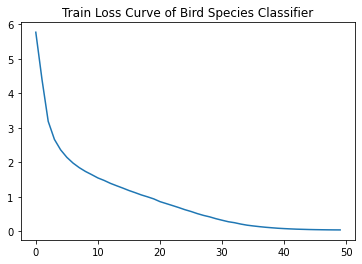

In [17]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Bird Species Classifier')

Text(0.5, 1.0, 'Validation Accuracy Curve of Bird Species Classifier')

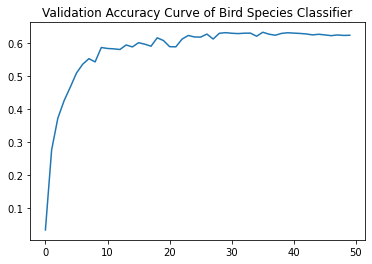

In [18]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Bird Species Classifier')

Text(0.5, 1.0, 'Log-score Curve of Bird Species Classifier')

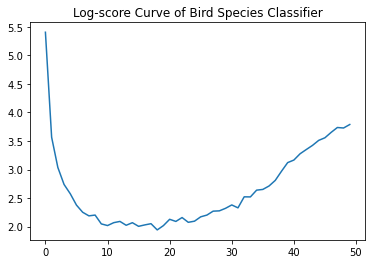

In [19]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Bird Species Classifier')

Text(0.5, 1.0, 'F-beta score Curve of Bird Species Classifier')

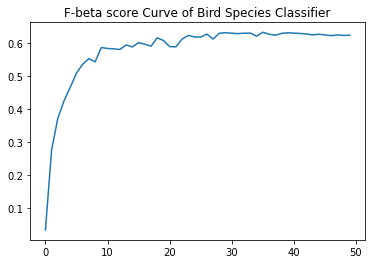

In [20]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Bird Species Classifier')

In [21]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 62.11
Log Loss score:	3.78
Fbeta-score (beta=1.0): 	0.62
